In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

#import spacy and load the language library
import spacy
import re
nlp = spacy.load('en_core_web_sm')

In [3]:
from PIL import Image
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\backpacker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

### 1. importing data

In [87]:
data = pd.read_csv("amazon_alexa.tsv",sep='\t')
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1

### 2. getting data ready

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [89]:
data['rating'].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

In [90]:
def rating_fn(r):
    if r['rating'] == 3.0:
        val = 'neutral'
    elif r['rating'] == 1.0 or r['rating'] == 2.0:
        val = 'negative'
    elif r['rating'] == 4.0 or r['rating'] == 5.0:
        val = 'positive'
    else:
        val = -1
    return val

data['rating_value'] = data.apply(rating_fn, axis=1)
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback rating_value  
0                                      Love my Echo!         1     positive  
1                                          Loved it!         1     positive  
2  Sometimes while playing a game, you can answer...         1     positive  
3  I have had a lot of fun with this thing. My 4 ...         1     positive  
4                                              Music         1     positive

### 3. pre-processing text

#### a) removing unwanted symbols and punctuations

In [91]:
# Creating a function to clean the tweets

def cleantwt (twt):
  emoji = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002500-\U00002BEF"  # chinese char
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         u"\U0001f926-\U0001f937"
         u"\U00010000-\U0010ffff"
         u"\u2640-\u2642" 
         u"\u2600-\u2B55"
         u"\u200d"
         u"\u23cf"
         u"\u23e9"
         u"\u231a"
         u"\ufe0f"                  # dingbats
         u"\u3030"
                      "]+", re.UNICODE)

  twt = re.sub('RT', '', twt)                                    # remove 'RT' from tweets
  twt = re.sub('#[A-Za-z0-9]+', '', twt)                         # remove the '#' from the tweets
  twt = re.sub('\\n', '', twt)                                   # remove the '\n' character
  twt = re.sub('https?:\/\/\S+', '', twt)                        # remove the hyperlinks
  twt = re.sub('@[\S]*', '', twt)                                # remove @mentions
  twt = re.sub('^[\s]+|[\s]+$', '', twt)                         # remove leading and trailing whitespaces
  twt = re.sub(emoji, '', twt)                                   # remove emojis
  twt = re.sub("[^A-Za-z]+"," ",twt).lower()                     # converting to lower
  twt = re.sub("[0-9]+"," ",twt)

  return twt

In [92]:
# Create a new column with the cleaned tweets

data['Cleaned_reviews'] = data['verified_reviews'].apply(cleantwt)
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback rating_value  \
0                                      Love my Echo!         1     positive   
1                                          Loved it!         1     positive   
2  Sometimes while playing a game, you can answer...         1     positive   
3  I have had a lot of fun with this thing. My 4 ...         1     positive   
4                                              Music         1     positive   

                                     Cleaned_reviews  
0                                      love my echo   
1                                          loved it   
2  sometimes while playing a game you can answer ...  
3  i have had a lot of fun with this thing my yr ...  
4                                              music

#### b) droping empty rows

In [93]:
data.drop(data[data['Cleaned_reviews'] == ''].index, inplace = True)

In [94]:
data.reset_index(drop=True, inplace=True)                                

#### c) count vectorizer

In [95]:
vectorizer = CountVectorizer(ngram_range=(1,1))
x = vectorizer.fit_transform(data['Cleaned_reviews'])
print(x.toarray()) 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### d) creating nlp documents for the corpus "Cleaned_reviews"

In [96]:
def twt (doc):
    doc = nlp(doc)
    return doc

In [97]:
data['reviews_doc'] = data['Cleaned_reviews'].apply(twt)
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback rating_value  \
0                                      Love my Echo!         1     positive   
1                                          Loved it!         1     positive   
2  Sometimes while playing a game, you can answer...         1     positive   
3  I have had a lot of fun with this thing. My 4 ...         1     positive   
4                                              Music         1     positive   

                                     Cleaned_reviews  \
0                                      love my echo    
1                                          loved it    
2  sometimes while playing a game you can answer ...   
3  i have had a lot of fun with this thing my yr ...   
4                                              music   

                                         reviews_doc  
0                                   (love, my, echo)  
1                                        (loved, it)  
2  (sometimes, while, playing, a, game, you, can,...  
3  (i, have, had, a, lot, of, fun, with, this, th...  
4                                            (music)

#### e) tokenization

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3065 non-null   int64 
 1   date              3065 non-null   object
 2   variation         3065 non-null   object
 3   verified_reviews  3065 non-null   object
 4   feedback          3065 non-null   int64 
 5   rating_value      3065 non-null   object
 6   Cleaned_reviews   3065 non-null   object
 7   reviews_doc       3065 non-null   object
dtypes: int64(2), object(6)
memory usage: 191.7+ KB


In [99]:
for i in range (0,3065) :
    for token in data['reviews_doc'][i] :
        print (token.text,end = '|')
    print ("\n")

love|my|echo|

loved|it|

sometimes|while|playing|a|game|you|can|answer|a|question|correctly|but|alexa|says|you|got|it|wrong|and|answers|the|same|as|you|i|like|being|able|to|turn|lights|on|and|off|while|away|from|home|

i|have|had|a|lot|of|fun|with|this|thing|my|yr|old|learns|about|dinosaurs|i|control|the|lights|and|play|games|like|categories|has|nice|sound|when|playing|music|as|well|

music|

i|received|the|echo|as|a|gift|i|needed|another|bluetooth|or|something|to|play|music|easily|accessible|and|found|this|smart|speaker|can|t|wait|to|see|what|else|it|can|do|

without|having|a|cellphone|i|can|not|use|many|of|her|features|i|have|an|ipad|but|do|not|see|that|of|any|use|it|is|a|great|alarm|if|u|r|almost|deaf|you|can|hear|her|alarm|in|the|bedroom|from|out|in|the|living|room|so|that|is|reason|enough|to|keep|her|it|is|fun|to|ask|random|questions|to|hear|her|response|she|does|not|seem|to|be|very|smartbon|politics|yet|

i|think|this|is|the|th|one|i|ve|purchased|i|m|working|on|getting|one|in|ev

great|technology|can|t|believe|the|speaker|volume|and|quality|is|so|wonderful|wish|i|had|bought|another|one|

i|purchased|an|echo|dot|for|my|husband|for|fathers|day|he|uses|it|constantly|and|after|hearing|the|quality|of|sound|of|the|echo|nd|generation|it|was|a|no|brainer|best|gift|ever|

works|fine|

clear|music|

fun|to|use|good|sound|quality|

the|echo|works|well|i|was|able|to|sync|it|with|my|other|amazon|music|devices|

works|great|but|i|don|t|think|amazon|should|charge|another|cent|for|unlimited|music|when|you|have|prime|and|buy|an|echo|

already|had|an|echo|dot|the|echo|is|even|better|with|fuller|sound|also|during|setup|it|now|lets|phone|calls|to|be|made|to|my|contact|list|which|is|great|

the|speaker|sounds|really|good|

good|sound|works|well|

love|it|and|alexa|i|am|not|very|savvy|but|support|was|very|helpful|and|patient|

love|it|i|was|thinking|about|getting|one|and|when|the|prime|day|discount|was|offered|i|could|not|pass|it|up|it|s|fun|to|ask|alexa|to|play|any|song|or|group|an

this|is|great|item|and|just|added|audible|books|which|makes|it|even|better|thank|you|

during|prime|day|this|nd|gen|echo|was|on|sale|so|i|couldn|t|resist|this|was|the|beginning|to|my|smart|home|set|up|and|i|couldn|t|be|happier|to|say|that|alexa|has|done|an|amazing|job|connecting|to|all|of|my|smart|devices|thanks|to|her|i|can|control|my|lights|smart|plugs|tv|etc|i|had|no|trouble|connecting|the|echo|to|my|wifi|and|my|phone|the|app|works|perfectly|fine|and|it|let|s|you|add|skills|routines|smart|devices|timers|and|so|much|more|sound|quality|is|good|enough|for|me|since|i|am|not|an|audiophile|alexa|can|hear|my|voice|even|when|watching|movies|at|a|high|volume|design|is|great|and|modern|it|will|definitely|add|a|nice|touch|to|your|home|and|you|can|change|the|covers|if|you|d|like|as|there|are|more|for|sale|overall|this|is|a|great|addition|to|my|home|and|enables|so|many|possibilities|if|you|haven|t|yet|be|sure|to|add|alexa|to|your|home|

versatile|and|fun|

works|great|killer|speaker|my|wife|and|

i|m|having|trouble|connecting|my|tv|to|it|but|i|m|not|exactly|tech|smart|i|m|sure|one|of|my|grandsons|will|figure|it|out|for|me|so|far|i|ve|been|using|it|mostly|for|music|

simply|love|my|echo|i|hardly|watch|any|tv|at|all|anymore|i|m|too|busy|listening|to|music|speaker|is|pretty|goo|for|its|size|all|the|fun|skills|really|make|the|echo|fun|for|my|whole|family|

enjoyed|entire|echo|experience|

easy|to|set|up|

the|echo|is|an|amazing|device|many|times|it|seems|very|intuitive|but|at|other|times|i|ask|for|something|that|seems|clear|and|simple|and|get|no|result|installation|was|fairly|straightforward|but|i|messed|up|several|times|simply|because|i|thought|a|step|was|complete|when|it|wasn|t|this|actually|made|me|lose|ground|until|i|figured|that|out|my|advice|is|to|be|patient|the|app|will|let|you|know|when|you|can|move|on|to|the|next|step|my|biggest|issue|of|the|moment|is|that|we|have|several|echo|devices|in|our|home|and|i|would|like|to|use|them|as|intercoms|which|i|am|told|can|be|done|however


this|is|my|second|echo|i|have|the|dot|but|the|speaker|is|weak|so|i|purchased|this|and|for|listening|to|music|the|speaker|is|great|

great|sound|

great|

we|really|only|use|this|as|a|speaker|to|stream|music|we|ve|had|it|months|and|it|s|just|kinda|useless|

once|set|up|very|user|friendly|set|up|wasn|t|as|user|friendly|as|i|d|hoped|the|alexa|app|should|be|able|to|download|to|a|pc|without|installing|invasive|drivers|my|wife|and|i|are|both|retired|and|she|wouldn|t|have|been|able|to|install|alexa|but|if|my|son|wasn|t|supplying|her|with|a|smart|phone|we|wouldn|t|be|using|alexa|yet|

very|easy|set|up|really|enjoying|it|

the|echo|doesn|t|come|with|a|built|in|battery|so|it|has|to|be|plugged|in|at|all|times|to|use|it|makes|it|quite|inconvenient|

more|compact|and|a|bit|better|than|the|original|

i|love|it|pretty|cool|

i|having|it|in|my|living|room|music|sounds|really|good|in|my|living|room|i|can|hear|it|upstairs|

this|is|a|great|product|set|up|was|easy|sound|is|wonderful|

so|far|i|like|it|i

item|has|never|worked|out|of|box|it|is|broken|spent|several|days|trying|to|get|it|working|and|running|same|fixes|from|amazon|the|only|thing|accomplished|is|i|will|never|order|another|refurbished|device|

i|already|have|the|echo|plus|bought|this|one|for|my|bedroom|love|the|functions|

simple|set|up|music|everywhere|

worked|just|like|a|brand|new|dot|so|i|am|very|satisfied|

great|product|but|returning|for|new|alexa|dot|refurbished|is|already|giving|me|problems|with|connection|

we|have|a|few|echos|already|went|for|this|one|in|refurbished|to|save|a|few|bucks|it|works|great|i|love|this|new|generation|one|because|it|has|a|rubber|bottom|nice|

i|love|the|fact|that|i|can|unplug|it|and|take|it|to|my|basement|when|i|want|do|laundry|

refurbished|but|just|as|good|as|the|new|ones|that|i|ve|bought|

good|as|new|

granddaughter|loves|it|

the|price|is|great|was|having|trouble|with|it|hearing|me|from|across|a|room|but|after|moving|it|to|another|spot|it|seems|to|be|working|fine|will|buy|some|more|wa

two|weeks|after|setting|it|up|it|no|longer|works|no|connection|no|light|no|sound|i|guess|i|shouldn|t|have|purchased|a|refurbished|dot|

it|worked|like|a|brandnew|unit|great|addition|to|my|collection|

great|price|works|perfectly|saved|the|money|on|a|refurb|would|buy|again|

very|god|

not|good|at|all|

these|are|great|i|bought|one|and|then|bought|another|right|away|grab|a|few|of|these|and|a|few|smart|switched|and|you|re|set|with|smart|home|capabilities|for|under|highly|recommended|

just|like|new|

worked|as|it|should|still|need|to|figure|out|how|to|link|to|other|devices|though|only|set|up|sonos|which|was|pretty|easy|not|the|products|fault|just|have|not|had|time|to|figure|it|out|

very|useful|

this|is|the|worst|amazon|purchase|i|have|made|i|am|big|amazon|fan|love|the|brand|unlimited|digital|music|prime|videos|even|buy|my|online|games|music|and|movies|through|amazon|this|app|i|have|tried|to|use|it|make|simple|purchases|to|do|anything|it|is|useless|

works|very|well|but|the|microphone|d

this|is|a|great|device|we|mainly|use|it|to|verbally|add|things|to|the|shopping|list|but|occasionally|use|any|number|of|the|fun|things|you|can|program|it|to|do|like|go|to|red|alert|or|make|the|tardis|land|yes|we|re|a|house|of|geeks|we|even|chose|the|wake|word|to|be|computer|instead|of|alexa|now|we|just|need|majel|barret|s|voice|and|i|will|be|in|geek|heaven|it|s|not|as|easy|to|get|my|premium|spotify|to|work|properly|with|it|and|still|not|sure|how|we|can|get|multiple|music|accounts|attached|so|we|can|listen|to|different|music|in|different|rooms|but|so|far|it|s|still|been|worth|it|i|am|often|asking|it|the|time|the|weather|it|even|gives|us|a|news|briefing|we|also|use|it|as|an|intercom|system|which|has|been|really|awesome|plus|it|s|fun|knowing|the|nsa|is|listening|to|everything|

we|all|love|her|

i|purchased|this|for|my|daughter|and|we|all|love|this|its|amazing|we|love|the|games|

it|doesn|t|always|work|

good|as|new|perfectly|packaged|and|i|have|had|zero|issues|with|the|dot|

love|it|bough

like|new|no|difference|from|new|unused|original|

i|have|no|complaints|as|far|as|i|know|these|are|exactly|like|new|just|a|little|cheaper|great|

perfect|condition|

like|new|

it|works|just|as|well|as|the|new|version|i|got|as|a|discount|with|my|echo|speaker|i|decided|to|purchase|this|version|because|amazon|states|it|has|the|same|warranty|

i|received|the|echo|as|a|gift|i|needed|another|bluetooth|or|something|to|play|music|easily|accessible|and|found|this|smart|speaker|can|t|wait|to|see|what|else|it|can|do|

without|having|a|cellphone|i|can|not|use|many|of|her|features|i|have|an|ipad|but|do|not|see|that|of|any|use|it|is|a|great|alarm|if|u|r|almost|deaf|you|can|hear|her|alarm|in|the|bedroom|from|out|in|the|living|room|so|that|is|reason|enough|to|keep|her|it|is|fun|to|ask|random|questions|to|hear|her|response|she|does|not|seem|to|be|very|smartbon|politics|yet|

i|think|this|is|the|th|one|i|ve|purchased|i|m|working|on|getting|one|in|every|room|of|my|house|i|really|like|what|features|they|o

i|bought|this|because|it|can|control|fios|television|it|works|well|i|m|hoping|over|time|it|will|do|more|to|control|fios|then|i|discovered|all|the|other|things|alexa|can|do|play|music|you|ask|for|great|sound|from|alexa|play|games|play|radio|stations|play|old|time|radio|programs|like|the|long|ranger|alexa|has|many|apps|you|can|add|to|her|abilities|the|other|day|i|played|madlibs|great|fun|also|alexa|can|control|household|appliances|i|just|purchased|alexa|compatible|power|strips|to|control|lighting|fans|and|tv|components|i|m|looking|forward|to|implementing|this|controll|you|can|also|add|other|alexa|components|to|have|chosen|music|to|play|in|all|rooms|where|the|components|are|located|

the|speaker|has|excellent|sound|and|works|perfectly|

i|like|it|all|

i|love|it|it|does|everything|

i|was|a|little|nervous|when|i|received|my|new|echo|as|i|m|not|really|tech|savvy|i|found|it|a|bit|intimidating|at|first|but|it|didn|t|take|me|to|long|to|figure|it|out|i|m|very|happy|with|my|purchase|and|now|thi

i|have|not|found|a|way|to|access|my|echo|thorough|my|prime|account|i|think|it|should|be|part|of|the|top|line|with|video|music|etc|i|also|think|the|setup|app|where|i|define|for|example|music|i|like|is|not|well|integrated|into|echo|i|have|tried|to|ask|for|my|playlist|and|echo|is|not|sure|even|though|i|set|up|play|list|in|my|settings|i|also|do|not|like|the|fact|that|my|words|have|to|be|exact|match|of|my|playlist|names|which|i|can|never|remember|i|like|the|ready|nature|of|echo|to|respond|to|most|any|queries|

this|is|great|item|and|just|added|audible|books|which|makes|it|even|better|thank|you|

during|prime|day|this|nd|gen|echo|was|on|sale|so|i|couldn|t|resist|this|was|the|beginning|to|my|smart|home|set|up|and|i|couldn|t|be|happier|to|say|that|alexa|has|done|an|amazing|job|connecting|to|all|of|my|smart|devices|thanks|to|her|i|can|control|my|lights|smart|plugs|tv|etc|i|had|no|trouble|connecting|the|echo|to|my|wifi|and|my|phone|the|app|works|perfectly|fine|and|it|let|s|you|add|skills|routine

i|bought|this|to|replace|a|dot|in|my|living|room|speaker|is|slightly|better|it|hears|me|better|over|the|tv|unfortunately|it|doesn|t|understand|or|respond|to|my|requests|as|well|as|the|dot|i|frequently|have|to|request|or|times|to|get|it|to|do|what|i|want|the|dot|usually|does|exactly|what|i|want|on|the|first|request|i|don|t|consider|it|an|upgrade|

i|have|had|all|good|experience|so|far|with|the|second|generation|echo|there|are|so|many|more|things|to|learn|but|i|have|not|had|the|time|yet|right|now|i|am|mostly|enjoying|the|music|weather|updates|using|the|alarm|feature|and|her|personality|i|have|also|purchased|some|mini|smart|socket|yes|i|am|very|excited|to|begin|using|them|

i|m|having|trouble|connecting|my|tv|to|it|but|i|m|not|exactly|tech|smart|i|m|sure|one|of|my|grandsons|will|figure|it|out|for|me|so|far|i|ve|been|using|it|mostly|for|music|

simply|love|my|echo|i|hardly|watch|any|tv|at|all|anymore|i|m|too|busy|listening|to|music|speaker|is|pretty|goo|for|its|size|all|the|fun|skills|real

i|having|it|in|my|living|room|music|sounds|really|good|in|my|living|room|i|can|hear|it|upstairs|

this|is|a|great|product|set|up|was|easy|sound|is|wonderful|

so|far|i|like|it|i|bought|it|just|for|some|music|though|and|it|sounds|pretty|good|

love|it|

love|it|

glad|i|bought|this|

like|all|types|of|fun|music|and|more|

i|like|the|volume|up|and|down|on|the|top|so|i|can|turn|it|down|quickly|

beyond|my|capabilities|to|program|grandkids|lve|it|

i|love|my|new|echo|it|gives|me|hours|of|music|and|help|with|other|things|it|was|difficult|for|me|to|set|it|up|i|had|to|have|help|from|a|tekkie|

almost|as|good|as|my|bose|love|the|whole|house|music|

alexa|hardly|came|on|

easy|setup|using|the|app|which|was|also|easy|to|install|on|my|phone|the|sound|quality|while|for|listening|to|music|on|pandora|is|wonderful|

i|m|still|learning|how|to|use|the|echo|but|so|far|i|love|it|

works|awesome|

works|great|

from|such|a|small|speaker|it|sounds|great|

great|sound|for|the|size|and|the|prize|and|of|cours

it|was|smaller|than|i|had|anticipated|and|when|i|say|that|i|very|much|mean|it|however|it|still|works|very|well|quality|sound|easily|programmed|easy|to|work|with|but|alexa|is|not|anywhere|as|good|as|other|voice|programs|

love|my|echo|spot|

great|deal|great|product|

perfect|

i|had|a|couple|of|echo|dots|previously|bought|these|specifically|for|the|ring|doorbell|video|cloud|cam|display|interface|capabilities|was|not|disappointed|love|the|fact|that|i|can|ask|to|see|front|yard|back|yard|front|door|etc|the|video|chat|with|the|other|rooms|is|also|quite|cool|bonus|alexa|show|me|ant|man|trailer|etc|i|know|this|can|all|be|done|on|laptop|desktop|but|it|s|cool|now|having|an|appliance|that|s|always|just|there|and|it|doesn|t|interrupt|what|i|m|doing|

bought|this|for|my|bedroom|and|the|show|for|my|living|room|love|them|both|the|spot|is|perfect|for|bedside|and|has|an|impressive|design|shows|lyrics|photos|etc|i|paired|it|with|a|smart|plug|for|the|bedroom|lamps|alexa|turn|off|lights|love|it|

love|t

did|nt|think|i|d|get|an|alexa|device|but|this|is|perfect|for|my|home|office|the|screen|adds|just|that|little|piece|that|makes|it|worth|the|extra|cost|of|the|other|alexa|devices|it|can|show|lyrics|of|songs|play|my|xm|radio|can|show|videos|of|movie|trailers|and|news|its|great|

i|love|it|i|made|a|group|with|my|echo|dot|so|i|get|music|through|my|home|i|am|waiting|for|the|to|go|on|sale|again|so|hopefully|i|can|get|another|spot|for|my|bedroom|i|love|the|alarm|and|weather|at|the|sound|of|my|voice|

when|we|first|received|this|product|it|was|great|however|about|a|week|ago|the|device|served|up|a|video|advertisement|around|pm|at|night|and|scared|myself|and|my|family|if|you|want|to|make|sure|you|are|protected|and|don|t|allow|video|directly|in|your|home|the|spot|is|not|a|device|that|can|keep|you|safe|

it|s|fun|to|use|and|makes|my|life|easier|in|some|sense|

love|it|

i|got|my|echo|spot|on|prime|day|and|love|it|i|think|it|still|is|a|little|expensive|but|the|chance|to|save|convinced|me|to|buy|it|i

a|great|replacement|for|the|bedside|alarm|clock|which|had|a|funny|habit|of|going|off|at|am|every|time|the|cleaning|ladies|came|through|we|mostly|use|it|to|turn|the|ceiling|fan|lights|on|and|off|while|leaving|the|fan|running|only|gripe|would|be|the|mic|sensitivity|which|doesn|t|appear|be|as|good|as|the|view|or|gen|it|can|get|a|little|frustrating|having|to|repeat|yourself|

this|product|has|made|my|life|much|simpler|with|a|little|one|i|use|it|a|lot|for|music|and|when|i|have|my|hands|full|turning|it|on|off|or|up|down|is|a|breeze|the|screen|is|a|great|novelty|where|i|can|watch|the|news|

works|well|and|was|easy|to|set|up|

love|my|spot|it|now|acts|as|my|new|alarm|

this|is|the|one|of|my|favorite|amazon|devices|have|one|in|my|bedroom|and|use|as|alarm|clock|perfect|addition|to|our|home|of|alexa|devices|

wasn|t|so|sure|about|bringing|smart|technology|into|my|home|but|i|m|hooked|i|love|the|sleek|look|of|the|echo|spot|on|my|nightstand|and|how|easy|it|was|to|set|up|and|use|i|also|love|that|it|s

not|happy|with|the|spot|reset|numerous|times|seems|to|be|in|slow|mode|have|to|be|practically|on|top|of|it|for|it|to|hear|me|even|after|talking|with|support|i|still|do|not|have|themes|in|the|menu|to|choose|from|

husband|loves|it|

 |love|it|

love|the|spot|awesome|little|guy|with|precise|video|i|m|saving|to|buy|one|for|my|mom|on|the|east|coast|the|spot|changes|everything|as|far|as|keeping|your|loved|ones|connected|well|worth|every|cent|

all|is|fine|with|the|spot|exact|for|one|massive|failing|in|order|to|turn|off|a|repeating|alarm|in|the|morning|you|pretty|much|have|to|talk|which|is|not|a|thing|you|usually|want|to|do|when|first|woken|up|and|your|bed|partner|will|definitely|not|like|yes|you|can|manually|swipe|up|on|the|alarm|face|to|dismiss|but|i|swiping|up|rather|than|touching|screen|when|you|are|half|asleep|is|very|difficult|and|results|in|setting|snooze|more|than|half|the|time|even|if|you|really|try|to|swipe|to|dismiss|and|ii|if|you|do|manage|to|swipe|up|to|dismiss|then|you|completel

we|gave|the|echo|spot|as|a|gift|to|my|mother|in|law|she|loves|it|she|can|play|music|of|all|genres|easy|for|her|to|use|

very|easy|to|set|up|does|what|is|said|it|will|very|satisfied|so|far|

great|product|need|a|bit|a|adjustment|to|set|up|spotify|time|weather|etc|in|hong|kong|but|works|fine|now|i|used|it|as|alarm|clock|music|in|bedroom|love|it|

i|bought|this|to|replace|a|dot|in|my|bedroom|already|have|a|show|and|a|couple|of|full|sized|echo|units|in|my|house|the|spot|is|okay|for|what|it|is|two|issues|one|minor|and|one|major|the|minor|one|why|include|the|huge|bezel|on|the|front|why|not|take|that|space|and|make|the|display|larger|a|total|waste|of|usable|space|the|major|one|also|involves|the|show|i|m|very|used|to|these|devices|i|don|t|need|to|see|things|to|try|whenever|i|use|a|voice|command|with|it|even|setting|it|to|rotate|once|starts|this|crap|over|again|when|you|dare|to|actually|use|the|devices|i|m|not|a|child|and|i|don|t|need|to|be|told|a|hundred|times|how|to|play|music|on|it|and|havin

love|this|thing|people|think|i|m|crazy|for|paying|this|much|for|a|glorified|alarm|clock|but|i|don|t|care|for|me|waking|up|in|a|good|mood|is|pretty|important|and|this|helps|me|do|it|so|glad|i|don|t|have|to|deal|with|my|old|eeaanh|eeaanh|eeaanh|alarm|very|excited|to|say|alexa|turn|off|the|lights|smart|plugs|get|here|soon|got|a|camera|privacy|slide|for|this|since|it|is|in|my|bedroom|

i|absolutely|love|this|very|user|friendly|and|i|got|the|kasa|cam|to|go|with|it|to|monitor|my|living|room|super|easy|to|set|up|and|operate|i|only|wish|it|actually|came|with|the|camera|privacy|cover|and|pivoting|stand|which|you|can|buy|separately|i|m|looking|forward|to|future|software|updates|for|different|clock|faces|i|like|digital|but|i|miss|the|colon|in|between|the|hours|and|minutes|on|most|of|them|i|d|also|like|to|see|more|celebs|jump|on|board|for|the|alarm|voices|i|really|have|no|complaints|i|m|being|nit|picky|at|this|point|worth|every|penny|

surprisingly|good|beefy|sound|out|of|this|thing|i|think|it|mig

love|the|echo|show|being|able|to|see|the|lyrics|of|the|songs|as|they|play|or|to|be|able|to|put|a|recipe|up|on|the|screen|is|wonderful|

it|seems|to|work|well|unfortunately|a|lot|of|the|functionality|is|lost|because|as|many|have|mentioned|it|does|not|work|with|google|or|youtube|any|more|this|problem|is|caused|by|google|because|they|came|up|with|their|own|devices|an|no|longer|allow|access|from|other|devices|like|these|this|even|effected|my|smart|tv|anyhow|we|purchased|a|few|of|these|to|communicate|with|our|children|and|grandchildren|so|we|ll|see|what|happens|when|we|hand|them|out|

love|listening|to|music|still|trying|to|learn|everything|it|does|

very|pleasedsimple|to|figure|out|

just|what|i|expected|already|have|other|shows|

very|good|

excellent|to|listen|to|my|music|my|audio|books|and|look|all|my|cameras|in|and|around|my|house|

alexa|is|fun|i|ve|added|smart|home|aspects|my|friend|listens|to|spotify|my|husband|enjoys|interacting|too|

tremendous|way|to|communicate|with|friends|and|

love|it|very|much|still|learning|everything|that|my|echo|can|do|but|am|really|enjoying|the|whole|process|

love|it|still|learning|all|the|possibilities|

i|love|the|echo|show|awesome|speakers|i|love|the|fact|when|you|listen|to|music|the|words|come|up|all|around|liking|it|so|far|also|being|able|to|read|what|s|on|your|shopping|list|to|do|list|and|notifications|

nice|works|great|

easy|to|set|up|and|sooooooo|many|things|it|can|do|just|awesome|

met|every|expectation|i|had|

i|like|it|

unit|is|working|great|but|it|is|a|true|pia|that|products|today|are|shipped|without|user|manuals|do|manufacturers|truly|believe|that|user|will|magically|know|the|full|capabilities|of|each|product|purchased|i|have|no|idea|of|the|echo|show|s|capabilities|i|have|it|linked|to|my|hue|lights|but|have|no|idea|what|commands|will|work|and|what|won|t|i|purchased|a|fire|tv|stick|along|with|the|show|but|have|no|idea|how|to|maximize|the|two|just|a|few|examples|i|even|purchased|a|text|that|other|users|have|found|to|be|he

i|ve|had|previous|experience|with|the|echo|dot|and|this|just|blows|all|previous|expectations|out|of|the|water|it|s|great|since|it|can|play|videos|and|music|from|multiple|sources|and|the|speakers|are|pretty|loud|

love|the|echo|show|can|keep|i|can|video|chat|with|the|kids|and|grandkids|i|have|it|in|the|kitchen|so|when|i|run|out|of|something|i|have|alexa|to|add|it|to|my|grocery|list|i|use|it|for|everything|was|very|easy|to|set|up|

i|m|really|hoping|for|skills|that|take|advantage|of|the|shows|touch|screen|there|s|an|incredible|amount|of|untapped|potential|locked|behind|the|restrictions|make|use|of|the|best|part|of|having|the|show|and|enable|skills|to|navigate|by|touch|please|

love|it|l|i|plan|on|getting|an|echo|for|the|kitchen|

it|does|not|pick|up|my|voice|unless|i|yell|most|times|

great|love|it|

amazing|

fire|hd|does|so|much|more|over|priced|pair|of|speakers|

seems|to|be|a|good|product|but|unable|to|play|music|in|sync|with|my|sonos|system|sonos|doesn|t|seem|to|recognize|it|at|all|

echo|show|is|said|to|work|with|certain|apps|but|not|cozi|state|works|with|echo|show|but|the|cozi|family|s|doesn|t|very|well|amazon|needs|to|go|back|to|drawing|board|it|would|be|such|a|needed|piece|of|technology|but|it|lacks|the|essential|please|fix|cost|of|the|echo|show|was|marvelous|got|echo|show|to|take|on|shopping|list|but|that|is|all|so|far|adding|items|to|list|has|long|lag|and|it|not|my|router|being|slow|my|provider|speed|is|gb|speed|not|a|problem|but|before|new|items|is|updated|on|cozi|is|very|slow|help|is|needed|to|get|it|updated|to|a|working|conditioning|

all|the|music|i|can|listen|too|also|the|movie|i|can|watch|i|can|see|my|ring|doorbell|

no|enough|video|options|

great|sound|

i|took|advantage|of|prime|friday|and|decided|to|take|a|chance|and|purchase|one|i|enjoy|the|features|it|comes|with|i|m|sorry|i|didn|t|purchase|two|of|them|well|worth|the|money|its|looks|great|on|my|nightstand|every|night|it|puts|me|to|steep|with|sleeping|music|happy|customer|

the|music|the|shopping|li

the|ability|to|respond|with|the|accuracy|and|variety|of|information|provided|by|google|search|has|spoiled|me|i|had|originally|expected|to|see|that|the|same|type|of|search|engine|in|the|echo|not|so|the|ability|of|alexa|to|provide|such|detailed|information|is|not|part|of|the|package|perhaps|improvements|are|in|the|offing|with|further|updates|

my|daughter|has|an|echo|show|and|she|told|me|how|much|she|loved|it|i|bought|a|white|one|for|my|kitchen|and|absolutely|love|it|it|has|all|the|features|of|the|others|plus|great|extras|the|sound|system|is|awesome|i|also|own|the|original|echo|tower|dots|and|spot|each|are|great|and|have|their|uses|around|my|house|i|highly|recommend|all|of|these|products|

really|like|the|show|me|feature|i|also|like|video|calls|with|others|

i|love|this|device|i|bought|it|simple|so|that|i|can|have|an|alarm|clock|with|my|amazon|echo|and|during|prime|day|for|the|price|you|couldn|t|beat|it|but|i|have|sonos|and|big|ass|fan|lights|that|i|am|able|to|control|with|this|device|it

we|are|very|pleased|with|this|item|the|display|is|clean|and|crisp|and|easy|to|read|we|enjoy|trying|the|suggested|things|to|try|asking|alexa|we|use|the|timer|feature|quite|a|bit|and|have|added|our|calendars|and|contacts|we|are|still|exploring|the|many|skills|available|

device|has|great|speakers|and|the|screen|quality|is|phenomenal|

we|now|have|a|dot|spot|echo|and|show|and|love|the|show|and|spot|best|the|show|has|great|sound|and|my|wife|loves|the|display|for|weather|recipes|and|sing|alongside|super|deal|

it|doesn|t|play|you|tube|videos|

was|working|great|til|week|algo|have|it|for|a|month|but|it|started|flickering|and|in|the|support|forums|they|say|it|is|a|known|isue|but|it|has|more|the|months|reported|and|there|is|no|soluci|n|

we|like|the|video|calling|feature|we|got|this|so|we|can|be|in|contact|with|our|elderly|parents|and|it|works|well|

the|sound|on|these|is|terrible|it|s|like|a|tin|can|i|love|my|echo|but|this|item|is|awful|

i|have|been|waiting|for|the|echo|show|to|go|on|sale|an

this|is|very|hard|to|review|because|i|am|part|of|the|problem|i|am|and|got|it|so|my|dog|would|have|distracting|noise|when|i|am|not|home|i|am|computer|literate|itunes|literate|amazon|literate|as|well|as|countless|other|programs|but|am|apparently|a|dunce|when|it|comes|to|talking|to|alexa|i|think|i|heard|her|sigh|in|exasperation|i|tried|to|create|a|playlist|of|songs|i|like|only|to|have|it|ignored|i|am|learning|workarounds|but|they|are|mediocre|at|best|and|as|yet|do|not|include|a|personal|playlist|i|have|scoured|the|beginners|section|but|the|beginners|it|addresses|are|far|more|advanced|in|basic|alexa|than|am|i|so|far|i|like|what|i|have|been|able|to|use|but|i|d|like|it|a|lot|more|if|i|could|configure|it|to|my|needs|rather|than|accepting|the|amazon|alexa|default|karen|

very|satisfied|with|the|purchase|the|package|came|in|good|time|and|was|just|as|expected|

great|sound|easy|set|up|looks|cool|

love|the|echo|plus|much|better|versatility|than|the|first|generation|echo|intercom|and|voice|contro

i|purchased|the|echo|plus|with|the|build|in|hub|so|i|could|have|the|convenience|of|asking|alexa|to|turn|my|lights|and|lamps|on|and|off|philips|hue|light|bulbs|were|placed|in|the|fixtures|that|i|wanted|alexa|to|control|and|they|all|work|great|i|already|had|an|echo|dot|in|my|kitchen|den|area|so|i|placed|the|echo|plus|with|hub|in|my|bedroom|my|radio|and|lamps|in|my|kitchen|and|den|are|controlled|with|tp|link|plugs|but|the|ceiling|light|fixtures|and|lamp|in|my|den|and|bedroom|have|special|philips|hue|light|bulbs|that|are|controlled|by|the|hub|inside|the|echo|plus|i|am|able|to|play|music|set|my|alarm|get|weather|reports|and|numerous|other|things|on|both|devices|the|echo|dot|requires|a|tp|link|plug|to|be|plugged|into|it|and|the|echo|plus|requires|a|special|philips|light|bulbs|installed|in|each|light|fixture|to|work|the|only|thing|i|dislike|is|the|high|price|of|the|light|bulbs|required|to|make|the|lights|work|regular|light|bulbs|placed|in|the|ceiling|light|fixtures|will|not|work|with|alexa|an

nice|add|on|to|a|home|what|i|don|t|like|are|the|limitations|for|example|world|soccer|it|won|t|give|you|much|info|of|sport|teams|other|than|american|

i|was|a|little|apprehensive|about|buying|this|because|i|saw|reviews|saying|it|sounds|like|crap|i|m|no|audiophile|by|any|means|so|maybe|it|s|that|but|i|think|it|sounds|great|considering|the|size|it|fills|my|living|room|with|sound|and|gets|pretty|loud|while|remaining|clear|i|haven|t|had|any|issues|pairing|with|my|devices|or|utilizing|any|of|the|voice|commands|i|have|it|paired|to|an|ecobee|my|firestick|and|a|phillip|s|hue|light|bulb|i|plan|on|adding|devices|as|i|go|i|love|this|thing|and|i|m|glad|i|scooped|it|up|i|have|only|had|it|around|weeks|will|update|if|i|run|into|issues|

i|love|my|echo|plus|the|only|drawback|is|that|there|is|no|battery|so|it|has|to|be|plugged|in|at|all|times|which|makes|it|inconvenient|to|use|outdoors|

great|device|my|grandkids|had|a|ball|setting|it|up|for|me|

the|alexa|is|awesome|but|when|i|rcieved|the|light|buld|i|

works|great|i|bought|this|direct|from|amazon|and|i|have|got|to|tell|you|this|item|echo|show|and|echo|plus|is|the|best|item|i|have|ever|had|and|i|am|kind|of|a|tech|geek|i|am|a|disabled|person|and|it|helps|me|turn|light|on|and|off|and|schedule|doctor|appointments|using|google|voice|phone|and|get|my|medical|rides|to|and|from|hospitals|plays|music|on|cue|from|multiple|web|apps|and|watch|videos|as|well|as|communicating|to|my|nurses|aide|my|schedule|and|calendar|of|events|i|wish|there|were|programs|that|helped|disabled|people|get|these|and|smart|lights|they|are|literally|the|best|items|since|chocolate|to|assist|the|disabled|and|literally|anybody|else|who|need|them|although|the|echo|show|is|not|a|hub|once|you|set|up|the|echo|plus|hub|with|your|lights|you|can|use|any|amazon|device|to|shut|the|lights|off|thank|god|no|more|working|my|ass|off|to|turn|on|or|off|lights|thank|you|amazon|i|will|save|up|enough|money|to|buy|more|gift|cards|from|affirm|com|to|purchase|more|of|each|and|some|lights|for|re

i|was|suppose|to|get|the|free|lightbulb|with|purchase|it|did|not|come|with|echo|upon|reading|more|carefully|it|says|to|click|a|box|to|receive|free|bulb|of|course|i|want|the|free|bulb|who|wouldn|t|just|a|sneaky|way|for|them|to|get|out|of|having|to|give|so|many|free|bulbs|away|disappointed|i|have|yet|to|set|up|my|echo|our|first|purchase|on|any|alexia|device|debating|if|we|want|to|keep|it|it|did|come|quickly|with|my|prime|membership|

i|bought|this|for|myself|and|i|didn|t|realize|it|had|to|be|plugged|in|just|to|work|it|isn|t|convenient|to|make|them|always|have|to|connect|to|a|wall|it|should|ve|been|more|clear|when|i|bought|it|

alexa|helps|with|more|than|just|lights|or|music|it|helps|out|when|your|kids|think|they|know|everything|and|you|know|nothing|lol|sweet|love|it|so|much|so|i|purchased|alexa|has|been|a|great|purchase|for|my|uncle|whom|lives|by|himself|when|i|got|it|he|was|nt|so|keen|on|it|but|now|its|his|best|friend|he|tells|her|goodmorning|and|she|will|say|it|back|along|with|a|descri

love|love|love|my|amazon|echo|plus|

the|sound|quality|is|not|that|good|especially|for|the|price|that|you|pay|for|this|i|would|recommend|to|get|the|echo|dot|and|buy|a|better|speaker|instead|maybe|sonos|and|use|the|echo|dot|

alexa|was|able|to|call|my|phone|when|i|couldn|t|find|it|and|also|turned|on|and|off|the|light|when|commanded|then|i|came|home|a|day|later|and|it|wouldn|t|turn|on|the|light|but|would|shut|it|off|then|she|said|i|had|no|devices|couldn|t|find|my|phone|now|working|again|we|will|see|love|the|selection|of|music|

i|will|be|returning|this|piece|of|garbage|as|soon|as|possible|with|my|lifetime|amazon|spending|approaching|nearly|i|m|sure|i|m|just|a|small|customer|to|them|but|i|ve|rarely|been|so|disappointed|out|of|hundreds|if|not|thousands|of|amazon|purchases|i|have|echos|for|home|automation|and|bought|this|echo|plus|specifically|for|the|built|in|hub|along|with|approximately|in|zigbee|light|switches|the|voice|control|is|subpar|even|when|it|works|and|that|is|a|rarity|most|often

love|the|fire|stick|i|can|download|watch|great|movies|instead|of|searching|i|use|alexa|voice|prime|doesn|t|offer|very|many|newer|movies|is|the|only|negative|i|also|wished|there|was|a|way|you|could|set|it|up|to|post|newest|movies|first|

very|easy|to|install|voice|control|is|great|

love|it|

great|buy|at|

i|am|guilty|of|not|setting|this|up|i|had|my|youngest|daughter|do|it|she|did|not|seem|to|have|much|trouble|figuring|it|out|so|i|would|have|to|assume|it|was|not|very|difficult|i|have|not|tried|to|use|it|yet|but|my|oldest|seems|to|like|it|so|she|ordered|one|for|herself|

one|problem|you|need|to|buy|an|app|from|amazon|to|mirroring|your|iphone|app|price|other|than|that|the|device|is|perfect|

streaming|is|easy|i|love|it|because|i|can|watch|netflix|in|my|bedroom|on|my|tv|and|not|my|ipad|

absolutely|love|it|

great|product|we|listen|to|music|all|the|time|

ummm|tv|like|everyone|else|

we|love|the|fire|tv|stick|and|will|love|it|even|more|when|we|sever|our|cable|connection|when|our|service|a

works|very|well|for|amazon|and|netflix|but|will|not|a|let|all|viewing|platforms|like|vudu|it|also|will|shut|down|if|hulu|is|played|for|more|than|a|couple|minutes|and|yes|i|have|it|directly|plugged|into|the|wall|so|low|power|source|is|not|an|issue|even|checked|outlet|voltage|an|issue|which|is|typically|the|answer|you|get|for|that|issue|over|all|the|quality|of|the|picture|is|quiet|well|and|is|a|user|friendly|platform|to|use|if|they|would|fix|those|two|issues|i|would|have|one|on|every|tv|in|the|house|but|as|it|sits|this|will|be|our|only|one|to|bad|to|because|i|relay|like|amazon|products|and|having|alexa|is|always|nice|

love|the|firestick|thinking|about|canceling|the|satellite|

i|m|amazed|at|how|many|movies|tv|shows|and|more|is|available|i|am|planning|to|drop|cable|service|soon|and|am|very|happy|to|know|i|ll|have|lots|of|viewing|pleasure|with|the|fire|stick|and|not|pay|the|outrageous|cable|bills|

easy|to|setup|sometimes|alexis|does|not|work|the|greatest|the|connection|fire|stick|and|wif

i|don|t|like|how|i|can|not|load|my|hulu|account|it|is|also|very|slow|i|know|it|is|not|my|internet|connection|because|i|have|an|xbox|one|that|works|just|fine|but|my|fire|tv|stick|takes|forever|to|load|anything|

amazing|for|all|your|entertainment|needs|

it|s|constantly|buffering|to|the|point|where|you|can|t|watch|anything|without|interruption|i|purchased|on|prime|day|plus|i|used|rewards|to|pay|for|it|so|in|the|end|i|paid|next|to|nothing|if|i|had|paid|full|price|for|it|i|might|want|my|money|back|we|stopped|trying|to|use|it|and|went|back|to|our|old|streaming|device|i|know|our|internet|service|is|not|the|issue|because|we|do|not|have|this|problem|with|any|other|devices|that|we|stream|from|

i|didn|t|realize|it|needed|an|external|power|source|in|order|to|utilize|the|fire|stick|i|thought|it|was|more|along|the|lines|of|a|flash|drive|device|you|singley|plugged|into|your|tv|however|since|using|my|amazon|fire|stick|i|have|enjoyed|every|moment|of|it|and|would|definitely|recommend|this|product|to|

great|entertainment|

being|able|to|use|it|with|my|alexa|echo|was|great|

easy|to|use|and|fast|setup|

love|it|

i|set|her|up|to|play|through|our|home|theater|system|so|fat|we|are|just|using|her|for|weather|forecasts|cooking|timers|and|we|really|enjoy|the|music|

small|device|that|my|kids|like|to|ask|questions|very|handy|friendly|interactive|

beyond|awesome|

i|like|that|it|responds|every|time|it|was|easy|to|set|up|i|m|still|learning|what|i|can|do|with|it|i|may|like|a|better|speaker|more|

family|loved|it|

i|like|how|it|will|connect|to|bluetooth|without|an|adapter|like|the|google|only|reason|for|stars|is|volume|level|without|external|speaker|easy|to|use|

echos|are|great|i|have|a|few|of|them|through|out|our|home|all|in|voice|range|to|ask|a|question|say|a|command|to|turn|lights|on|or|off|or|my|favorite|is|play|music|all|though|the|house|

love|it|this|time|it|s|a|gift|for|friend|

fantastic|product|i|use|it|as|a|smart|home|hub|and|to|play|music|through|speakers|mainly|the|customizable

i|really|love|my|dots|so|awesome|how|it|s|connects|all|my|rooms|but|like|you|ve|read|with|other|reviews|they|are|definitely|lower|in|volume|which|i|m|sure|if|i|connected|it|to|speaker|or|another|device|it|would|be|great|but|as|a|stand|alone|the|volume|is|just|ok|definitely|not|like|my|tall|echo|and|the|dots|don|t|pick|up|voice|as|good|as|my|tall|echo|still|totally|love|them|and|would|recommend|

its|okay|but|keeps|dropping|wifi|

kids|love|it|i|love|it|

love|my|echo|dot|easy|to|use|and|set|up|

love|it|as|i|do|all|of|my|echos|

excellent|product|

i|love|being|able|to|control|lights|doors|and|music|

fun|to|interact|with|

very|satisfied|with|the|product|

we|have|echos|now|even|one|in|the|barn|great|idea|for|when|i|am|working|with|my|horse|can|still|get|news|flashes|my|music|

i|bought|this|for|my|healing|room|i|play|continuous|spa|like|music|although|alexa|knows|the|type|of|music|needed|the|device|does|not|deliver|quality|sound|it|sounds|muffled|i|didn|t|know|i|had|to|buy|speakers|t

i|m|amazed|with|the|alarm|i|tell|alexa|to|wake|me|up|to|a|particular|song|and|it|does|i|love|the|play|list|if|music|not|sure|if|i|don|t|keep|prime|if|music|will|still|be|available|however|i|did|love|the|fact|amazon|gave|me|music|free|for|months|they|should|have|given|prime|free|for|months|as|well|

i|love|all|of|the|things|that|it|can|do|i|can|play|with|it|and|learn|from|it|

been|debating|on|getting|one|but|am|happy|i|did|still|more|to|explore|thanks|

i|m|finding|more|and|more|uses|for|this|all|the|time|it|keeps|me|informed|with|news|and|weather|i|can|get|a|daily|bible|verse|and|have|it|play|music|new|skills|are|added|all|the|time|the|future|is|here|

i|love|to|watch|my|wife|argue|with|alexa|i|woke|up|one|night|listening|to|alexa|talking|to|my|cell|phone|

gave|as|a|gift|they|loved|it|

the|echo|dot|was|everything|that|i|expected|and|more|

i|love|this|its|super|convenient|and|makes|my|life|a|little|easier|

i|love|my|echo|dot|has|many|features|and|works|great|the|only|thing|i|don|t|

i|m|still|learning|how|to|use|it|i|figured|out|it|can|read|my|kindle|books|to|me|which|is|a|real|bonus|

love|having|one|in|our|bedroom|and|in|the|kitchen|great|to|drop|in|on|family|around|the|house|

so|far|so|good|not|to|tech|savvy|so|i|m|still|trying|to|figure|out|what|i|can|do|with|it|but|it|was|easy|to|set|up|and|so|far|easy|to|use|lots|of|apps|that|it|can|use|i|will|have|to|play|with|it|some|more|but|its|fun|to|have|

echo|dot|responds|to|us|when|we|aren|t|even|talking|to|it|i|ve|unplugged|it|it|feels|like|it|s|spying|on|us|

not|connected|to|my|phone|playlist|

i|had|put|this|off|for|awhile|but|finally|got|around|to|buying|of|them|for|my|home|my|wife|is|legally|blind|and|can|not|use|the|computer|this|has|been|a|godsend|we|have|the|amazon|music|for|her|and|now|she|can|listen|to|music|check|the|weather|get|phone|numbers|make|calls|etc|etc|we|are|still|learning|but|i|tell|you|this|is|absolutely|amazing|i|purchased|more|for|my|extended|family|and|the|grandchildren|absolutely|love|pl

i|do|love|these|things|i|have|them|running|my|entire|home|tv|all|my|lights|my|thermostat|my|front|door|dead|bolt|the|cameras|and|i|love|listening|to|npr|these|things|are|well|worth|the|value|and|they|really|shine|once|you|stat|adding|smart|devices|and|you|can|control|your|entire|home|like|its|right|out|of|star|trek|i|named|mine|computer|to|get|the|feel|but|its|amazing|what|you|can|do|with|these|devices|and|smart|systems|

only|complaint|i|have|is|that|the|sound|quality|isn|t|great|i|mostly|use|it|for|commands|though|and|i|have|another|dot|hooked|up|to|my|stereo|system|to|play|music|through|i|have|a|couple|friends|that|have|a|dot|and|don|t|mind|the|audio|quality|but|if|you|re|bothered|by|that|kind|of|thing|i|d|go|with|the|full|size|echo|or|make|sure|you|hook|the|do|up|to|some|larger|speakers|

good|

nice|little|unit|no|issues|

the|echo|dot|was|easy|to|set|up|and|use|it|helps|provide|music|etc|to|small|spaces|and|was|just|what|i|was|looking|for|

i|set|her|up|to|play|through|our|home|t

my|new|best|friend|i|m|a|little|behind|the|times|i|ve|never|had|anything|like|this|another|alexa|or|google|home|so|to|me|this|is|a|super|amazing|useful|tool|i|use|it|to|play|sleep|sounds|to|sleep|i|use|it|for|my|amazon|audible|books|set|alarms|reminders|receive|notifications|play|games|with|her|have|her|tell|me|a|short|story|lol|it|s|pretty|fun|i|know|some|people|complained|about|the|speaker|i|m|not|sure|why|i|m|sure|if|you|have|an|open|concept|house|all|to|yourself|and|want|to|blast|music|no|this|might|not|blast|it|around|loud|enough|but|i|rent|a|room|and|in|my|bedroom|it|s|perfect|i|don|t|have|any|problems|with|the|speaker|love|everything|about|it|

wish|volume|was|capable|of|going|louder|

i|love|it|

best|purchase|this|year|

i|love|these|i|have|dots|and|one|echo|for|a|medium|size|rooms|these|are|loud|enough|without|external|speakers|although|i|do|use|external|for|the|dots|

i|really|love|my|dots|so|awesome|how|it|s|connects|all|my|rooms|but|like|you|ve|read|with|other|reviews|they

the|alexa|program|is|great|but|the|quality|is|not|the|best|it|could|definitely|be|louder|

overall|i|like|this|though|siri|on|my|phone|can|do|more|for|what|i|need|as|i|don|t|have|a|smart|home|and|don|t|intend|to|make|it|one|but|it|s|fun|and|i|use|it|for|music|and|to|have|it|read|me|my|audible|books|

alexa|is|pretty|basic|and|almost|like|a|toy|shouldn|t|have|been|released|into|the|market|without|proper|development|speech|recognition|fails|to|understand|basic|american|and|british|accent|the|music|it|can|play|is|very|restrictive|speech|isn|t|refined|in|a|way|that|we|understand|a|almost|a|human|is|speaking|linking|to|youtube|via|amazon|web|services|doesn|t|work|

set|up|is|so|easy|

love|it|

i|m|amazed|with|the|alarm|i|tell|alexa|to|wake|me|up|to|a|particular|song|and|it|does|i|love|the|play|list|if|music|not|sure|if|i|don|t|keep|prime|if|music|will|still|be|available|however|i|did|love|the|fact|amazon|gave|me|music|free|for|months|they|should|have|given|prime|free|for|months|as|well|

i

this|is|so|much|fun|to|play|with|i|just|ask|to|set|an|alarm|to|wake|in|the|morning|and|when|it|goes|off|i|tell|alexa|to|turn|it|of|alexa|learns|from|the|questions|i|ask|she|will|play|music|that|you|ask|her|to|play|if|its|the|amazon|music|domain|if|i|wake|up|in|the|middle|of|the|night|i|do|not|have|to|turn|on|a|light|i|just|ask|alexa|what|time|is|it|when|i|want|the|current|weather|she|tells|me|ask|her|what|going|on|in|the|city|she|knows|call|a|friend|she|will|dial|i|haven|t|used|that|one|yet|but|she|said|she|could|if|its|in|y|contacts|

easy|to|set|up|and|does|everything|it|s|a|poster|despite|its|small|size|the|speakers|are|adequate|understands|instructions|from|across|the|room|very|happy|with|the|purchase|

a|great|product|for|the|price|works|well|

perfect|for|a|home|office|

weak|sound|compared|to|the|google|home|mini|the|sound|is|bad|also|you|need|prime|to|have|a|small|selection|of|music|and|need|prime|music|to|play|everything|also|if|you|get|two|you|need|prime|family|music|to|play|

it|is|just|not|as|loud|as|i|thought|it|was|going|to|be|

i|enjoy|it|still|discovering|new|uses|

being|able|to|add|speakers|is|a|plus|i|take|it|on|my|deck|when|i|am|outside|just|love|it|i|have|my|big|alexia|in|my|bedroom|

excellent|device|works|great|having|no|problems|or|concerns|

it|s|pretty|fun|and|nice|to|have|a|speaker|that|responds|to|my|questions|but|doesn|t|understand|my|commands|some|of|the|time|

i|like|the|hands|free|operation|vs|the|tap|we|use|both|for|controlling|smart|plugs|

i|dislike|that|it|confuses|my|requests|all|the|time|

love|my|alexa|actually|have|throughout|the|house|favorite|function|is|lists|great|for|time|management|and|if|course|music|

this|product|is|easy|to|use|and|very|entertaining|i|have|yet|to|hook|it|up|to|my|tv|or|lights|but|look|forward|to|doing|so|

works|great|but|speaker|is|not|the|good|for|music|will|need|to|get|a|bluetooth|speaker|

outstanding|product|easy|to|use|works|great|

we|have|six|of|these|throughout|our|home|and|they|are|great|there

#### f) part of speech

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3065 entries, 0 to 3064
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3065 non-null   int64 
 1   date              3065 non-null   object
 2   variation         3065 non-null   object
 3   verified_reviews  3065 non-null   object
 4   feedback          3065 non-null   int64 
 5   rating_value      3065 non-null   object
 6   Cleaned_reviews   3065 non-null   object
 7   reviews_doc       3065 non-null   object
dtypes: int64(2), object(6)
memory usage: 191.7+ KB


In [101]:
for i in range (0,3065) :
    for token in data['reviews_doc'][i]:
        print (token.text,'----->',token.pos_)
    print("\n")

love -----> VERB
my -----> PRON
echo -----> NOUN


loved -----> VERB
it -----> PRON


sometimes -----> ADV
while -----> SCONJ
playing -----> VERB
a -----> DET
game -----> NOUN
you -----> PRON
can -----> AUX
answer -----> VERB
a -----> DET
question -----> NOUN
correctly -----> ADV
but -----> CCONJ
alexa -----> ADJ
says -----> VERB
you -----> PRON
got -----> VERB
it -----> PRON
wrong -----> ADJ
and -----> CCONJ
answers -----> VERB
the -----> DET
same -----> ADJ
as -----> SCONJ
you -----> PRON
i -----> PRON
like -----> VERB
being -----> AUX
able -----> ADJ
to -----> PART
turn -----> VERB
lights -----> NOUN
on -----> ADP
and -----> CCONJ
off -----> ADV
while -----> ADV
away -----> ADV
from -----> ADP
home -----> NOUN


i -----> PRON
have -----> AUX
had -----> VERB
a -----> DET
lot -----> NOUN
of -----> ADP
fun -----> NOUN
with -----> ADP
this -----> DET
thing -----> NOUN
my -----> PRON
yr -----> NOUN
old -----> ADJ
learns -----> NOUN
about -----> ADP
dinosaurs -----> NOUN
i -----> PRON
con

it -----> PRON
alexa -----> ADP
understands -----> VERB
most -----> ADJ
commands -----> NOUN
but -----> CCONJ
it -----> PRON
is -----> AUX
difficult -----> ADJ
at -----> ADP
times -----> NOUN
for -----> SCONJ
her -----> PRON
to -----> PART
find -----> VERB
specific -----> ADJ
playlists -----> NOUN
or -----> CCONJ
songs -----> NOUN
on -----> ADP
spotify -----> NOUN
she -----> PRON
is -----> AUX
good -----> ADJ
with -----> ADP
amazon -----> ADJ
music -----> NOUN
but -----> CCONJ
is -----> AUX
lacking -----> VERB
in -----> ADP
other -----> ADJ
major -----> ADJ
programs -----> NOUN


we -----> PRON
love -----> VERB
alexa -----> SCONJ
we -----> PRON
use -----> VERB
her -----> PRON
to -----> PART
play -----> VERB
music -----> NOUN
play -----> VERB
radio -----> NOUN
through -----> ADP
itunes -----> NOUN
play -----> VERB
podcasts -----> NOUN
through -----> ADP
anypod -----> ADJ
and -----> CCONJ
set -----> VERB
reminders -----> NOUN
we -----> PRON
listen -----> VERB
to -----> ADP
our -----> PRO

digital -----> ADJ
assistant -----> NOUN
so -----> ADV
i -----> PRON
m -----> AUX
giving -----> VERB
this -----> PRON
a -----> DET
good -----> ADJ
review -----> NOUN
speaker -----> NOUN
is -----> AUX
really -----> ADV
good -----> ADJ
for -----> ADP
the -----> DET
cheap -----> ADJ
price -----> NOUN
on -----> ADP
prime -----> ADJ
day -----> NOUN
fun -----> NOUN
to -----> PART
play -----> VERB
with -----> ADP
and -----> CCONJ
can -----> AUX
be -----> AUX
used -----> VERB
as -----> ADP
an -----> DET
alarm -----> NOUN
clock -----> NOUN
that -----> PRON
s -----> VERB
what -----> PRON
i -----> PRON
was -----> AUX
going -----> VERB
to -----> PART
get -----> VERB
in -----> ADP
the -----> DET
first -----> ADJ
place -----> NOUN
but -----> CCONJ
i -----> PRON
ended -----> VERB
up -----> ADP
with -----> ADP
echo -----> NOUN
if -----> SCONJ
you -----> PRON
haven -----> VERB
t -----> PROPN
had -----> VERB
a -----> DET
go -----> NOUN
with -----> ADP
one -----> NUM
then -----> ADV
definitely -----> ADV

its -----> PRON
full -----> ADJ
extent -----> NOUN


you -----> PRON
re -----> ADP
all -----> PRON
i -----> PRON
need -----> VERB
na -----> ADP
na -----> VERB
nana -----> NOUN


does -----> VERB
everything -----> PRON
as -----> ADP
expected -----> VERB
and -----> CCONJ
more -----> ADJ


i -----> PRON
love -----> VERB
my -----> PRON
echo -----> NOUN
works -----> VERB
just -----> ADV
like -----> SCONJ
they -----> PRON
said -----> VERB
it -----> PRON
would -----> AUX
i -----> PRON
don -----> PROPN
t -----> PROPN
have -----> VERB
a -----> DET
smart -----> ADJ
home -----> NOUN
so -----> SCONJ
i -----> PRON
can -----> AUX
not -----> PART
speak -----> VERB
about -----> ADP
that -----> DET
function -----> NOUN
but -----> CCONJ
everything -----> PRON
else -----> ADV
about -----> ADP
it -----> PRON
is -----> AUX
good -----> ADJ


great -----> ADJ
sound -----> NOUN
in -----> ADP
a -----> DET
small -----> ADJ
package -----> NOUN
easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
and ----

if -----> SCONJ
you -----> PRON
have -----> VERB
limited -----> VERB
data -----> NOUN
on -----> ADP
your -----> PRON
wifi -----> NOUN
plan -----> NOUN
because -----> SCONJ
alexa -----> PROPN
uses -----> VERB
burns -----> VERB
it -----> PRON
up -----> ADP
when -----> SCONJ
playing -----> VERB
music -----> NOUN


we -----> PRON
like -----> VERB
it -----> PRON
all -----> ADV
so -----> ADV
far -----> ADV
but -----> CCONJ
have -----> VERB
a -----> DET
lot -----> NOUN
to -----> PART
try -----> VERB
out -----> ADP
yet -----> ADV


love -----> VERB
it -----> PRON
am -----> AUX
using -----> VERB
it -----> PRON
strictly -----> ADV
for -----> ADP
music -----> NOUN
now -----> ADV
and -----> CCONJ
it -----> PRON
s -----> VERB
great -----> ADJ


love -----> VERB
the -----> DET
echo -----> NOUN
i -----> PRON
love -----> VERB
the -----> DET
size -----> NOUN
material -----> NOUN
and -----> CCONJ
speaker -----> NOUN
quality -----> NOUN
i -----> PRON
have -----> VERB
it -----> PRON
hooked -----> VERB
up 

improved -----> ADJ
speaker -----> NOUN
which -----> PRON
provides -----> VERB
enhanced -----> ADJ
sound -----> NOUN
for -----> ADP
music -----> NOUN
and -----> CCONJ
such -----> ADJ


i -----> PRON
love -----> VERB
my -----> PRON
echo -----> ADJ
smart -----> ADJ
speaker -----> NOUN
i -----> PRON
love -----> VERB
the -----> DET
volume -----> NOUN
and -----> CCONJ
clarity -----> NOUN
it -----> PRON
was -----> AUX
easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
its -----> PRON
a -----> DET
wonderful -----> ADJ
gift -----> NOUN
for -----> ADP
any -----> DET
age -----> NOUN


wonderful -----> ADJ
product -----> NOUN
and -----> CCONJ
fast -----> ADJ
delivery -----> NOUN


initially -----> ADV
harder -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
called -----> VERB
tech -----> NOUN
wasn -----> NOUN
t -----> NOUN
that -----> PRON
knowledgeable -----> ADJ
now -----> ADV
working -----> VERB
great -----> ADV


it -----> PRON
was -----> AUX
very -----> ADV
easy -----> ADJ
to

do -----> AUX
not -----> PART
have -----> VERB
to -----> PART
wait -----> VERB
for -----> ADP
weather -----> NOUN
reports -----> VERB
the -----> DET
sound -----> NOUN
is -----> AUX
good -----> ADJ
i -----> PRON
am -----> AUX
not -----> PART
fussy -----> ADJ
about -----> ADP
woofers -----> NOUN
tweeters -----> NOUN
base -----> VERB
etc -----> X
the -----> DET
echo -----> NOUN
is -----> AUX
fine -----> ADJ
for -----> ADP
me -----> PRON
this -----> DET
afternoon -----> NOUN
i -----> PRON
am -----> AUX
going -----> VERB
to -----> PART
try -----> VERB
dropping -----> VERB
in -----> ADP
on -----> ADP
my -----> PRON
son -----> NOUN
when -----> SCONJ
he -----> PRON
gets -----> VERB
home -----> ADV
going -----> VERB
to -----> PART
surprise -----> VERB
him -----> PRON


not -----> PART
much -----> ADJ
features -----> NOUN


great -----> ADJ
sound -----> ADJ
quality -----> NOUN
great -----> ADJ
features -----> NOUN
great -----> ADJ
product -----> NOUN
multi -----> NOUN
room -----> NOUN
music ----

this -----> DET
nd -----> PROPN
gen -----> PROPN
echo -----> PROPN
was -----> AUX
on -----> ADP
sale -----> NOUN
so -----> SCONJ
i -----> PRON
couldn -----> PROPN
t -----> NOUN
resist -----> VERB
this -----> PRON
was -----> AUX
the -----> DET
beginning -----> NOUN
to -----> ADP
my -----> PRON
smart -----> ADJ
home -----> NOUN
set -----> VERB
up -----> ADP
and -----> CCONJ
i -----> PRON
couldn -----> PROPN
t -----> PROPN
be -----> AUX
happier -----> ADJ
to -----> PART
say -----> VERB
that -----> SCONJ
alexa -----> PROPN
has -----> AUX
done -----> VERB
an -----> DET
amazing -----> ADJ
job -----> NOUN
connecting -----> VERB
to -----> ADP
all -----> PRON
of -----> ADP
my -----> PRON
smart -----> ADJ
devices -----> NOUN
thanks -----> NOUN
to -----> ADP
her -----> PRON
i -----> PRON
can -----> AUX
control -----> VERB
my -----> PRON
lights -----> NOUN
smart -----> ADJ
plugs -----> NOUN
tv -----> PROPN
etc -----> X
i -----> PRON
had -----> VERB
no -----> DET
trouble -----> NOUN
connecting ----

to -----> PART
replace -----> VERB
it -----> PRON
yet -----> ADV
but -----> CCONJ
i -----> PRON
am -----> AUX
going -----> VERB
too -----> ADV


alexa -----> ADP
rocks -----> NOUN


got -----> VERB
this -----> PRON
as -----> ADP
a -----> DET
gift -----> NOUN
and -----> CCONJ
love -----> VERB
it -----> PRON
i -----> PRON
never -----> ADV
would -----> AUX
have -----> AUX
bought -----> VERB
one -----> NUM
for -----> ADP
myself -----> PRON
but -----> CCONJ
now -----> ADV
that -----> SCONJ
i -----> PRON
have -----> VERB
it -----> PRON
allows -----> VERB
me -----> PRON
to -----> PART
play -----> VERB
music -----> NOUN
on -----> ADP
it -----> PRON
from -----> ADP
my -----> PRON
amozon -----> ADJ
prime -----> ADJ
music -----> NOUN
that -----> PRON
s -----> VERB
worth -----> ADJ
it -----> PRON
in -----> ADP
and -----> CCONJ
of -----> ADP
itself -----> PRON
also -----> ADV
gives -----> VERB
new -----> ADJ
s -----> PART
briefs -----> NOUN
and -----> CCONJ
tells -----> VERB
jokes -----> NOUN


my 

in -----> ADP
korea -----> PROPN
but -----> CCONJ
the -----> DET
sound -----> NOUN
from -----> ADP
the -----> DET
echo -----> NOUN
is -----> AUX
superb -----> ADJ
so -----> SCONJ
we -----> PRON
ll -----> AUX
keep -----> VERB
it -----> PRON


love -----> VERB
this -----> PRON
have -----> VERB
it -----> PRON
in -----> ADP
the -----> DET
kitchen -----> NOUN
and -----> CCONJ
works -----> VERB
well -----> ADV


very -----> ADV
nice -----> ADJ
i -----> PRON
m -----> VERB
impressed -----> ADJ
wish -----> VERB
she -----> PRON
had -----> VERB
more -----> ADJ
to -----> PART
say -----> VERB
though -----> ADV


love -----> VERB
the -----> DET
product -----> NOUN
nice -----> ADJ
to -----> PART
have -----> VERB
easy -----> ADJ
access -----> NOUN
to -----> ADP
so -----> ADV
much -----> ADJ
info -----> NOUN


it -----> PRON
s -----> AUX
got -----> VERB
great -----> ADJ
sound -----> NOUN
and -----> CCONJ
bass -----> NOUN
but -----> CCONJ
it -----> PRON
doesn -----> VERB
t -----> NOUN
work -----> NOUN
a

up -----> ADP
when -----> SCONJ
nobody -----> PRON
is -----> AUX
talking -----> VERB
to -----> ADP
her -----> PRON
just -----> ADV
today -----> NOUN
i -----> PRON
unplugged -----> VERB
her -----> PRON
not -----> PART
sure -----> ADJ
i -----> PRON
ll -----> AUX
ever -----> ADV
use -----> VERB
my -----> PRON
alexa -----> NOUN
again -----> ADV


i -----> PRON
like -----> VERB
everything -----> PRON
about -----> ADP
it -----> PRON


liked -----> VERB


never -----> ADV
had -----> VERB
any -----> DET
issue -----> NOUN
with -----> ADP
buying -----> VERB
use -----> NOUN
electronics -----> NOUN
as -----> ADV
long -----> ADV
as -----> SCONJ
i -----> PRON
get -----> VERB
the -----> DET
good -----> ADJ
or -----> CCONJ
like -----> INTJ
new -----> ADJ
just -----> ADV
read -----> VERB
the -----> DET
comment -----> NOUN
to -----> PART
see -----> VERB
why -----> SCONJ
it -----> PRON
is -----> AUX
used -----> VERB


our -----> PRON
family -----> NOUN
really -----> ADV
loves -----> VERB
this -----> DET


have -----> VERB
several -----> ADJ
echo -----> NOUN
devices -----> NOUN
in -----> ADP
our -----> PRON
home -----> NOUN
and -----> CCONJ
i -----> PRON
would -----> AUX
like -----> VERB
to -----> PART
use -----> VERB
them -----> PRON
as -----> ADP
intercoms -----> NOUN
which -----> PRON
i -----> PRON
am -----> AUX
told -----> VERB
can -----> AUX
be -----> AUX
done -----> VERB
however -----> ADV
i -----> PRON
can -----> AUX
t -----> NOUN
make -----> VERB
any -----> PRON
of -----> ADP
the -----> DET
echos -----> NOUN
aware -----> ADJ
of -----> ADP
the -----> DET
others -----> NOUN
existence -----> NOUN
when -----> SCONJ
i -----> PRON
ask -----> VERB
alexa -----> ADP
how -----> SCONJ
to -----> PART
do -----> AUX
this -----> PRON
she -----> PRON
answers -----> VERB
about -----> ADP
instructions -----> NOUN
how -----> SCONJ
to -----> PART
change -----> VERB
her -----> PRON
name -----> NOUN
i -----> PRON
know -----> VERB
this -----> PRON
is -----> AUX
likely -----> ADJ
my -----> PRON
fault --

in -----> ADP
the -----> DET
future -----> NOUN


see -----> VERB
subject -----> ADJ
line -----> NOUN
love -----> VERB
it -----> PRON


love -----> VERB
it -----> PRON


very -----> ADV
easy -----> ADJ
setup -----> NOUN


i -----> PRON
was -----> AUX
hesitant -----> ADJ
to -----> PART
buy -----> VERB
the -----> DET
echo -----> NOUN
because -----> SCONJ
i -----> PRON
have -----> VERB
the -----> DET
echo -----> NOUN
dot -----> NOUN
and -----> CCONJ
it -----> PRON
seems -----> VERB
good -----> ADJ
enough -----> ADV
the -----> DET
echo -----> NOUN
is -----> AUX
the -----> DET
same -----> ADJ
except -----> SCONJ
the -----> DET
sound -----> ADJ
quality -----> NOUN
which -----> PRON
i -----> PRON
really -----> ADV
didn -----> PROPN
t -----> PROPN
feel -----> VERB
i -----> PRON
needed -----> VERB
however -----> ADV
i -----> PRON
am -----> AUX
so -----> ADV
glad -----> ADJ
i -----> PRON
got -----> VERB
it -----> PRON
what -----> PRON
a -----> DET
difference -----> NOUN
the -----> DET
sound ----

off -----> ADP
and -----> CCONJ
your -----> PRON
in -----> ADP
another -----> DET
room -----> NOUN
all -----> PRON
you -----> PRON
do -----> VERB
is -----> AUX
ask -----> VERB
alexa -----> ADP
to -----> PART
turn -----> VERB
the -----> DET
light -----> NOUN
off -----> ADP


bought -----> VERB
this -----> PRON
for -----> ADP
my -----> PRON
daughter -----> NOUN
when -----> SCONJ
she -----> PRON
turned -----> VERB
she -----> PRON
loves -----> VERB
it -----> PRON
i -----> PRON
especially -----> ADV
like -----> ADP
the -----> DET
calling -----> VERB
feature -----> NOUN
since -----> SCONJ
she -----> PRON
doesn -----> PROPN
t -----> PROPN
have -----> VERB
a -----> DET
cell -----> NOUN
phone -----> NOUN
she -----> PRON
loves -----> VERB
playing -----> VERB
music -----> NOUN
and -----> CCONJ
dancing -----> NOUN
and -----> CCONJ
with -----> ADP
amazon -----> ADJ
music -----> NOUN
she -----> PRON
can -----> AUX
play -----> VERB
all -----> DET
her -----> PRON
favorite -----> ADJ
songs -----> NOUN


the -----> DET
app -----> NOUN
which -----> PRON
was -----> AUX
also -----> ADV
easy -----> ADJ
to -----> PART
install -----> VERB
on -----> ADP
my -----> PRON
phone -----> NOUN
the -----> DET
sound -----> ADJ
quality -----> NOUN
while -----> SCONJ
for -----> ADP
listening -----> VERB
to -----> ADP
music -----> NOUN
on -----> ADP
pandora -----> NOUN
is -----> AUX
wonderful -----> ADJ


i -----> PRON
m -----> AUX
still -----> ADV
learning -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
the -----> DET
echo -----> NOUN
but -----> CCONJ
so -----> ADV
far -----> ADV
i -----> PRON
love -----> VERB
it -----> PRON


works -----> VERB
awesome -----> ADJ


works -----> VERB
great -----> ADJ


from -----> ADP
such -----> DET
a -----> DET
small -----> ADJ
speaker -----> NOUN
it -----> PRON
sounds -----> VERB
great -----> ADJ


great -----> ADJ
sound -----> NOUN
for -----> ADP
the -----> DET
size -----> NOUN
and -----> CCONJ
the -----> DET
prize -----> NOUN
and -----> CCONJ
of -----> AD

so -----> ADV
then -----> ADV
it -----> PRON
stopped -----> VERB
i -----> PRON
ve -----> AUX
tried -----> VERB
everything -----> PRON
to -----> PART
try -----> VERB
and -----> CCONJ
make -----> VERB
it -----> PRON
work -----> VERB
but -----> CCONJ
nothing -----> PRON
is -----> AUX
working -----> VERB
i -----> PRON
want -----> VERB
a -----> DET
refund -----> NOUN


poor -----> ADJ
quality -----> NOUN
gave -----> VERB
it -----> PRON
away -----> ADV


refurbished -----> VERB
is -----> AUX
the -----> DET
way -----> NOUN
to -----> PART
go -----> VERB
my -----> PRON
echo -----> NOUN
works -----> NOUN
just -----> ADV
like -----> ADP
new -----> ADJ


love -----> VERB
it -----> PRON


we -----> PRON
have -----> VERB
five -----> NUM
of -----> ADP
them -----> PRON
need -----> VERB
i -----> PRON
say -----> VERB
more -----> ADV


the -----> DET
speakers -----> NOUN
are -----> AUX
nt -----> PART
too -----> ADV
loud -----> ADJ
alexa -----> ADJ
is -----> AUX
great -----> ADJ
though -----> ADV
besides 

of -----> ADV
like -----> ADP
listening -----> VERB
to -----> ADP
a -----> DET
speak -----> NOUN
n -----> NOUN
spell -----> NOUN
from -----> ADP
the -----> DET
s -----> NOUN


iove -----> VERB
it -----> PRON
i -----> PRON
bought -----> VERB
it -----> PRON
for -----> ADP
my -----> PRON
son -----> NOUN
because -----> SCONJ
he -----> PRON
wanted -----> VERB
it -----> PRON
and -----> CCONJ
it -----> PRON
s -----> VERB
awesome -----> ADJ


it -----> PRON
s -----> VERB
an -----> DET
echo -----> NOUN
and -----> CCONJ
it -----> PRON
works -----> VERB
for -----> ADP
the -----> DET
price -----> NOUN
it -----> PRON
s -----> VERB
great -----> ADJ
deal -----> NOUN
have -----> AUX
had -----> VERB
no -----> DET
issues -----> NOUN
with -----> ADP
it -----> PRON
as -----> ADP
with -----> ADP
all -----> DET
dots -----> NOUN
the -----> DET
speaker -----> NOUN
is -----> AUX
a -----> DET
bit -----> NOUN
tinny -----> ADJ
but -----> CCONJ
good -----> ADJ
for -----> ADP
a -----> DET
second -----> ADJ
unit ---

my -----> PRON
products -----> NOUN
continue -----> VERB
to -----> PART
improve -----> VERB
my -----> PRON
day -----> NOUN
to -----> ADP
day -----> NOUN
life -----> NOUN


have -----> AUX
now -----> ADV
used -----> VERB
for -----> ADP
several -----> ADJ
months -----> NOUN
without -----> ADP
problem -----> NOUN


this -----> PRON
is -----> AUX
my -----> PRON
first -----> ADJ
smart -----> ADJ
device -----> NOUN
and -----> CCONJ
i -----> PRON
will -----> AUX
surely -----> ADV
be -----> AUX
buying -----> VERB
other -----> ADJ
devices -----> NOUN
that -----> PRON
will -----> AUX
be -----> AUX
compatible -----> ADJ
with -----> ADP
this -----> DET
one -----> NOUN


love -----> VERB


love -----> VERB
it -----> PRON
just -----> ADV
as -----> ADV
good -----> ADJ
as -----> ADP
a -----> DET
new -----> ADJ
one -----> NUM


have -----> AUX
had -----> VERB
an -----> DET
larger -----> ADJ
echo -----> NOUN
for -----> ADP
some -----> DET
time -----> NOUN
and -----> CCONJ
love -----> NOUN
it -----> PRON

trying -----> VERB
to -----> PART
figure -----> VERB
out -----> ADP
all -----> DET
the -----> DET
other -----> ADJ
things -----> NOUN
i -----> PRON
can -----> AUX
do -----> VERB
with -----> ADP
this -----> DET
item -----> NOUN
it -----> PRON
works -----> VERB
great -----> ADJ
with -----> ADP
my -----> PRON
phone -----> NOUN


none -----> NOUN


i -----> PRON
have -----> VERB
echos -----> NOUN
one -----> NUM
i -----> PRON
bought -----> VERB
brand -----> NOUN
new -----> ADJ
and -----> CCONJ
the -----> DET
other -----> ADJ
is -----> AUX
a -----> DET
refurbished -----> VERB
one -----> NOUN
honestly -----> ADV
i -----> PRON
can -----> AUX
t -----> X
tell -----> VERB
the -----> DET
difference -----> NOUN
in -----> ADP
performance -----> NOUN
and -----> CCONJ
looks -----> VERB


a -----> DET
great -----> ADJ
product -----> NOUN
once -----> SCONJ
we -----> PRON
learned -----> VERB
how -----> SCONJ
to -----> PART
work -----> VERB
it -----> PRON
this -----> DET
thing -----> NOUN
is -----> AUX
aw

some -----> DET
reason -----> NOUN
it -----> PRON
made -----> VERB
set -----> VERB
up -----> ADP
easier -----> ADV
though -----> SCONJ
it -----> PRON
could -----> AUX
be -----> AUX
psychological -----> ADJ
haha -----> NOUN


love -----> VERB
my -----> PRON
two -----> NUM
echo -----> NOUN
dots -----> NOUN
but -----> CCONJ
the -----> DET
third -----> ADJ
one -----> NOUN
we -----> PRON
ordered -----> VERB
to -----> PART
give -----> VERB
as -----> ADP
a -----> DET
gift -----> NOUN
had -----> VERB
a -----> DET
defective -----> ADJ
speaker -----> NOUN
the -----> DET
return -----> NOUN
process -----> NOUN
still -----> ADV
isn -----> VERB
t -----> NOUN
done -----> VERB
and -----> CCONJ
has -----> AUX
already -----> ADV
taken -----> VERB
weeks -----> NOUN


i -----> PRON
ve -----> AUX
already -----> ADV
returned -----> VERB
it -----> PRON


the -----> DET
refurbished -----> VERB
echo -----> NOUN
for -----> ADP
has -----> AUX
been -----> AUX
wonderful -----> ADJ
i -----> PRON
purchased -----> VE

refurbished -----> VERB
item -----> NOUN
was -----> AUX
fine -----> ADJ
but -----> CCONJ
i -----> PRON
wasn -----> VERB
t -----> NOUN
aware -----> ADJ
that -----> SCONJ
there -----> PRON
is -----> VERB
a -----> DET
fee -----> NOUN
for -----> ADP
having -----> VERB
other -----> ADJ
echos -----> NOUN
set -----> VERB
up -----> ADP
in -----> ADP
the -----> DET
rooms -----> NOUN
however -----> ADV
it -----> PRON
was -----> AUX
missing -----> VERB
the -----> DET
cordthank -----> NOUN
you -----> PRON


two -----> NUM
weeks -----> NOUN
after -----> ADP
setting -----> VERB
it -----> PRON
up -----> ADP
it -----> PRON
no -----> ADV
longer -----> ADV
works -----> VERB
no -----> DET
connection -----> NOUN
no -----> DET
light -----> NOUN
no -----> DET
sound -----> NOUN
i -----> PRON
guess -----> VERB
i -----> PRON
shouldn -----> VERB
t -----> PROPN
have -----> AUX
purchased -----> VERB
a -----> DET
refurbished -----> VERB
dot -----> NOUN


it -----> PRON
worked -----> VERB
like -----> ADP
a -----> D

it -----> PRON
was -----> AUX
new -----> ADJ


love -----> VERB
these -----> DET
guys -----> NOUN
they -----> PRON
work -----> VERB
so -----> ADV
great -----> ADJ


i -----> PRON
love -----> VERB
this -----> PRON
as -----> ADP
a -----> DET
second -----> ADJ
alexa -----> NOUN
in -----> ADP
our -----> PRON
bedroom -----> NOUN
great -----> ADJ
for -----> ADP
checking -----> VERB
weather -----> NOUN
for -----> ADP
meditation -----> NOUN
music -----> NOUN
and -----> CCONJ
as -----> SCONJ
a -----> DET
timer -----> NOUN
perfect -----> ADJ
for -----> ADP
my -----> PRON
husband -----> NOUN
who -----> PRON
has -----> VERB
to -----> PART
use -----> VERB
eye -----> NOUN
drops -----> VERB
multiple -----> ADJ
times -----> NOUN
each -----> DET
day -----> NOUN
and -----> CCONJ
keep -----> VERB
his -----> PRON
eyes -----> NOUN
closed -----> VERB
for -----> ADP
minutes -----> NOUN


i -----> PRON
purchased -----> VERB
this -----> DET
refurbished -----> VERB
works -----> NOUN
just -----> ADV
like -----> 

time -----> NOUN
and -----> CCONJ
with -----> ADP
amazingly -----> ADV
fast -----> ADJ
responsiveness -----> NOUN
too -----> ADV
i -----> PRON
haven -----> VERB
t -----> PROPN
tried -----> VERB
this -----> PRON
with -----> ADP
louder -----> ADJ
speakers -----> NOUN
yet -----> ADV
so -----> ADV
i -----> PRON
m -----> VERB
not -----> PART
sure -----> ADJ
if -----> SCONJ
this -----> PRON
will -----> AUX
continue -----> VERB
to -----> PART
hold -----> VERB
true -----> ADJ
setting -----> NOUN
up -----> ADP
alexa -----> ADP
to -----> PART
control -----> VERB
all -----> DET
my -----> PRON
wireless -----> ADJ
devices -----> NOUN
was -----> AUX
a -----> DET
breeze -----> NOUN
albeit -----> SCONJ
with -----> ADP
limitations -----> NOUN
support -----> NOUN
for -----> ADP
arlo -----> PROPN
devices -----> NOUN
is -----> AUX
nil -----> ADJ
and -----> CCONJ
if -----> SCONJ
you -----> PRON
have -----> VERB
special -----> ADJ
settings -----> NOUN
for -----> ADP
your -----> PRON
led -----> VERB
devices 

at -----> ADP
night -----> NOUN
and -----> CCONJ
when -----> SCONJ
she -----> PRON
leaves -----> VERB
the -----> DET
house -----> NOUN


i -----> PRON
bought -----> VERB
it -----> PRON
mainly -----> ADV
to -----> PART
be -----> AUX
a -----> DET
speaker -----> NOUN
when -----> SCONJ
playing -----> VERB
music -----> NOUN
or -----> CCONJ
videos -----> NOUN
on -----> ADP
my -----> PRON
phone -----> NOUN
not -----> PART
working -----> VERB
for -----> ADP
me -----> PRON
read -----> VERB
instructions -----> NOUN
but -----> CCONJ
not -----> PART
working -----> VERB
for -----> ADP
me -----> PRON


it -----> PRON
works -----> VERB


bought -----> VERB
two -----> NUM
of -----> ADP
them -----> PRON
and -----> CCONJ
both -----> PRON
work -----> VERB
great -----> ADV
i -----> PRON
m -----> VERB
not -----> PART
much -----> ADJ
on -----> ADP
electronics -----> NOUN
running -----> VERB
my -----> PRON
home -----> NOUN
but -----> CCONJ
alexa -----> ADJ
does -----> VERB
all -----> PRON
that -----> PRON
i 

to -----> PART
get -----> VERB
the -----> DET
dot -----> NOUN
for -----> ADP
my -----> PRON
bedroom -----> NOUN
both -----> PRON
very -----> ADV
easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
but -----> CCONJ
a -----> DET
big -----> ADJ
difference -----> NOUN
in -----> ADP
the -----> DET
sound -----> ADJ
quality -----> NOUN
i -----> PRON
would -----> AUX
still -----> ADV
buy -----> VERB
it -----> PRON
again -----> ADV


worked -----> VERB
as -----> ADP
advertised -----> ADJ
thanks -----> NOUN


all -----> DET
the -----> DET
new -----> ADJ
amazon -----> NOUN
products -----> NOUN
i -----> PRON
have -----> VERB
are -----> AUX
great -----> ADJ
everything -----> PRON
i -----> PRON
bought -----> VERB
refurbished -----> VERB
is -----> AUX
complete -----> ADJ
garbage -----> NOUN
i -----> PRON
will -----> AUX
never -----> ADV
purchase -----> VERB
amazon -----> NOUN
refurbished -----> VERB
again -----> ADV
total -----> ADJ
dissatisfaction -----> NOUN


works -----> VERB
good ----->

as -----> ADV
much -----> ADV
as -----> SCONJ
degrees -----> NOUN
like -----> ADP
when -----> SCONJ
it -----> PRON
was -----> AUX
degrees -----> NOUN
alexa -----> ADJ
would -----> AUX
say -----> VERB
it -----> PRON
was -----> AUX
degrees -----> NOUN
otherwise -----> ADV
everything -----> PRON
works -----> VERB
as -----> SCONJ
expected -----> VERB
and -----> CCONJ
enjoy -----> VERB
listening -----> VERB
to -----> ADP
music -----> NOUN
from -----> ADP
amazon -----> NOUN
and -----> CCONJ
my -----> PRON
pandora -----> NOUN
stations -----> NOUN
and -----> CCONJ
requesting -----> VERB
my -----> PRON
favorite -----> ADJ
song -----> NOUN
or -----> CCONJ
recording -----> NOUN
artist -----> NOUN


i -----> PRON
bought -----> VERB
three -----> NUM
of -----> ADP
these -----> PRON
and -----> CCONJ
all -----> DET
three -----> NUM
have -----> AUX
worked -----> VERB
flawlessly -----> ADV
if -----> SCONJ
they -----> PRON
weren -----> VERB
t -----> NOUN
labeled -----> VERB
as -----> SCONJ
refurbished --

refurbished -----> VERB
i -----> PRON
sent -----> VERB
back -----> ADV
for -----> ADP
return -----> NOUN
the -----> DET
day -----> NOUN
after -----> SCONJ
i -----> PRON
received -----> VERB


this -----> DET
echo -----> NOUN
dot -----> NOUN
is -----> AUX
horrible -----> ADJ
the -----> DET
volume -----> NOUN
on -----> ADP
my -----> PRON
phone -----> NOUN
is -----> AUX
louder -----> ADJ
than -----> ADP
than -----> ADP
this -----> DET
device -----> NOUN
my -----> PRON
boss -----> NOUN
has -----> VERB
one -----> NUM
at -----> ADP
this -----> PRON
is -----> AUX
not -----> PART
the -----> DET
case -----> NOUN


overall -----> ADV
it -----> PRON
works -----> VERB
very -----> ADV
well -----> ADV
some -----> DET
connectivity -----> NOUN
issues -----> NOUN
but -----> CCONJ
it -----> PRON
was -----> AUX
definitely -----> ADV
worth -----> ADJ
the -----> DET
money -----> NOUN


have -----> AUX
had -----> VERB
no -----> DET
issues -----> NOUN
with -----> ADP
this -----> DET
refurbished -----> VERB
u

my -----> PRON
new -----> ADJ
ones -----> NOUN
that -----> PRON
i -----> PRON
have -----> VERB
in -----> ADP
my -----> PRON
house -----> NOUN
i -----> PRON
ll -----> AUX
be -----> AUX
buying -----> VERB
the -----> DET
refurbs -----> NOUN
from -----> ADP
here -----> ADV
on -----> ADP
out -----> ADP


great -----> ADJ
product -----> NOUN
wakes -----> VERB
me -----> PRON
up -----> ADP
every -----> DET
morning -----> NOUN
on -----> ADP
time -----> NOUN


like -----> ADP
new -----> ADJ
no -----> DET
difference -----> NOUN
from -----> ADP
new -----> ADJ
unused -----> ADJ
original -----> NOUN


i -----> PRON
have -----> VERB
no -----> DET
complaints -----> NOUN
as -----> ADV
far -----> ADV
as -----> SCONJ
i -----> PRON
know -----> VERB
these -----> PRON
are -----> AUX
exactly -----> ADV
like -----> ADP
new -----> ADJ
just -----> ADV
a -----> DET
little -----> ADV
cheaper -----> ADJ
great -----> ADJ


perfect -----> ADJ
condition -----> NOUN


like -----> ADP
new -----> ADJ


it -----> PRON
wo

s -----> VERB
not -----> PART
to -----> PART
like -----> VERB


love -----> VERB
the -----> DET
echo -----> NOUN
and -----> CCONJ
how -----> SCONJ
good -----> ADJ
the -----> DET
music -----> NOUN
sounds -----> VERB
playing -----> VERB
off -----> ADP
it -----> PRON
alexa -----> ADP
understands -----> VERB
most -----> ADJ
commands -----> NOUN
but -----> CCONJ
it -----> PRON
is -----> AUX
difficult -----> ADJ
at -----> ADP
times -----> NOUN
for -----> SCONJ
her -----> PRON
to -----> PART
find -----> VERB
specific -----> ADJ
playlists -----> NOUN
or -----> CCONJ
songs -----> NOUN
on -----> ADP
spotify -----> NOUN
she -----> PRON
is -----> AUX
good -----> ADJ
with -----> ADP
amazon -----> ADJ
music -----> NOUN
but -----> CCONJ
is -----> AUX
lacking -----> VERB
in -----> ADP
other -----> ADJ
major -----> ADJ
programs -----> NOUN


we -----> PRON
love -----> VERB
alexa -----> SCONJ
we -----> PRON
use -----> VERB
her -----> PRON
to -----> PART
play -----> VERB
music -----> NOUN
play -----> VER

if -----> SCONJ
you -----> PRON
haven -----> VERB
t -----> PROPN
had -----> VERB
a -----> DET
go -----> NOUN
with -----> ADP
one -----> NUM
then -----> ADV
definitely -----> ADV
try -----> VERB
it -----> PRON
what -----> PRON
i -----> PRON
like -----> VERB
best -----> ADV
is -----> AUX
the -----> DET
number -----> NOUN
of -----> ADP
other -----> ADJ
devices -----> NOUN
that -----> SCONJ
it -----> PRON
can -----> AUX
connect -----> VERB
with -----> ADP
my -----> PRON
purchase -----> NOUN
came -----> VERB
with -----> ADP
a -----> DET
smart -----> ADJ
plug -----> NOUN
for -----> ADP
which -----> PRON
i -----> PRON
connect -----> VERB
my -----> PRON
lamp -----> NOUN
to -----> ADP
alexa -----> ADJ
turn -----> NOUN
of -----> ADP
the -----> DET
lights -----> NOUN


my -----> PRON
husband -----> NOUN
likes -----> VERB
being -----> AUX
able -----> ADJ
to -----> PART
use -----> VERB
it -----> PRON
to -----> PART
listen -----> VERB
to -----> ADP
music -----> NOUN
i -----> PRON
wish -----> VERB
we

of -----> ADP
all -----> DET
music -----> NOUN


setting -----> VERB
up -----> ADP


she -----> PRON
doesn -----> VERB
t -----> PROPN
always -----> ADV
listen -----> VERB


it -----> PRON
s -----> VERB
awesome -----> ADJ


i -----> PRON
bought -----> VERB
this -----> PRON
because -----> SCONJ
it -----> PRON
can -----> AUX
control -----> VERB
fios -----> NOUN
television -----> NOUN
it -----> PRON
works -----> VERB
well -----> INTJ
i -----> PRON
m -----> AUX
hoping -----> VERB
over -----> ADP
time -----> NOUN
it -----> PRON
will -----> AUX
do -----> VERB
more -----> ADJ
to -----> PART
control -----> VERB
fios -----> NOUN
then -----> ADV
i -----> PRON
discovered -----> VERB
all -----> DET
the -----> DET
other -----> ADJ
things -----> NOUN
alexa -----> ADJ
can -----> AUX
do -----> AUX
play -----> VERB
music -----> NOUN
you -----> PRON
ask -----> VERB
for -----> ADP
great -----> ADJ
sound -----> NOUN
from -----> ADP
alexa -----> ADJ
play -----> NOUN
games -----> NOUN
play -----> VERB
radio 

light -----> NOUN
easily -----> ADV
and -----> CCONJ
will -----> AUX
work -----> VERB
on -----> ADP
additional -----> ADJ
lights -----> NOUN
and -----> CCONJ
thermostat -----> NOUN
next -----> ADV
is -----> AUX
echo -----> NOUN
dot -----> NOUN
for -----> ADP
bedroom -----> NOUN
there -----> PRON
is -----> VERB
a -----> DET
lot -----> NOUN
more -----> ADJ
to -----> PART
do -----> VERB
with -----> ADP
echo -----> VERB
that -----> SCONJ
you -----> PRON
think -----> VERB
traffic -----> NOUN
weather -----> NOUN
trivia -----> NOUN
etc -----> X


love -----> VERB
it -----> PRON


the -----> DET
entire -----> ADJ
family -----> NOUN
loves -----> VERB
alexa -----> ADP
echo -----> NOUN
she -----> PRON
s -----> VERB
now -----> ADV
a -----> DET
part -----> NOUN
of -----> ADP
this -----> DET
family -----> NOUN


great -----> ADJ
fun -----> NOUN
getting -----> VERB
to -----> PART
know -----> VERB
all -----> DET
the -----> DET
functions -----> NOUN
of -----> ADP
this -----> DET
product -----> NOUN
wow

only -----> ADV
used -----> VERB
it -----> PRON
to -----> PART
listen -----> VERB
to -----> ADP
music -----> NOUN
and -----> CCONJ
check -----> VERB
the -----> DET
weather -----> NOUN
but -----> CCONJ
it -----> PRON
has -----> AUX
done -----> VERB
both -----> PRON
of -----> ADP
those -----> DET
things -----> NOUN
very -----> ADV
well -----> ADV


love -----> VERB
our -----> PRON
echo -----> NOUN


i -----> PRON
love -----> VERB
it -----> PRON
she -----> PRON
is -----> AUX
very -----> ADV
helpful -----> ADJ
i -----> PRON
use -----> VERB
her -----> PRON
for -----> ADP
remembering -----> VERB
things -----> NOUN
and -----> CCONJ
sleep -----> NOUN
you -----> PRON
can -----> AUX
ask -----> VERB
her -----> PRON
just -----> ADV
about -----> ADP
anything -----> PRON
i -----> PRON
have -----> AUX
only -----> ADV
had -----> VERB
her -----> PRON
for -----> ADP
about -----> ADV
a -----> PRON
week -----> NOUN
so -----> SCONJ
still -----> ADV
learning -----> VERB
her -----> PRON


it -----> PRON
s --

the -----> DET
music -----> NOUN
i -----> PRON
want -----> VERB
to -----> PART
hear -----> VERB
but -----> CCONJ
sometimes -----> ADV
she -----> PRON
has -----> VERB
trouble -----> NOUN
finding -----> VERB
the -----> DET
song -----> NOUN
if -----> SCONJ
i -----> PRON
am -----> AUX
not -----> PART
very -----> ADV
specific -----> ADJ
about -----> ADP
the -----> DET
title -----> NOUN


i -----> PRON
like -----> VERB
the -----> DET
looks -----> NOUN
better -----> ADJ
than -----> ADP
the -----> DET
original -----> ADJ
echo -----> NOUN
i -----> PRON
moved -----> VERB
my -----> PRON
old -----> ADJ
echo -----> NOUN
to -----> ADP
the -----> DET
basement -----> NOUN
family -----> NOUN
room -----> NOUN
nice -----> ADJ
sound -----> NOUN


the -----> DET
echo -----> NOUN
is -----> AUX
wonderful -----> ADJ
but -----> CCONJ
i -----> PRON
m -----> AUX
still -----> ADV
learning -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
it -----> PRON
music -----> NOUN
requests -----> NOUN
are -----> A

is -----> AUX
a -----> DET
great -----> ADJ
addition -----> NOUN
to -----> ADP
my -----> PRON
home -----> NOUN
and -----> CCONJ
enables -----> VERB
so -----> ADV
many -----> ADJ
possibilities -----> NOUN
if -----> SCONJ
you -----> PRON
haven -----> VERB
t -----> PROPN
yet -----> ADV
be -----> AUX
sure -----> ADJ
to -----> PART
add -----> VERB
alexa -----> ADP
to -----> ADP
your -----> PRON
home -----> NOUN


versatile -----> ADJ
and -----> CCONJ
fun -----> NOUN


works -----> VERB
great -----> ADJ
killer -----> NOUN
speaker -----> NOUN
my -----> PRON
wife -----> NOUN
and -----> CCONJ
son -----> NOUN
love -----> VERB
it -----> PRON


we -----> PRON
regret -----> VERB
waiting -----> VERB
so -----> ADV
long -----> ADV
to -----> PART
purchase -----> VERB
this -----> DET
item -----> NOUN
we -----> PRON
are -----> AUX
both -----> CCONJ
surprised -----> ADJ
and -----> CCONJ
pleased -----> ADJ
with -----> ADP
the -----> DET
sound -----> ADJ
quality -----> NOUN


stopped -----> VERB
working ---

when -----> SCONJ
using -----> VERB
a -----> DET
bt -----> PROPN
speaker -----> NOUN
but -----> CCONJ
if -----> SCONJ
the -----> DET
other -----> ADJ
units -----> NOUN
are -----> AUX
not -----> PART
where -----> SCONJ
they -----> PRON
can -----> AUX
be -----> AUX
heard -----> VERB
then -----> ADV
i -----> PRON
should -----> AUX
be -----> AUX
able -----> ADJ
to -----> PART
play -----> VERB
as -----> ADP
a -----> DET
group -----> NOUN
while -----> SCONJ
using -----> VERB
the -----> DET
bt -----> PROPN
speaker -----> NOUN


everything -----> PRON


i -----> PRON
like -----> VERB
the -----> DET
interaction -----> NOUN
of -----> ADP
asking -----> VERB
questions -----> NOUN
i -----> PRON
don -----> VERB
t -----> PROPN
like -----> ADP
that -----> SCONJ
i -----> PRON
can -----> AUX
t -----> AUX
ask -----> VERB
her -----> PRON
to -----> PART
setup -----> VERB
schedule -----> NOUN
of -----> ADP
off -----> ADP
and -----> CCONJ
on -----> ADP
of -----> ADP
connected -----> ADJ
lamp -----> NOUN


su

bulb -----> NOUN
for -----> ADP
our -----> PRON
kitchen -----> NOUN
setup -----> NOUN
was -----> AUX
seamless -----> ADJ
we -----> PRON
re -----> AUX
looking -----> VERB
forward -----> ADV
to -----> ADP
adding -----> VERB
more -----> ADJ
automation -----> NOUN
to -----> ADP
our -----> PRON
home -----> NOUN


home -----> NOUN
entertainment -----> NOUN


very -----> ADV
cool -----> ADJ
product -----> NOUN
easy -----> ADJ
to -----> PART
setup -----> VERB
fun -----> NOUN
to -----> PART
use -----> VERB
and -----> CCONJ
sound -----> ADJ
quality -----> NOUN
is -----> AUX
much -----> ADV
better -----> ADJ
than -----> SCONJ
i -----> PRON
anticipated -----> VERB


love -----> VERB
these -----> DET
great -----> ADJ
sound -----> NOUN
easy -----> ADJ
to -----> PART
connect -----> VERB
and -----> CCONJ
use -----> VERB


doesn -----> PROPN
t -----> PROPN
work -----> NOUN
with -----> ADP
my -----> PRON
fairly -----> ADV
new -----> ADJ
smart -----> ADJ
tv -----> NOUN
but -----> CCONJ
that -----> PRON
s

just -----> ADV
got -----> VERB
it -----> PRON
today -----> NOUN
now -----> ADV
my -----> PRON
i -----> PRON
pod -----> NOUN
will -----> AUX
go -----> VERB
in -----> ADP
my -----> PRON
car -----> NOUN
and -----> CCONJ
i -----> PRON
will -----> AUX
use -----> VERB
this -----> PRON
is -----> AUX
the -----> DET
house -----> NOUN


like -----> SCONJ
it -----> PRON
to -----> PART
do -----> VERB
more -----> ADJ


this -----> PRON
is -----> AUX
our -----> PRON
third -----> ADJ
echo -----> NOUN
worth -----> NOUN
every -----> DET
penny -----> NOUN
it -----> PRON
s -----> VERB
like -----> ADP
having -----> VERB
household -----> NOUN
employees -----> NOUN
for -----> ADP
a -----> DET
small -----> ADJ
flat -----> ADJ
rate -----> NOUN
we -----> PRON
keep -----> VERB
them -----> PRON
in -----> ADP
the -----> DET
bedrooms -----> NOUN
and -----> CCONJ
the -----> DET
living -----> NOUN
room -----> NOUN
we -----> PRON
can -----> AUX
drop -----> VERB
in -----> ADP
and -----> CCONJ
use -----> VERB
them ---

i -----> PRON
think -----> VERB
it -----> PRON
would -----> AUX
help -----> VERB
out -----> ADP
a -----> DET
lot -----> NOUN
with -----> ADP
the -----> DET
bugs -----> NOUN
in -----> ADP
it -----> PRON
all -----> PRON
in -----> ADP
all -----> PRON
i -----> PRON
am -----> AUX
very -----> ADV
happy -----> ADJ
with -----> ADP
her -----> PRON
and -----> CCONJ
i -----> PRON
can -----> AUX
now -----> ADV
play -----> VERB
music -----> NOUN
throughout -----> ADP
the -----> DET
whole -----> ADJ
house -----> NOUN
and -----> CCONJ
adjust -----> VERB
the -----> DET
bass -----> NOUN
and -----> CCONJ
treble -----> ADJ
thank -----> VERB
you -----> PRON


very -----> ADV
pleased -----> ADJ
with -----> ADP
the -----> DET
echo -----> NOUN
nd -----> PROPN
generation -----> NOUN
it -----> PRON
is -----> AUX
so -----> ADV
nice -----> ADJ
to -----> PART
have -----> VERB
alexa -----> ADP
available -----> ADJ
for -----> ADP
music -----> NOUN
weather -----> NOUN
news -----> NOUN
and -----> CCONJ
probably -----

does -----> AUX
so -----> ADV
much -----> ADV
more -----> ADJ
stuff -----> NOUN
than -----> ADP
other -----> ADJ
non -----> ADJ
smart -----> ADJ
speakers -----> NOUN
out -----> ADV
there -----> ADV
i -----> PRON
personally -----> ADV
love -----> VERB
the -----> DET
timer -----> NOUN
feature -----> NOUN
it -----> PRON
has -----> AUX
helped -----> VERB
me -----> PRON
with -----> ADP
cooking -----> VERB
multiple -----> ADJ
things -----> NOUN
simultaneously -----> ADV
pandora -----> VERB
integration -----> NOUN
is -----> AUX
another -----> DET
feature -----> NOUN
that -----> PRON
i -----> PRON
use -----> VERB
daily -----> ADV
so -----> ADV
happy -----> ADJ
with -----> ADP
out -----> ADJ
prime -----> ADJ
day -----> NOUN
purchase -----> NOUN
i -----> PRON
will -----> AUX
get -----> VERB
the -----> DET
echo -----> NOUN
hub -----> NOUN
and -----> CCONJ
a -----> DET
few -----> ADJ
more -----> ADV
echo -----> ADJ
dots -----> NOUN
in -----> ADP
the -----> DET
future -----> NOUN


see -----> VERB


is -----> AUX
amazing -----> ADJ
great -----> ADJ
speaker -----> NOUN


still -----> ADV
getting -----> AUX
used -----> VERB
to -----> PART
alexa -----> VERB
don -----> PROPN
t -----> PROPN
have -----> VERB
her -----> PRON
connected -----> VERB
to -----> ADP
our -----> PRON
tv -----> NOUN
yet -----> ADV
or -----> CCONJ
other -----> ADJ
things -----> NOUN
right -----> ADV
now -----> ADV
use -----> VERB
her -----> PRON
for -----> ADP
music -----> NOUN
and -----> CCONJ
information -----> NOUN
which -----> PRON
she -----> PRON
is -----> AUX
great -----> ADJ


works -----> VERB
and -----> CCONJ
sounds -----> VERB
great -----> ADJ
my -----> PRON
house -----> NOUN
is -----> AUX
barely -----> ADV
sf -----> ADJ
and -----> CCONJ
i -----> PRON
have -----> VERB
this -----> PRON
sitting -----> VERB
on -----> ADP
my -----> PRON
kitchen -----> NOUN
counter -----> NOUN
i -----> PRON
can -----> AUX
hear -----> VERB
it -----> PRON
and -----> CCONJ
speak -----> VERB
to -----> ADP
it -----> PRON
from ----

came -----> VERB
on -----> ADP


easy -----> ADJ
setup -----> NOUN
using -----> VERB
the -----> DET
app -----> NOUN
which -----> PRON
was -----> AUX
also -----> ADV
easy -----> ADJ
to -----> PART
install -----> VERB
on -----> ADP
my -----> PRON
phone -----> NOUN
the -----> DET
sound -----> ADJ
quality -----> NOUN
while -----> SCONJ
for -----> ADP
listening -----> VERB
to -----> ADP
music -----> NOUN
on -----> ADP
pandora -----> NOUN
is -----> AUX
wonderful -----> ADJ


i -----> PRON
m -----> AUX
still -----> ADV
learning -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
the -----> DET
echo -----> NOUN
but -----> CCONJ
so -----> ADV
far -----> ADV
i -----> PRON
love -----> VERB
it -----> PRON


works -----> VERB
awesome -----> ADJ


works -----> VERB
great -----> ADJ


from -----> ADP
such -----> DET
a -----> DET
small -----> ADJ
speaker -----> NOUN
it -----> PRON
sounds -----> VERB
great -----> ADJ


great -----> ADJ
sound -----> NOUN
for -----> ADP
the -----> DET
size ----->

have -----> AUX
bought -----> VERB
a -----> DET
smaller -----> ADJ
one -----> NOUN
that -----> PRON
did -----> VERB
the -----> DET
exact -----> ADJ
same -----> ADJ
thing -----> NOUN
for -----> ADP
less -----> ADV
then -----> ADV
half -----> NOUN
i -----> PRON
bought -----> VERB
it -----> PRON
for -----> ADP
the -----> DET
video -----> NOUN
chat -----> NOUN
and -----> CCONJ
i -----> PRON
have -----> AUX
never -----> ADV
really -----> ADV
used -----> VERB
it -----> PRON


overall -----> INTJ
it -----> PRON
s -----> VERB
great -----> ADJ
and -----> CCONJ
i -----> PRON
like -----> VERB
that -----> SCONJ
i -----> PRON
can -----> AUX
see -----> VERB
lyrics -----> NOUN
and -----> CCONJ
the -----> DET
time -----> NOUN
and -----> CCONJ
date -----> NOUN
however -----> ADV
sometimes -----> ADV
it -----> PRON
freezes -----> VERB
and -----> CCONJ
doesn -----> PROPN
t -----> PROPN
respond -----> VERB
properly -----> ADV
no -----> DET
error -----> NOUN
message -----> NOUN
about -----> ADP
lack ----->

and -----> CCONJ
repeating -----> VERB
and -----> CCONJ
altering -----> VERB
the -----> DET
way -----> NOUN
you -----> PRON
say -----> VERB
things -----> NOUN
can -----> AUX
get -----> VERB
pretty -----> ADV
frustrating -----> ADJ
hopefully -----> ADV
the -----> DET
ai -----> NOUN
gets -----> VERB
better -----> ADJ
in -----> ADP
the -----> DET
future -----> NOUN
along -----> ADP
with -----> ADP
added -----> VERB
functions -----> NOUN


i -----> PRON
love -----> VERB
it -----> PRON
it -----> PRON
is -----> AUX
so -----> ADV
easy -----> ADJ
to -----> PART
use -----> VERB


put -----> VERB
this -----> PRON
on -----> ADP
my -----> PRON
night -----> NOUN
stand -----> NOUN
to -----> PART
use -----> VERB
as -----> ADP
a -----> DET
clock -----> NOUN
and -----> CCONJ
alarm -----> NOUN
works -----> NOUN
great -----> ADJ
every -----> DET
morning -----> NOUN
i -----> PRON
get -----> VERB
the -----> DET
weather -----> NOUN
and -----> CCONJ
news -----> NOUN
when -----> SCONJ
i -----> PRON
get ----->

t -----> PROPN
interrupt -----> VERB
what -----> PRON
i -----> PRON
m -----> AUX
doing -----> VERB


bought -----> VERB
this -----> PRON
for -----> ADP
my -----> PRON
bedroom -----> NOUN
and -----> CCONJ
the -----> DET
show -----> NOUN
for -----> ADP
my -----> PRON
living -----> NOUN
room -----> NOUN
love -----> VERB
them -----> PRON
both -----> CCONJ
the -----> DET
spot -----> NOUN
is -----> AUX
perfect -----> ADJ
for -----> ADP
bedside -----> NOUN
and -----> CCONJ
has -----> VERB
an -----> DET
impressive -----> ADJ
design -----> NOUN
shows -----> VERB
lyrics -----> NOUN
photos -----> NOUN
etc -----> X
i -----> PRON
paired -----> VERB
it -----> PRON
with -----> ADP
a -----> DET
smart -----> ADJ
plug -----> NOUN
for -----> ADP
the -----> DET
bedroom -----> NOUN
lamps -----> NOUN
alexa -----> ADV
turn -----> VERB
off -----> ADP
lights -----> NOUN
love -----> VERB
it -----> PRON


love -----> NOUN
that -----> PRON
is -----> AUX
can -----> AUX
do -----> VERB
so -----> ADV
much -----> ADV


that -----> SCONJ
it -----> PRON
would -----> AUX
be -----> AUX
app -----> ADJ
ready -----> ADJ
unfortunately -----> ADV
that -----> PRON
is -----> AUX
not -----> PART
case -----> NOUN
perhaps -----> ADV
ring -----> NOUN
will -----> AUX
update -----> VERB
so -----> SCONJ
that -----> SCONJ
they -----> PRON
can -----> AUX
be -----> AUX
integrated -----> VERB


nice -----> ADJ


i -----> PRON
like -----> VERB
it -----> PRON


we -----> PRON
ve -----> AUX
owned -----> VERB
a -----> DET
number -----> NOUN
of -----> ADP
echo -----> NOUN
devices -----> NOUN
but -----> CCONJ
have -----> AUX
viewed -----> VERB
them -----> PRON
as -----> SCONJ
more -----> ADJ
of -----> ADP
a -----> DET
toy -----> NOUN
than -----> ADP
a -----> DET
tool -----> NOUN
other -----> ADJ
than -----> ADP
playing -----> VERB
music -----> NOUN
through -----> ADP
a -----> DET
sound -----> NOUN
system -----> NOUN
we -----> PRON
haven -----> VERB
t -----> PROPN
found -----> VERB
much -----> ADJ
use -----> NOUN
for -----> ADP


ve -----> AUX
added -----> VERB
a -----> DET
few -----> ADJ
of -----> ADP
the -----> DET
late -----> ADJ
shows -----> NOUN
to -----> ADP
my -----> PRON
flash -----> NOUN
briefing -----> NOUN
but -----> CCONJ
it -----> PRON
s -----> VERB
ridiculous -----> ADJ
that -----> SCONJ
it -----> PRON
can -----> AUX
t -----> NOUN
access -----> NOUN
youtube -----> NOUN
it -----> PRON
might -----> AUX
be -----> AUX
important -----> ADJ
to -----> PART
note -----> VERB
that -----> SCONJ
adding -----> VERB
an -----> DET
event -----> NOUN
to -----> ADP
your -----> PRON
calendar -----> NOUN
is -----> AUX
a -----> DET
task -----> NOUN
it -----> PRON
seems -----> VERB
to -----> PART
have -----> VERB
difficulty -----> NOUN
with -----> ADP
the -----> DET
time -----> NOUN
span -----> NOUN
of -----> ADP
an -----> DET
event -----> NOUN
i -----> PRON
imagine -----> VERB
this -----> PRON
is -----> AUX
a -----> DET
functionality -----> NOUN
people -----> NOUN
would -----> AUX
use -----> VERB
often -----> ADV


se

am -----> AUX
trying -----> VERB
to -----> PART
figure -----> VERB
out -----> ADP
all -----> DET
the -----> DET
things -----> NOUN
it -----> PRON
can -----> AUX
do -----> VERB
the -----> DET
product -----> NOUN
itself -----> PRON
is -----> AUX
very -----> ADV
well -----> ADV
made -----> VERB
and -----> CCONJ
easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP


after -----> ADP
only -----> ADV
a -----> DET
couple -----> NOUN
of -----> ADP
days -----> NOUN
alexa -----> ADV
did -----> AUX
not -----> PART
answer -----> VERB
i -----> PRON
have -----> AUX
disconnected -----> VERB
and -----> CCONJ
will -----> AUX
see -----> VERB
if -----> SCONJ
it -----> PRON
does -----> VERB
any -----> PRON
better -----> ADV
after -----> ADP
reconnecting -----> VERB


perfect -----> ADJ
may -----> AUX
favorite -----> VERB
alexa -----> ADJ
device -----> NOUN
by -----> ADP
far -----> ADV
specially -----> ADV
if -----> SCONJ
you -----> PRON
own -----> VERB
ring -----> NOUN
cameras -----> NOUN
or -----



very -----> ADV
helpful -----> ADJ
with -----> ADP
daily -----> ADJ
activities -----> NOUN


exactly -----> ADV
as -----> ADP
advertised -----> VERB


its -----> PRON
very -----> ADV
nice -----> ADJ


more -----> ADV
than -----> SCONJ
i -----> PRON
expected -----> VERB
i -----> PRON
use -----> VERB
it -----> PRON
for -----> ADP
timers -----> NOUN
alarms -----> VERB
shopping -----> NOUN
lists -----> NOUN
calendar -----> NOUN
events -----> NOUN
news -----> NOUN
weather -----> NOUN
and -----> CCONJ
so -----> ADV
much -----> ADV
more -----> ADJ


great -----> ADJ


i -----> PRON
really -----> ADV
like -----> VERB
it -----> PRON
works -----> VERB
well -----> ADV
trivia -----> ADJ
games -----> NOUN
and -----> CCONJ
shopping -----> VERB
on -----> ADP
it -----> PRON
is -----> AUX
fun -----> ADJ
sometimes -----> ADV
it -----> PRON
misunderstands -----> VERB
what -----> PRON
i -----> PRON
say -----> VERB
but -----> CCONJ
other -----> ADJ
then -----> ADV
that -----> SCONJ
the -----> DET
speaker

i -----> PRON
love -----> VERB
the -----> DET
size -----> NOUN
of -----> ADP
the -----> DET
echo -----> NOUN
spot -----> NOUN
it -----> PRON
fits -----> VERB
on -----> ADP
my -----> PRON
nightstand -----> NOUN
but -----> CCONJ
has -----> AUX
all -----> PRON
of -----> ADP
the -----> DET
capabilities -----> NOUN
of -----> ADP
my -----> PRON
echo -----> NOUN
show -----> NOUN
i -----> PRON
like -----> VERB
going -----> VERB
to -----> PART
sleep -----> VERB
with -----> ADP
the -----> DET
lightening -----> VERB
storm -----> NOUN
the -----> DET
images -----> NOUN
along -----> ADP
with -----> ADP
the -----> DET
sounds -----> NOUN
are -----> AUX
very -----> ADV
relaxing -----> VERB
the -----> DET
calling -----> NOUN
and -----> CCONJ
messaging -----> VERB
feature -----> NOUN
is -----> AUX
great -----> ADJ
it -----> PRON
s -----> VERB
small -----> ADJ
enough -----> ADV
to -----> PART
take -----> VERB
with -----> ADP
when -----> SCONJ
we -----> PRON
travel -----> VERB
i -----> PRON
love -----> VER

bedside -----> NOUN
alarm -----> NOUN
clock -----> NOUN
which -----> PRON
had -----> VERB
a -----> DET
funny -----> ADJ
habit -----> NOUN
of -----> ADP
going -----> VERB
off -----> ADP
at -----> ADP
am -----> NOUN
every -----> DET
time -----> NOUN
the -----> DET
cleaning -----> NOUN
ladies -----> NOUN
came -----> VERB
through -----> ADP
we -----> PRON
mostly -----> ADV
use -----> VERB
it -----> PRON
to -----> PART
turn -----> VERB
the -----> DET
ceiling -----> NOUN
fan -----> NOUN
lights -----> NOUN
on -----> ADP
and -----> CCONJ
off -----> ADV
while -----> SCONJ
leaving -----> VERB
the -----> DET
fan -----> NOUN
running -----> VERB
only -----> ADJ
gripe -----> NOUN
would -----> AUX
be -----> AUX
the -----> DET
mic -----> ADJ
sensitivity -----> NOUN
which -----> PRON
doesn -----> PROPN
t -----> PROPN
appear -----> VERB
be -----> AUX
as -----> ADV
good -----> ADJ
as -----> ADP
the -----> DET
view -----> NOUN
or -----> CCONJ
gen -----> VERB
it -----> PRON
can -----> AUX
get -----> VERB
a

this -----> PRON
because -----> SCONJ
i -----> PRON
felt -----> VERB
it -----> PRON
had -----> VERB
all -----> DET
the -----> DET
same -----> ADJ
features -----> NOUN
but -----> CCONJ
is -----> AUX
more -----> ADV
compact -----> ADJ
i -----> PRON
can -----> AUX
honestly -----> ADV
say -----> VERB
i -----> PRON
have -----> VERB
no -----> DET
regrets -----> NOUN
while -----> SCONJ
i -----> PRON
probably -----> ADV
wouldn -----> VERB
t -----> NOUN
watch -----> VERB
a -----> DET
movie -----> NOUN
i -----> PRON
d -----> VERB
been -----> AUX
dying -----> VERB
to -----> PART
see -----> VERB
on -----> ADP
this -----> PRON
it -----> PRON
s -----> VERB
a -----> DET
great -----> ADJ
way -----> NOUN
to -----> PART
listen -----> VERB
to -----> ADP
music -----> NOUN
watch -----> VERB
a -----> DET
quick -----> ADJ
youtube -----> NOUN
video -----> NOUN
etc -----> X
i -----> PRON
even -----> ADV
attempted -----> VERB
watching -----> VERB
jaws -----> NOUN
on -----> ADP
this -----> PRON
and -----> CCONJ


recommend -----> VERB
that -----> SCONJ
you -----> PRON
gain -----> VERB
access -----> NOUN
to -----> ADP
alexa -----> ADJ
app -----> NOUN
before -----> ADP
setting -----> VERB
up -----> ADP
device -----> NOUN
and -----> CCONJ
get -----> VERB
familiar -----> ADJ
with -----> ADP
key -----> ADJ
features -----> NOUN
services -----> NOUN
such -----> ADJ
as -----> ADP
setting -----> VERB
up -----> ADP
your -----> PRON
daily -----> ADJ
commute -----> NOUN
if -----> SCONJ
family -----> NOUN
and -----> CCONJ
friends -----> NOUN
have -----> VERB
spot -----> NOUN
then -----> ADV
it -----> PRON
s -----> VERB
a -----> DET
great -----> ADJ
substitute -----> NOUN
for -----> ADP
skype -----> NOUN
and -----> CCONJ
face -----> VERB
time -----> NOUN
you -----> PRON
can -----> AUX
always -----> ADV
drop -----> VERB
in -----> ADP
when -----> SCONJ
missing -----> VERB
loved -----> VERB
ones -----> NOUN
or -----> CCONJ
just -----> ADV
to -----> PART
catch -----> VERB
up -----> ADP


good -----> ADJ
size ---

had -----> VERB
it -----> PRON
does -----> VERB
everything -----> PRON
short -----> ADJ
of -----> ADP
clean -----> ADJ
your -----> PRON
house -----> NOUN
which -----> PRON
when -----> SCONJ
i -----> PRON
asked -----> VERB
alexa -----> ADP
to -----> PART
clean -----> VERB
my -----> PRON
house -----> NOUN
was -----> AUX
told -----> VERB
she -----> PRON
didn -----> PROPN
t -----> PROPN
have -----> VERB
hands -----> NOUN
but -----> CCONJ
instead -----> ADV
played -----> VERB
a -----> DET
fantastic -----> ADJ
playlist -----> NOUN
for -----> ADP
cleaning -----> VERB
from -----> ADP
reading -----> VERB
books -----> NOUN
to -----> ADP
my -----> PRON
five -----> NUM
year -----> NOUN
old -----> ADJ
to -----> PART
video -----> VERB
chat -----> NOUN
to -----> ADP
silly -----> ADJ
selfies -----> NOUN
music -----> NOUN
that -----> PRON
automatically -----> ADV
goes -----> VERB
to -----> ADP
my -----> PRON
bose -----> NOUN
bluetooth -----> NOUN
speaker -----> NOUN
setting -----> VERB
timers -----> NO

amazon -----> NOUN
could -----> AUX
so -----> ADV
easily -----> ADV
fix -----> VERB
this -----> PRON
by -----> ADP
simply -----> ADV
making -----> VERB
touching -----> VERB
the -----> DET
screen -----> NOUN
turn -----> VERB
off -----> ADP
the -----> DET
alarm -----> NOUN
but -----> CCONJ
not -----> PART
delete -----> VERB
it -----> PRON
or -----> CCONJ
at -----> ADP
least -----> ADJ
make -----> VERB
it -----> PRON
a -----> DET
setting -----> NOUN
to -----> PART
decide -----> VERB
whether -----> SCONJ
touching -----> VERB
the -----> DET
screen -----> NOUN
for -----> ADP
a -----> DET
recurring -----> VERB
alarm -----> NOUN
snoozes -----> VERB
or -----> CCONJ
turns -----> VERB
it -----> PRON
off -----> ADP
but -----> CCONJ
as -----> SCONJ
the -----> DET
clock -----> NOUN
has -----> AUX
been -----> AUX
out -----> ADV
for -----> ADP
a -----> DET
year -----> NOUN
now -----> ADV
and -----> CCONJ
they -----> PRON
still -----> ADV
haven -----> VERB
t -----> NOUN
adding -----> VERB
this -----> D

not -----> PART
turn -----> VERB
off -----> ADP
there -----> ADV
advertising -----> VERB
things -----> NOUN
to -----> PART
try -----> VERB
people -----> NOUN
will -----> AUX
suggest -----> VERB
that -----> SCONJ
you -----> PRON
can -----> AUX
but -----> CCONJ
you -----> PRON
can -----> AUX
only -----> ADV
do -----> VERB
so -----> ADV
if -----> SCONJ
you -----> PRON
turn -----> VERB
off -----> ADP
all -----> DET
content -----> NOUN
changes -----> NOUN
which -----> PRON
is -----> AUX
not -----> PART
an -----> DET
acceptable -----> ADJ
option -----> NOUN
moreover -----> ADV
they -----> PRON
should -----> AUX
increase -----> VERB
the -----> DET
size -----> NOUN
slightly -----> ADV
and -----> CCONJ
improve -----> VERB
the -----> DET
audio -----> ADJ
speaker -----> NOUN
that -----> PRON
would -----> AUX
give -----> VERB
you -----> PRON
a -----> DET
star -----> NOUN
device -----> NOUN
right -----> ADV
now -----> ADV
i -----> PRON
m -----> AUX
debating -----> VERB
whether -----> SCONJ
to -----

my -----> PRON
night -----> NOUN
stand -----> NOUN
she -----> PRON
reads -----> VERB
to -----> ADP
me -----> PRON
at -----> ADP
night -----> NOUN
and -----> CCONJ
gets -----> VERB
me -----> PRON
all -----> PRON
set -----> VERB
for -----> ADP
the -----> DET
day -----> NOUN
in -----> ADP
the -----> DET
morning -----> NOUN
with -----> ADP
my -----> PRON
calendar -----> NOUN
and -----> CCONJ
weather -----> NOUN
views -----> NOUN


i -----> PRON
got -----> VERB
this -----> PRON
on -----> ADP
prime -----> ADJ
day -----> NOUN
and -----> CCONJ
figured -----> VERB
i -----> PRON
d -----> AUX
see -----> VERB
what -----> PRON
all -----> DET
the -----> DET
hype -----> NOUN
is -----> AUX
about -----> ADP
honestly -----> ADV
i -----> PRON
didn -----> PROPN
t -----> PROPN
really -----> ADV
want -----> VERB
to -----> PART
like -----> VERB
it -----> PRON
as -----> ADV
personally -----> ADV
bugging -----> VERB
my -----> PRON
house -----> NOUN
seems -----> VERB
kinda -----> ADV
weird -----> ADJ
but ----->

having -----> VERB
this -----> PRON
on -----> ADP
my -----> PRON
nightstand -----> NOUN
and -----> CCONJ
seeing -----> VERB
these -----> DET
highly -----> ADV
annoying -----> ADJ
tips -----> NOUN
is -----> AUX
just -----> ADV
outrageous -----> ADJ
for -----> ADP
a -----> DET
unit -----> NOUN
meant -----> VERB
to -----> PART
be -----> AUX
used -----> VERB
next -----> ADV
to -----> ADP
a -----> DET
bed -----> NOUN
why -----> SCONJ
doesn -----> PROPN
t -----> PROPN
amazon -----> NOUN
fix -----> VERB
this -----> PRON
and -----> CCONJ
give -----> VERB
us -----> PRON
the -----> DET
option -----> NOUN
to -----> PART
turn -----> VERB
this -----> DET
nonsense -----> NOUN
off -----> ADP
i -----> PRON
want -----> VERB
to -----> PART
see -----> VERB
a -----> DET
clock -----> NOUN
face -----> NOUN
period -----> NOUN
not -----> PART
these -----> DET
silly -----> ADJ
nanny -----> NOUN
reminders -----> NOUN


this -----> DET
product -----> NOUN
just -----> ADV
looks -----> VERB
adorable -----> ADJ
in 

can -----> AUX
t -----> X
turn -----> VERB
of -----> ADP
things -----> NOUN
to -----> PART
try -----> VERB
on -----> ADP
the -----> DET
screen -----> NOUN
scroll -----> NOUN
this -----> PRON
is -----> AUX
a -----> DET
big -----> ADJ
promotion -----> NOUN
device -----> NOUN
for -----> ADP
amazon -----> NOUN
packing -----> VERB
it -----> PRON
up -----> ADP
and -----> CCONJ
sending -----> VERB
it -----> PRON
back -----> ADV
they -----> PRON
really -----> ADV
want -----> VERB
to -----> PART
get -----> VERB
in -----> ADP
our -----> PRON
heads -----> NOUN
enough -----> ADV
already -----> ADV


love -----> VERB
everything -----> PRON
about -----> ADP
this -----> DET
product -----> NOUN
i -----> PRON
bought -----> VERB
two -----> NUM
one -----> NUM
for -----> ADP
my -----> PRON
household -----> NOUN
and -----> CCONJ
one -----> NUM
for -----> ADP
my -----> PRON
mother -----> NOUN
in -----> ADP
law -----> NOUN
just -----> ADV
so -----> SCONJ
we -----> PRON
can -----> AUX
video -----> VERB
chat -

any -----> DET
issues -----> NOUN
making -----> VERB
phone -----> NOUN
calls -----> NOUN
on -----> ADP
this -----> PRON
was -----> AUX
clearer -----> ADJ
for -----> ADP
the -----> DET
receiver -----> NOUN
to -----> PART
understand -----> VERB
me -----> PRON
cons -----> NOUN
need -----> VERB
to -----> PART
enable -----> VERB
skills -----> NOUN
to -----> PART
get -----> VERB
more -----> ADJ
functionality -----> NOUN
google -----> PROPN
home -----> NOUN
has -----> AUX
built -----> VERB
in -----> ADP
functionality -----> NOUN
to -----> PART
search -----> VERB
the -----> DET
web -----> NOUN
for -----> ADP
answer -----> NOUN
to -----> ADP
questions -----> NOUN
easier -----> ADJ
than -----> SCONJ
the -----> DET
amazon -----> PROPN
echo -----> NOUN
could -----> AUX
not -----> PART
connect -----> VERB
this -----> PRON
to -----> PART
youtube -----> VERB


love -----> VERB
it -----> PRON


well -----> ADV
made -----> VERB
product -----> NOUN
echo -----> NOUN
spot -----> NOUN
white -----> ADJ


in

won -----> VERB
t -----> NOUN
regret -----> NOUN
it -----> PRON


fairly -----> ADV
useless -----> ADJ


bought -----> VERB
the -----> DET
spot -----> NOUN
and -----> CCONJ
loved -----> VERB
it -----> PRON
within -----> ADP
months -----> NOUN
it -----> PRON
started -----> VERB
acting -----> VERB
funny -----> ADJ
and -----> CCONJ
would -----> AUX
stop -----> VERB
working -----> AUX
called -----> VERB
and -----> CCONJ
they -----> PRON
determined -----> VERB
that -----> SCONJ
it -----> PRON
was -----> AUX
overheating -----> VERB
i -----> PRON
was -----> AUX
told -----> VERB
to -----> PART
unplug -----> VERB
and -----> CCONJ
technical -----> ADJ
support -----> NOUN
would -----> AUX
call -----> VERB
within -----> ADP
hours -----> NOUN
waited -----> VERB
hours -----> NOUN
without -----> ADP
response -----> NOUN
and -----> CCONJ
replied -----> VERB
to -----> ADP
email -----> NOUN
and -----> CCONJ
was -----> AUX
asked -----> VERB
to -----> PART
wait -----> VERB
a -----> DET
week -----> NOUN
a 

this -----> PRON
for -----> ADP
my -----> PRON
year -----> NOUN
old -----> ADJ
grandmother -----> NOUN
and -----> CCONJ
she -----> PRON
and -----> CCONJ
i -----> PRON
love -----> VERB
it -----> PRON
she -----> PRON
can -----> AUX
call -----> VERB
all -----> DET
her -----> PRON
family -----> NOUN
members -----> NOUN
with -----> ADP
just -----> ADV
her -----> PRON
voice -----> NOUN
play -----> VERB
games -----> NOUN
even -----> ADV
watch -----> VERB
a -----> DET
video -----> NOUN
and -----> CCONJ
i -----> PRON
love -----> VERB
that -----> SCONJ
i -----> PRON
can -----> AUX
drop -----> VERB
in -----> ADP
on -----> ADP
her -----> PRON
any -----> DET
time -----> NOUN
to -----> PART
see -----> VERB
how -----> SCONJ
she -----> PRON
is -----> AUX
doing -----> VERB
she -----> PRON
lives -----> VERB
all -----> ADV
by -----> ADP
herself -----> PRON
and -----> CCONJ
i -----> PRON
feel -----> VERB
comfortable -----> ADJ
if -----> SCONJ
there -----> PRON
was -----> VERB
an -----> DET
emergency -----

is -----> AUX
wonderful -----> ADJ


it -----> PRON
seems -----> VERB
to -----> PART
work -----> VERB
well -----> ADV
unfortunately -----> ADV
a -----> DET
lot -----> NOUN
of -----> ADP
the -----> DET
functionality -----> NOUN
is -----> AUX
lost -----> VERB
because -----> SCONJ
as -----> SCONJ
many -----> ADJ
have -----> AUX
mentioned -----> VERB
it -----> PRON
does -----> AUX
not -----> PART
work -----> VERB
with -----> ADP
google -----> PROPN
or -----> CCONJ
youtube -----> VERB
any -----> PRON
more -----> ADJ
this -----> DET
problem -----> NOUN
is -----> AUX
caused -----> VERB
by -----> ADP
google -----> PROPN
because -----> SCONJ
they -----> PRON
came -----> VERB
up -----> ADP
with -----> ADP
their -----> PRON
own -----> ADJ
devices -----> NOUN
an -----> PRON
no -----> ADV
longer -----> ADV
allow -----> VERB
access -----> NOUN
from -----> ADP
other -----> ADJ
devices -----> NOUN
like -----> ADP
these -----> PRON
this -----> PRON
even -----> ADV
effected -----> VERB
my -----> PRON
sm

each -----> DET
other -----> ADJ
we -----> PRON
can -----> AUX
also -----> ADV
drop -----> VERB
in -----> ADP
on -----> ADP
the -----> DET
houses -----> NOUN
when -----> SCONJ
we -----> PRON
aren -----> VERB
t -----> PROPN
there -----> ADV
to -----> PART
check -----> VERB
on -----> ADP
them -----> PRON
we -----> PRON
use -----> VERB
it -----> PRON
to -----> PART
turn -----> VERB
on -----> ADP
and -----> CCONJ
off -----> ADP
the -----> DET
lights -----> NOUN
and -----> CCONJ
security -----> NOUN
systems -----> NOUN
in -----> ADP
both -----> DET
homes -----> NOUN
we -----> PRON
also -----> ADV
have -----> VERB
echo -----> NOUN
dots -----> NOUN
in -----> ADP
various -----> ADJ
rooms -----> NOUN
we -----> PRON
love -----> VERB
all -----> DET
this -----> DET
technology -----> NOUN
we -----> PRON
ask -----> VERB
her -----> PRON
many -----> ADJ
questions -----> NOUN
and -----> CCONJ
she -----> PRON
plays -----> VERB
music -----> NOUN
for -----> ADP
us -----> PRON


needs -----> VERB
to ----->

only -----> ADJ
reason -----> NOUN
i -----> PRON
gave -----> VERB
it -----> PRON
instead -----> ADV
of -----> ADP
stars -----> NOUN
is -----> AUX
because -----> SCONJ
of -----> ADP
the -----> DET
ever -----> ADV
floating -----> VERB
things -----> NOUN
to -----> PART
try -----> VERB
on -----> ADP
the -----> DET
home -----> NOUN
screen -----> NOUN
this -----> PRON
is -----> AUX
purely -----> ADV
an -----> DET
aesthetic -----> ADJ
complaint -----> NOUN
but -----> CCONJ
hopefully -----> ADV
soon -----> ADV
amazon -----> PROPN
allows -----> VERB
the -----> DET
option -----> NOUN
to -----> PART
shut -----> VERB
it -----> PRON
off -----> ADP


i -----> PRON
love -----> VERB
the -----> DET
idea -----> NOUN
is -----> AUX
the -----> DET
star -----> PROPN
trek -----> PROPN
computer -----> NOUN
at -----> ADP
home -----> NOUN
the -----> DET
skills -----> NOUN
are -----> AUX
great -----> ADJ
but -----> CCONJ
the -----> DET
natural -----> ADJ
language -----> NOUN
work -----> NOUN
is -----> AUX
medioc

needs -----> VERB
some -----> DET
work -----> NOUN


very -----> ADV
cool -----> ADJ


enjoy -----> VERB
using -----> VERB
it -----> PRON
great -----> ADJ
sound -----> NOUN
love -----> VERB
the -----> DET
shopping -----> NOUN
list -----> NOUN


the -----> DET
echo -----> NOUN
show -----> NOUN
is -----> AUX
ok -----> INTJ
however -----> ADV
the -----> DET
constant -----> ADJ
suggestions -----> NOUN
about -----> ADP
what -----> PRON
to -----> PART
ask -----> VERB
alexa -----> ADP
are -----> AUX
sooooo -----> VERB
annoying -----> ADJ
and -----> CCONJ
there -----> PRON
is -----> VERB
no -----> DET
way -----> NOUN
to -----> PART
eliminate -----> VERB
it -----> PRON
also -----> ADV
i -----> PRON
thought -----> VERB
i -----> PRON
could -----> AUX
have -----> VERB
the -----> DET
weather -----> NOUN
for -----> ADP
an -----> DET
area -----> NOUN
displayed -----> VERB
continuously -----> ADV
but -----> CCONJ
i -----> PRON
have -----> VERB
to -----> PART
talk -----> VERB
to -----> ADP
alexa ----->

worth -----> ADJ
the -----> DET
price -----> NOUN
though -----> SCONJ
maybe -----> ADV
in -----> ADP
another -----> DET
month -----> NOUN
it -----> PRON
will -----> AUX
get -----> VERB
better -----> ADJ
or -----> CCONJ
either -----> CCONJ
i -----> PRON
have -----> VERB
one -----> NUM
that -----> PRON
is -----> AUX
just -----> ADV
deaf -----> ADJ
and -----> CCONJ
dumb -----> ADJ
really -----> ADV
can -----> AUX
not -----> PART
recommend -----> VERB
this -----> DET
item -----> NOUN
at -----> ADP
the -----> DET
current -----> ADJ
time -----> NOUN


it -----> PRON
makes -----> VERB
talking -----> VERB
with -----> ADP
your -----> PRON
grandchildren -----> NOUN
so -----> ADV
easy -----> ADJ
especially -----> ADV
for -----> ADP
the -----> DET
little -----> ADJ
ones -----> NOUN
outstanding -----> ADJ
product -----> NOUN


great -----> ADJ
product -----> NOUN


i -----> PRON
already -----> ADV
had -----> AUX
purchased -----> VERB
the -----> DET
echo -----> NOUN
and -----> CCONJ
a -----> DET
cou

use -----> VERB
it -----> PRON
every -----> DET
day -----> NOUN
and -----> CCONJ
are -----> AUX
finding -----> VERB
new -----> ADJ
ways -----> NOUN
to -----> PART
use -----> VERB
it -----> PRON
the -----> PRON
longer -----> ADV
we -----> PRON
have -----> VERB
it -----> PRON


i -----> PRON
have -----> AUX
been -----> AUX
through -----> ADP
shows -----> NOUN
now -----> ADV
and -----> CCONJ
all -----> PRON
of -----> ADP
them -----> PRON
have -----> AUX
been -----> AUX
broken -----> VERB
it -----> PRON
has -----> AUX
been -----> AUX
anything -----> PRON
from -----> ADP
screens -----> NOUN
that -----> PRON
lose -----> VERB
lines -----> NOUN
of -----> ADP
resolution -----> NOUN
to -----> ADP
timers -----> NOUN
and -----> CCONJ
reminders -----> NOUN
going -----> VERB
off -----> ADP
an -----> DET
hour -----> NOUN
late -----> ADJ
or -----> CCONJ
reminders -----> VERB
that -----> DET
trigger -----> NOUN
when -----> SCONJ
trying -----> VERB
to -----> PART
set -----> VERB
other -----> ADJ
reminde

words -----> NOUN


you -----> PRON
can -----> AUX
t -----> NOUN
access -----> NOUN
youtube -----> NOUN
why -----> SCONJ
do -----> AUX
consumer -----> NOUN
s -----> NOUN
have -----> VERB
to -----> PART
pay -----> VERB
for -----> ADP
this -----> DET
argument -----> NOUN
why -----> SCONJ
can -----> AUX
t -----> VERB
we -----> PRON
just -----> ADV
have -----> VERB
a -----> DET
good -----> ADJ
product -----> NOUN
that -----> PRON
offers -----> VERB
what -----> PRON
we -----> PRON
need -----> VERB


still -----> ADV
learning -----> VERB
about -----> ADP
the -----> DET
echo -----> NOUN
show -----> NOUN
but -----> CCONJ
so -----> ADV
far -----> ADV
we -----> PRON
love -----> VERB
it -----> PRON
my -----> PRON
year -----> NOUN
old -----> ADJ
loves -----> VERB
to -----> PART
cook -----> VERB
and -----> CCONJ
especially -----> ADV
with -----> ADP
his -----> PRON
aunt -----> NOUN
that -----> PRON
lives -----> VERB
out -----> ADP
of -----> ADP
state -----> NOUN
and -----> CCONJ
now -----> ADV
he -

use -----> NOUN
out -----> ADP
of -----> ADP
it -----> PRON
though -----> ADV


good -----> ADJ
sound -----> VERB
the -----> DET
capacity -----> NOUN
of -----> ADP
join -----> VERB
different -----> ADJ
apps -----> NOUN
to -----> PART
make -----> VERB
work -----> VERB
your -----> PRON
smart -----> ADJ
home -----> NOUN


great -----> ADJ
addition -----> NOUN
to -----> ADP
the -----> DET
alexa -----> ADJ
family -----> NOUN
just -----> ADV
wish -----> VERB
it -----> PRON
could -----> AUX
use -----> VERB
the -----> DET
screen -----> NOUN
more -----> ADJ
than -----> ADP
backgrounds -----> NOUN
don -----> PROPN
t -----> PROPN
get -----> VERB
me -----> PRON
wrong -----> ADJ
i -----> PRON
don -----> PROPN
t -----> PROPN
regret -----> NOUN
buying -----> VERB
it -----> PRON
especially -----> ADV
for -----> ADP
the -----> DET
primeday -----> NOUN
sale -----> NOUN
of -----> ADP
off -----> ADP
sale -----> NOUN
price -----> NOUN
but -----> CCONJ
for -----> ADP
now -----> ADV
the -----> DET
skills ---

can -----> AUX
do -----> VERB
that -----> PRON
i -----> PRON
haven -----> VERB
t -----> PROPN
been -----> AUX
able -----> ADJ
to -----> PART
explore -----> VERB
the -----> DET
extent -----> NOUN
of -----> ADP
its -----> PRON
abilities -----> NOUN
i -----> PRON
got -----> VERB
the -----> DET
special -----> ADJ
price -----> NOUN
as -----> ADP
part -----> NOUN
of -----> ADP
the -----> DET
prime -----> ADJ
day -----> NOUN
promotion -----> NOUN
and -----> CCONJ
you -----> PRON
just -----> ADV
can -----> AUX
t -----> NOUN
beat -----> VERB
what -----> PRON
you -----> PRON
get -----> VERB
for -----> ADP
the -----> DET
price -----> NOUN
very -----> ADV
pleased -----> ADJ
with -----> ADP
the -----> DET
sound -----> NOUN
the -----> DET
video -----> NOUN
screen -----> NOUN
is -----> AUX
sharp -----> ADJ
sometimes -----> ADV
it -----> PRON
takes -----> VERB
a -----> DET
few -----> ADJ
tries -----> NOUN
to -----> PART
get -----> VERB
alexa -----> ADJ
to -----> PART
perform -----> VERB
a -----> DET
c

with -----> ADP
a -----> DET
wifi -----> NOUN
camera -----> NOUN
and -----> CCONJ
that -----> PRON
works -----> VERB
but -----> CCONJ
the -----> DET
screen -----> NOUN
is -----> AUX
always -----> ADV
on -----> ADV
unless -----> SCONJ
you -----> PRON
tell -----> VERB
it -----> PRON
to -----> PART
turn -----> VERB
it -----> PRON
off -----> ADP
instead -----> ADV
of -----> ADP
just -----> ADV
a -----> DET
talking -----> VERB
cylinder -----> NOUN
you -----> PRON
now -----> ADV
have -----> VERB
a -----> DET
mini -----> ADJ
screen -----> NOUN
that -----> PRON
not -----> PART
only -----> ADV
talks -----> VERB
to -----> ADP
you -----> PRON
but -----> CCONJ
also -----> ADV
writes -----> VERB
out -----> ADP
everything -----> PRON
it -----> PRON
says -----> VERB
or -----> CCONJ
shows -----> VERB
accompanying -----> VERB
video -----> NOUN
there -----> PRON
is -----> VERB
something -----> PRON
about -----> ADP
only -----> ADJ
audio -----> NOUN
that -----> PRON
made -----> VERB
alexa -----> ADJ
diff

device -----> NOUN
could -----> AUX
really -----> ADV
be -----> AUX
a -----> DET
great -----> ADJ
device -----> NOUN
if -----> SCONJ
google -----> PROPN
and -----> CCONJ
amazon -----> PROPN
would -----> AUX
act -----> VERB
like -----> ADP
grownups -----> NOUN


returned -----> VERB
from -----> ADP
repair -----> NOUN
with -----> ADP
no -----> DET
repair -----> NOUN
done -----> VERB
it -----> PRON
has -----> VERB
a -----> DET
problem -----> NOUN
which -----> PRON
requires -----> VERB
it -----> PRON
to -----> PART
be -----> AUX
on -----> ADP
for -----> ADP
a -----> DET
while -----> NOUN
for -----> SCONJ
the -----> DET
defective -----> ADJ
part -----> NOUN
to -----> PART
show -----> VERB
itself -----> PRON
i -----> PRON
sent -----> VERB
it -----> PRON
for -----> ADP
repair -----> NOUN
and -----> CCONJ
got -----> VERB
it -----> PRON
back -----> ADV
without -----> ADP
being -----> AUX
fixed -----> VERB
the -----> DET
site -----> NOUN
gives -----> VERB
no -----> DET
option -----> NOUN
to ----

have -----> AUX
really -----> ADV
liked -----> VERB
the -----> DET
show -----> NOUN
and -----> CCONJ
would -----> AUX
recommend -----> VERB
it -----> PRON


easy -----> ADJ
setup -----> NOUN
was -----> AUX
up -----> ADV
and -----> CCONJ
running -----> VERB
in -----> ADP
minutes -----> NOUN
the -----> DET
learning -----> NOUN
feature -----> NOUN
is -----> AUX
outstanding -----> ADJ
now -----> ADV
i -----> PRON
know -----> VERB
why -----> SCONJ
amazon -----> PROPN
is -----> AUX
so -----> ADV
far -----> ADV
ahead -----> ADV
of -----> ADP
the -----> DET
competition -----> NOUN


i -----> PRON
bought -----> VERB
this -----> DET
product -----> NOUN
hoping -----> VERB
that -----> SCONJ
alexa -----> PROPN
would -----> AUX
be -----> AUX
pretty -----> ADV
well -----> ADV
developed -----> ADJ
and -----> CCONJ
far -----> ADV
enough -----> ADV
along -----> ADP
therefore -----> ADV
expecting -----> VERB
her -----> PRON
to -----> PART
be -----> AUX
responsive -----> ADJ
this -----> DET
piece -----> N

screen -----> NOUN
for -----> ADP
my -----> PRON
photos -----> NOUN
could -----> AUX
be -----> AUX
better -----> ADJ


echo -----> PROPN
show -----> PROPN
is -----> AUX
my -----> PRON
personal -----> ADJ
assistant -----> NOUN
awesome -----> NOUN


the -----> DET
packaging -----> NOUN
was -----> AUX
beautiful -----> ADJ
and -----> CCONJ
then -----> ADV
there -----> ADV
she -----> PRON
was -----> AUX
we -----> PRON
have -----> VERB
dots -----> NOUN
and -----> CCONJ
an -----> DET
echo -----> NOUN
plus -----> CCONJ
already -----> ADV
now -----> ADV
we -----> PRON
have -----> VERB
the -----> DET
show -----> NOUN
and -----> CCONJ
we -----> PRON
love -----> VERB
it -----> PRON
an -----> DET
echo -----> NOUN
for -----> ADP
each -----> DET
room -----> NOUN
you -----> PRON
can -----> AUX
also -----> ADV
say -----> VERB
alexa -----> INTJ
turn -----> VERB
off -----> ADP
the -----> DET
screen -----> NOUN
and -----> CCONJ
it -----> PRON
will -----> AUX
go -----> VERB
black -----> ADJ
this -----> PRO

of -----> ADP
these -----> DET
one -----> NUM
for -----> ADP
my -----> PRON
kitchen -----> NOUN
and -----> CCONJ
the -----> DET
other -----> ADJ
for -----> ADP
my -----> PRON
sewing -----> NOUN
room -----> NOUN
its -----> PRON
great -----> ADJ
if -----> SCONJ
i -----> PRON
need -----> VERB
a -----> DET
recipe -----> NOUN
or -----> CCONJ
need -----> VERB
to -----> PART
know -----> VERB
how -----> SCONJ
to -----> PART
do -----> VERB
something -----> PRON
i -----> PRON
am -----> AUX
still -----> ADV
learning -----> VERB
everything -----> PRON
it -----> PRON
can -----> AUX
do -----> VERB


love -----> VERB
how -----> SCONJ
it -----> PRON
shows -----> VERB
the -----> DET
song -----> NOUN
info -----> NOUN
on -----> ADP
the -----> DET
screen -----> NOUN
if -----> SCONJ
playing -----> VERB
also -----> ADV
time -----> NOUN
notifications -----> NOUN
news -----> NOUN
etc -----> X


alexa -----> ADV
takes -----> VERB
some -----> DET
getting -----> AUX
used -----> VERB
to -----> ADP
but -----> CCON

would -----> AUX
be -----> AUX
better -----> ADJ
there -----> PRON
was -----> VERB
a -----> DET
way -----> NOUN
to -----> PART
use -----> VERB
headphones -----> NOUN
with -----> ADP
it -----> PRON


so -----> ADV
far -----> ADV
so -----> ADV
good -----> ADJ
much -----> ADV
better -----> ADJ
sound -----> NOUN
than -----> ADP
my -----> PRON
echo -----> NOUN
dot -----> NOUN


clear -----> ADJ
screen -----> NOUN
and -----> CCONJ
great -----> ADJ
picture -----> NOUN


i -----> PRON
love -----> VERB
it -----> PRON
it -----> PRON
is -----> AUX
compatible -----> ADJ
with -----> ADP
many -----> ADJ
of -----> ADP
my -----> PRON
cameras -----> NOUN
and -----> CCONJ
it -----> PRON
does -----> VERB
everything -----> PRON
that -----> PRON
the -----> DET
echo -----> NOUN
dot -----> NOUN
does -----> VERB


i -----> PRON
have -----> VERB
it -----> PRON
in -----> ADP
the -----> DET
kitchen -----> NOUN
great -----> ADJ
for -----> ADP
news -----> NOUN
or -----> CCONJ
music -----> NOUN
in -----> ADP
the --

loves -----> VERB
it -----> PRON
because -----> SCONJ
she -----> PRON
can -----> AUX
listen -----> VERB
to -----> ADP
music -----> NOUN
and -----> CCONJ
ask -----> VERB
questions -----> NOUN


kids -----> NOUN
like -----> ADP
it -----> PRON
for -----> ADP
games -----> NOUN
showing -----> VERB
the -----> DET
lyrics -----> NOUN
for -----> ADP
songs -----> NOUN
is -----> AUX
neat -----> ADJ


need -----> VERB
to -----> PART
be -----> AUX
able -----> ADJ
to -----> PART
connect -----> VERB
to -----> ADP
more -----> ADJ
rd -----> NOUN
party -----> NOUN
viceo -----> NOUN
apps -----> VERB


glad -----> ADJ
i -----> PRON
upgraded -----> VERB
my -----> PRON
aka -----> ADV


still -----> ADV
leaning -----> VERB
about -----> ADP
it -----> PRON
the -----> DET
price -----> NOUN
was -----> AUX
right -----> ADJ


i -----> PRON
own -----> VERB
two -----> NUM
dots -----> NOUN
a -----> DET
tap -----> NOUN
and -----> CCONJ
a -----> DET
show -----> NOUN
i -----> PRON
love -----> VERB
the -----> DET
echo --

sound -----> NOUN
and -----> CCONJ
my -----> PRON
wife -----> NOUN
loves -----> VERB
the -----> DET
display -----> NOUN
for -----> ADP
weather -----> NOUN
recipes -----> NOUN
and -----> CCONJ
sing -----> VERB
alongside -----> ADP
super -----> ADJ
deal -----> NOUN


it -----> PRON
doesn -----> VERB
t -----> PROPN
play -----> VERB
you -----> PRON
tube -----> NOUN
videos -----> NOUN


was -----> AUX
working -----> VERB
great -----> ADV
til -----> SCONJ
week -----> NOUN
algo -----> PROPN
have -----> VERB
it -----> PRON
for -----> ADP
a -----> DET
month -----> NOUN
but -----> CCONJ
it -----> PRON
started -----> VERB
flickering -----> VERB
and -----> CCONJ
in -----> ADP
the -----> DET
support -----> NOUN
forums -----> NOUN
they -----> PRON
say -----> VERB
it -----> PRON
is -----> AUX
a -----> DET
known -----> VERB
isue -----> NOUN
but -----> CCONJ
it -----> PRON
has -----> VERB
more -----> ADJ
the -----> DET
months -----> NOUN
reported -----> VERB
and -----> CCONJ
there -----> PRON
is ----->

to -----> PART
make -----> VERB
it -----> PRON
portable -----> ADJ
looking -----> VERB
forward -----> ADV
to -----> ADP
using -----> VERB
the -----> DET
hub -----> NOUN


great -----> ADJ
speaker -----> NOUN
i -----> PRON
n -----> ADP
this -----> PRON
i -----> PRON
love -----> VERB
this -----> PRON
so -----> ADV
much -----> ADV
more -----> ADJ
than -----> ADP
my -----> PRON
alexa -----> NOUN
tap -----> NOUN
it -----> PRON
s -----> VERB
definitely -----> ADV
fast -----> ADJ
in -----> ADP
response -----> NOUN
and -----> CCONJ
just -----> ADV
so -----> ADV
much -----> ADV
prettier -----> ADJ


she -----> PRON
s -----> VERB
alexa -----> ADP
a -----> DET
bit -----> NOUN
dense -----> ADJ
and -----> CCONJ
still -----> ADV
learning -----> VERB
the -----> DET
way -----> NOUN
i -----> PRON
phrase -----> VERB
things -----> NOUN
with -----> ADP
my -----> PRON
ny -----> PROPN
nj -----> PROPN
regional -----> PROPN
accent -----> NOUN


great -----> ADJ
sound -----> NOUN
and -----> CCONJ
easy -----> A

this -----> PRON
is -----> AUX
my -----> PRON
rd -----> NOUN
echo -----> NOUN
and -----> CCONJ
with -----> ADP
the -----> DET
built -----> VERB
in -----> ADP
hub -----> NOUN
it -----> PRON
works -----> VERB
great -----> ADV
now -----> ADV
i -----> PRON
have -----> VERB
an -----> DET
echo -----> NOUN
in -----> ADP
the -----> DET
family -----> NOUN
room -----> NOUN
my -----> PRON
bedroom -----> NOUN
and -----> CCONJ
my -----> PRON
home -----> NOUN
office -----> NOUN


i -----> PRON
don -----> VERB
r -----> NOUN
know -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
it -----> PRON
yet -----> ADV
need -----> VERB
more -----> ADV
explicit -----> ADJ
directions -----> NOUN
for -----> ADP
the -----> DET
electeonically -----> ADV
challenged -----> VERB
i -----> PRON
did -----> AUX
not -----> PART
get -----> VERB
the -----> DET
feee -----> PROPN
lifht -----> PROPN
bulb -----> PROPN
that -----> PRON
was -----> AUX
part -----> NOUN
of -----> ADP
the -----> DET
package -----> NOUN


is -

alexa -----> ADJ
is -----> AUX
still -----> ADV
stubborn -----> ADJ
lol -----> NOUN
we -----> PRON
ordered -----> VERB
it -----> PRON
on -----> ADP
the -----> DET
prime -----> ADJ
day -----> NOUN
to -----> PART
get -----> VERB
the -----> DET
light -----> ADJ
bulbs -----> NOUN
with -----> ADP
it -----> PRON
i -----> PRON
the -----> DET
deal -----> NOUN
but -----> CCONJ
did -----> AUX
not -----> PART
get -----> VERB
the -----> DET
light -----> ADJ
bulbs -----> NOUN
when -----> SCONJ
we -----> PRON
called -----> VERB
she -----> PRON
said -----> VERB
they -----> PRON
were -----> AUX
sold -----> VERB
out -----> ADP
felt -----> VERB
bad -----> ADJ
about -----> ADP
that -----> SCONJ
now -----> ADV
we -----> PRON
have -----> VERB
to -----> PART
buy -----> VERB
light -----> ADJ
bulbs -----> NOUN


to -----> PART
have -----> VERB
ability -----> NOUN
to -----> PART
play -----> VERB
amazon -----> ADJ
music -----> NOUN
outside -----> ADV
for -----> ADP
patio -----> NOUN
gatherings -----> NOUN
i ---

we -----> PRON
have -----> AUX
enjoyed -----> VERB
it -----> PRON
the -----> DET
only -----> ADJ
problem -----> NOUN
we -----> PRON
have -----> VERB
is -----> AUX
i -----> PRON
have -----> AUX
not -----> PART
been -----> AUX
able -----> ADJ
to -----> PART
call -----> VERB
one -----> NUM
of -----> ADP
my -----> PRON
sons -----> NOUN
with -----> ADP
it -----> PRON
the -----> DET
sad -----> ADJ
part -----> NOUN
is -----> AUX
he -----> PRON
is -----> AUX
the -----> DET
one -----> NUM
who -----> PRON
gave -----> VERB
it -----> PRON
to -----> ADP
me -----> PRON


love -----> VERB
it -----> PRON


i -----> PRON
have -----> AUX
had -----> VERB
no -----> DET
problems -----> NOUN
with -----> ADP
my -----> PRON
echo -----> NOUN
plus -----> CCONJ
would -----> AUX
purchase -----> VERB
it -----> PRON
again -----> ADV


great -----> ADJ


i -----> PRON
love -----> VERB
it -----> PRON
you -----> PRON
own -----> VERB
personal -----> ADJ
secretary -----> NOUN


not -----> PART
perfect -----> ADJ
but ---

process -----> NOUN
of -----> ADP
upgrading -----> VERB
my -----> PRON
home -----> NOUN
into -----> ADP
a -----> DET
smart -----> ADJ
home -----> NOUN
for -----> ADP
the -----> DET
same -----> ADJ
price -----> NOUN
as -----> ADP
some -----> DET
hub -----> NOUN
s -----> PROPN
and -----> CCONJ
even -----> ADV
less -----> ADV
expensive -----> ADJ
in -----> ADP
some -----> DET
other -----> ADJ
cases -----> NOUN
i -----> PRON
got -----> VERB
a -----> DET
hub -----> NOUN
that -----> PRON
works -----> VERB
with -----> ADP
my -----> PRON
devices -----> NOUN
plus -----> CCONJ
it -----> PRON
does -----> VERB
a -----> DET
lot -----> NOUN
more -----> ADJ
i -----> PRON
haven -----> VERB
t -----> PROPN
even -----> ADV
had -----> VERB
time -----> NOUN
to -----> PART
go -----> VERB
through -----> ADP
all -----> DET
the -----> DET
skills -----> NOUN
it -----> PRON
has -----> VERB
but -----> CCONJ
i -----> PRON
ve -----> AUX
already -----> ADV
found -----> VERB
myself -----> PRON
using -----> VERB
many 

command -----> NOUN
i -----> PRON
love -----> VERB
that -----> SCONJ
i -----> PRON
can -----> AUX
reorder -----> VERB
items -----> NOUN
that -----> PRON
i -----> PRON
purchased -----> VERB
on -----> ADP
amazon -----> NOUN
and -----> CCONJ
that -----> SCONJ
the -----> DET
echo -----> NOUN
plus -----> CCONJ
notifies -----> VERB
me -----> PRON
when -----> SCONJ
my -----> PRON
order -----> NOUN
is -----> AUX
mailed -----> VERB
when -----> SCONJ
it -----> PRON
will -----> AUX
be -----> AUX
delivered -----> VERB
and -----> CCONJ
when -----> SCONJ
the -----> DET
package -----> NOUN
has -----> AUX
been -----> AUX
delivered -----> VERB
the -----> DET
only -----> ADJ
three -----> NUM
dislikes -----> NOUN
that -----> PRON
i -----> PRON
have -----> VERB
is -----> AUX
that -----> SCONJ
if -----> SCONJ
you -----> PRON
re -----> VERB
up -----> ADV
too -----> ADV
close -----> ADJ
or -----> CCONJ
to -----> PART
far -----> ADV
the -----> DET
echo -----> PROPN
doesn -----> PROPN
t -----> PROPN
respond --

placed -----> VERB
in -----> ADP
the -----> DET
ceiling -----> NOUN
light -----> ADJ
fixtures -----> NOUN
will -----> AUX
not -----> PART
work -----> VERB
with -----> ADP
alexa -----> NOUN
and -----> CCONJ
the -----> DET
echo -----> NOUN
plus -----> CCONJ
with -----> ADP
hub -----> NOUN
other -----> ADJ
than -----> ADP
the -----> DET
high -----> ADJ
price -----> NOUN
of -----> ADP
the -----> DET
bulbs -----> NOUN
i -----> PRON
love -----> VERB
my -----> PRON
echo -----> NOUN
plus -----> CCONJ
with -----> SCONJ
built -----> VERB
in -----> ADP
hub -----> NOUN


easily -----> ADV
configured -----> VERB
hub -----> NOUN
capabilities -----> NOUN
excellent -----> ADJ
sound -----> NOUN
quality -----> NOUN
for -----> ADP
the -----> DET
size -----> NOUN
of -----> ADP
the -----> DET
unit -----> NOUN


works -----> VERB
great -----> ADJ
in -----> ADP
my -----> PRON
large -----> ADJ
open -----> ADJ
room -----> NOUN


fun -----> NOUN


this -----> PRON
is -----> AUX
outstanding -----> ADJ
works ----

will -----> AUX
not -----> PART
play -----> VERB
my -----> PRON
songs -----> NOUN
i -----> PRON
have -----> VERB
to -----> PART
do -----> VERB
it -----> PRON
through -----> ADP
my -----> PRON
tablet -----> NOUN
or -----> CCONJ
phone -----> NOUN
i -----> PRON
also -----> ADV
do -----> AUX
not -----> PART
like -----> VERB
that -----> DET
alex -----> PROPN
can -----> AUX
not -----> PART
print -----> VERB
again -----> ADV
it -----> PRON
has -----> VERB
to -----> PART
be -----> AUX
done -----> VERB
through -----> ADP
the -----> DET
app -----> NOUN


it -----> PRON
is -----> AUX
a -----> DET
great -----> ADJ
bundle -----> NOUN
of -----> ADP
fun -----> ADJ
music -----> NOUN
games -----> NOUN
questions -----> NOUN
etc -----> X
i -----> PRON
luv -----> PROPN
it -----> PRON
turns -----> VERB
off -----> ADP
my -----> PRON
smart -----> ADJ
lights -----> NOUN
i -----> PRON
purchase -----> VERB
more -----> ADJ
smart -----> ADJ
light -----> NOUN
for -----> ADP
my -----> PRON
lamps -----> NOUN
in ----


love -----> VERB
it -----> PRON


i -----> PRON
can -----> AUX
receive -----> VERB
my -----> PRON
cpr -----> ADJ
classical -----> ADJ
station -----> NOUN
great -----> ADJ
sound -----> NOUN
what -----> PRON
i -----> PRON
like -----> VERB
least -----> ADJ
is -----> AUX
the -----> DET
learning -----> NOUN
curve -----> NOUN
and -----> CCONJ
my -----> PRON
mistakes -----> NOUN


sounds -----> VERB
well -----> ADV
and -----> CCONJ
we -----> PRON
find -----> VERB
it -----> PRON
useful -----> ADJ
overall -----> ADJ
but -----> CCONJ
it -----> PRON
can -----> AUX
be -----> AUX
frustrating -----> ADJ
when -----> SCONJ
it -----> PRON
doesn -----> VERB
t -----> NOUN
respond -----> VERB
or -----> CCONJ
you -----> PRON
forget -----> VERB
the -----> DET
correct -----> ADJ
command -----> NOUN
alexa -----> ADJ
turn -----> NOUN
on -----> ADP
the -----> DET
living -----> NOUN
room -----> NOUN
lights -----> NOUN
oops -----> NOUN
i -----> PRON
mean -----> VERB
alexa -----> ADJ
turn -----> NOUN
on -----> AD

about -----> ADP
the -----> DET
alexa -----> ADJ
functionality -----> NOUN
or -----> CCONJ
sound -----> ADJ
quality -----> NOUN
of -----> ADP
this -----> DET
device -----> NOUN
i -----> PRON
m -----> VERB
only -----> ADV
disappointed -----> ADJ
with -----> ADP
the -----> DET
hub -----> NOUN
s -----> PART
functionalities -----> NOUN


still -----> ADV
needs -----> VERB
some -----> DET
work -----> NOUN
on -----> ADP
commands -----> NOUN
sound -----> NOUN
is -----> AUX
equal -----> ADJ
in -----> ADP
the -----> DET
regular -----> ADJ
echo -----> NOUN
so -----> SCONJ
if -----> SCONJ
you -----> PRON
don -----> PROPN
t -----> PROPN
need -----> VERB
a -----> DET
smart -----> ADJ
hub -----> NOUN
get -----> VERB
a -----> DET
regular -----> ADJ
echo -----> NOUN
the -----> DET
sound -----> NOUN
is -----> AUX
ok -----> ADJ
with -----> SCONJ
it -----> PRON
had -----> VERB
as -----> ADV
much -----> ADJ
bass -----> NOUN
as -----> ADP
my -----> PRON
old -----> ADJ
soundlink -----> NOUN
but -----> CCONJ

ecobee -----> NOUN
my -----> PRON
firestick -----> NOUN
and -----> CCONJ
a -----> DET
phillip -----> NOUN
s -----> PART
hue -----> NOUN
light -----> NOUN
bulb -----> PROPN
i -----> PRON
plan -----> VERB
on -----> ADP
adding -----> VERB
devices -----> NOUN
as -----> SCONJ
i -----> PRON
go -----> VERB
i -----> PRON
love -----> VERB
this -----> DET
thing -----> NOUN
and -----> CCONJ
i -----> PRON
m -----> VERB
glad -----> ADJ
i -----> PRON
scooped -----> VERB
it -----> PRON
up -----> ADP
i -----> PRON
have -----> AUX
only -----> ADV
had -----> VERB
it -----> PRON
around -----> ADP
weeks -----> NOUN
will -----> AUX
update -----> VERB
if -----> SCONJ
i -----> PRON
run -----> VERB
into -----> ADP
issues -----> NOUN


i -----> PRON
love -----> VERB
my -----> PRON
echo -----> NOUN
plus -----> CCONJ
the -----> DET
only -----> ADJ
drawback -----> NOUN
is -----> AUX
that -----> SCONJ
there -----> PRON
is -----> VERB
no -----> DET
battery -----> NOUN
so -----> SCONJ
it -----> PRON
has -----> VERB


it -----> PRON
twice -----> ADV
had -----> VERB
to -----> PART
go -----> VERB
thru -----> ADP
too -----> ADV
many -----> ADJ
steps -----> NOUN
to -----> PART
setup -----> VERB
and -----> CCONJ
find -----> VERB
my -----> PRON
devices -----> NOUN
would -----> AUX
be -----> AUX
nice -----> ADJ
if -----> SCONJ
it -----> PRON
could -----> AUX
interact -----> VERB
with -----> ADP
my -----> PRON
xfinity -----> NOUN
cable -----> NOUN
tv -----> NOUN
cable -----> NOUN
box -----> NOUN
and -----> CCONJ
it -----> PRON
also -----> ADV
does -----> AUX
not -----> PART
work -----> VERB
with -----> ADP
my -----> PRON
xfinity -----> NOUN
alarm -----> NOUN
for -----> ADP
my -----> PRON
house -----> NOUN
or -----> CCONJ
my -----> PRON
cameras -----> NOUN
be -----> AUX
nice -----> ADV
set -----> VERB
and -----> CCONJ
disarm -----> VERB
the -----> DET
alarm -----> NOUN
with -----> ADP
alexa -----> PROPN
had -----> VERB
to -----> PART
install -----> VERB
a -----> DET
skill -----> NOUN
app -----> NOUN
to -----

it -----> PRON
much -----> ADV
more -----> ADJ
than -----> SCONJ
i -----> PRON
thought -----> VERB
i -----> PRON
would -----> AUX


i -----> PRON
love -----> VERB
my -----> PRON
echo -----> NOUN
plus -----> CCONJ


how -----> SCONJ
can -----> AUX
you -----> PRON
not -----> PART
like -----> VERB
the -----> DET
echo -----> NOUN
plus -----> CCONJ
it -----> PRON
has -----> VERB
the -----> DET
built -----> VERB
in -----> ADP
hub -----> NOUN
and -----> CCONJ
works -----> VERB
seamlessly -----> ADV
with -----> ADP
all -----> DET
my -----> PRON
compatible -----> ADJ
devices -----> NOUN
amazon -----> PROPN
makes -----> VERB
a -----> DET
great -----> ADJ
product -----> NOUN
and -----> CCONJ
i -----> PRON
haven -----> VERB
t -----> PROPN
had -----> VERB
a -----> DET
single -----> ADJ
issue -----> NOUN
with -----> ADP
this -----> DET
one -----> NUM
or -----> CCONJ
any -----> PRON
of -----> ADP
the -----> DET
other -----> ADJ
devices -----> NOUN
echo -----> VERB
dots -----> NOUN
etc -----> X


i --

the -----> DET
disabled -----> ADJ
and -----> CCONJ
literally -----> ADV
anybody -----> PRON
else -----> ADV
who -----> PRON
need -----> VERB
them -----> PRON
although -----> SCONJ
the -----> DET
echo -----> NOUN
show -----> NOUN
is -----> AUX
not -----> PART
a -----> DET
hub -----> NOUN
once -----> SCONJ
you -----> PRON
set -----> VERB
up -----> ADP
the -----> DET
echo -----> NOUN
plus -----> CCONJ
hub -----> NOUN
with -----> ADP
your -----> PRON
lights -----> NOUN
you -----> PRON
can -----> AUX
use -----> VERB
any -----> DET
amazon -----> ADJ
device -----> NOUN
to -----> PART
shut -----> VERB
the -----> DET
lights -----> NOUN
off -----> ADP
thank -----> VERB
god -----> PROPN
no -----> PRON
more -----> ADV
working -----> VERB
my -----> PRON
ass -----> NOUN
off -----> ADP
to -----> PART
turn -----> VERB
on -----> ADP
or -----> CCONJ
off -----> ADP
lights -----> NOUN
thank -----> VERB
you -----> PRON
amazon -----> ADJ
i -----> PRON
will -----> AUX
save -----> VERB
up -----> ADP
enough -

a -----> DET
single -----> ADJ
led -----> VERB
bulb -----> NOUN
works -----> VERB
with -----> ADP
amazon -----> PROPN
alexa -----> ADP
there -----> PRON
is -----> VERB
no -----> DET
one -----> NOUN
to -----> PART
call -----> VERB
to -----> PART
find -----> VERB
out -----> ADP
why -----> SCONJ


product -----> NOUN
does -----> AUX
not -----> PART
light -----> VERB
bar -----> NOUN
never -----> ADV
went -----> VERB
orange -----> ADJ
i -----> PRON
googled -----> VERB
it -----> PRON
and -----> CCONJ
reset -----> VERB
instructions -----> NOUN
actually -----> ADV
differ -----> VERB
from -----> ADP
package -----> NOUN
instructions -----> NOUN
i -----> PRON
tried -----> VERB
both -----> DET
product -----> NOUN
is -----> AUX
defective -----> ADJ


exactly -----> ADV
what -----> PRON
i -----> PRON
wanted -----> VERB
with -----> ADP
speedy -----> ADJ
shipping -----> NOUN
thank -----> VERB
you -----> PRON
so -----> ADV
much -----> ADV


easy -----> ADJ
to -----> PART
install -----> VERB


i -----> 


received -----> VERB
the -----> DET
wrong -----> ADJ
product -----> NOUN
was -----> AUX
so -----> ADV
excited -----> ADJ
to -----> PART
install -----> VERB
it -----> PRON
all -----> DET
excitement -----> NOUN
gone -----> VERB
thank -----> VERB
you -----> PRON
amazon -----> VERB


i -----> PRON
m -----> AUX
having -----> VERB
trouble -----> NOUN
with -----> ADP
it -----> PRON
the -----> DET
alarm -----> NOUN
most -----> ADJ
of -----> ADP
times -----> NOUN
doesn -----> PROPN
t -----> PROPN
work -----> VERB
the -----> DET
timer -----> PROPN
doesn -----> PROPN
t -----> PROPN
ends -----> NOUN
and -----> CCONJ
alexa -----> ADJ
keeps -----> VERB
saying -----> VERB
she -----> PRON
is -----> AUX
unavailable -----> ADJ


love -----> VERB
it -----> PRON
just -----> ADV
wish -----> VERB
i -----> PRON
could -----> AUX
play -----> VERB
my -----> PRON
amazon -----> NOUN
music -----> NOUN
on -----> ADP
both -----> CCONJ
my -----> PRON
devices -----> NOUN
without -----> ADP
having -----> VERB
to -----

high -----> ADJ
learned -----> VERB
that -----> SCONJ
there -----> PRON
is -----> VERB
no -----> DET
ability -----> NOUN
to -----> PART
adjust -----> VERB
any -----> PRON
of -----> ADP
the -----> DET
sound -----> ADJ
characteristics -----> NOUN
other -----> ADJ
than -----> ADP
volume -----> NOUN
i -----> PRON
will -----> AUX
attempt -----> VERB
to -----> PART
exchange -----> VERB
it -----> PRON
assuming -----> VERB
it -----> PRON
is -----> AUX
just -----> ADV
an -----> DET
isolated -----> ADJ
problem -----> NOUN


the -----> DET
sound -----> NOUN
is -----> AUX
fantastic -----> ADJ
for -----> SCONJ
the -----> DET
classic -----> ADJ
music -----> NOUN
is -----> AUX
like -----> SCONJ
you -----> PRON
have -----> VERB
the -----> DET
orchestra -----> NOUN
at -----> ADP
your -----> PRON
home -----> NOUN
and -----> CCONJ
you -----> PRON
can -----> AUX
control -----> VERB
the -----> DET
sound -----> NOUN
with -----> ADP
out -----> ADP
screamig -----> NOUN
at -----> ADP
it -----> PRON
you -----> 

connect -----> VERB
my -----> PRON
devices -----> NOUN
the -----> DET
default -----> NOUN
names -----> NOUN
for -----> ADP
each -----> DET
bulb -----> NOUN
was -----> AUX
assigned -----> VERB
as -----> ADP
first -----> ADJ
light -----> NOUN
and -----> CCONJ
second -----> ADJ
light -----> NOUN
so -----> SCONJ
i -----> PRON
can -----> AUX
have -----> VERB
a -----> DET
dimmer -----> NOUN
floor -----> NOUN
lamp -----> NOUN
if -----> SCONJ
i -----> PRON
just -----> ADV
turned -----> VERB
on -----> ADP
off -----> ADP
one -----> NUM
of -----> ADP
the -----> DET
lights -----> NOUN
by -----> ADP
saying -----> VERB
alexa -----> INTJ
turn -----> VERB
off -----> ADP
the -----> DET
second -----> ADJ
light -----> NOUN
in -----> ADP
the -----> DET
alexa -----> ADJ
app -----> NOUN
i -----> PRON
created -----> VERB
a -----> DET
group -----> NOUN
with -----> ADP
first -----> ADJ
light -----> NOUN
and -----> CCONJ
second -----> ADJ
light -----> NOUN
and -----> CCONJ
named -----> VERB
the -----> DET
group

to -----> PART
be -----> AUX
a -----> DET
way -----> NOUN
to -----> PART
direct -----> VERB
an -----> DET
alexa -----> ADJ
command -----> NOUN
to -----> ADP
a -----> DET
particular -----> ADJ
device -----> NOUN
i -----> PRON
would -----> AUX
like -----> VERB
to -----> PART
be -----> AUX
able -----> ADJ
to -----> PART
talk -----> VERB
to -----> ADP
a -----> DET
device -----> NOUN
by -----> ADP
name -----> NOUN


love -----> VERB
the -----> DET
light -----> PROPN
bulb -----> NOUN
feature -----> NOUN


the -----> DET
echo -----> NOUN
plus -----> CCONJ
works -----> VERB
as -----> SCONJ
expected -----> VERB
but -----> CCONJ
i -----> PRON
never -----> ADV
received -----> VERB
the -----> DET
philips -----> NOUN
hue -----> PROPN
smart -----> PROPN
bulb -----> PROPN
that -----> PRON
was -----> AUX
supposed -----> VERB
to -----> PART
be -----> AUX
included -----> VERB
as -----> ADP
part -----> NOUN
of -----> ADP
my -----> PRON
purchase -----> NOUN
please -----> INTJ
advise -----> VERB


very ---

see -----> VERB
all -----> PRON
of -----> ADP
the -----> DET
additional -----> ADJ
skills -----> NOUN
and -----> CCONJ
add -----> VERB
on -----> ADP
abilities -----> NOUN
of -----> ADP
alexa -----> ADJ
this -----> PRON
is -----> AUX
great -----> ADJ
for -----> ADP
my -----> PRON
mobility -----> NOUN
issues -----> NOUN
i -----> PRON
now -----> ADV
have -----> VERB
the -----> DET
ability -----> NOUN
to -----> PART
have -----> AUX
my -----> PRON
shopping -----> NOUN
and -----> CCONJ
comfort -----> NOUN
needs -----> NOUN
met -----> VERB
without -----> ADP
depending -----> VERB
on -----> ADP
friends -----> NOUN
and -----> CCONJ
family -----> NOUN


perfect -----> ADJ


we -----> PRON
love -----> VERB
it -----> PRON
bought -----> VERB
the -----> DET
light -----> ADJ
bulbs -----> NOUN
as -----> ADV
well -----> ADV
and -----> CCONJ
we -----> PRON
use -----> VERB
it -----> PRON
daily -----> ADV


alexa -----> ADJ
is -----> AUX
great -----> ADJ
only -----> ADV
she -----> PRON
will -----> AUX
lau

it -----> PRON
for -----> ADP
home -----> NOUN
automation -----> NOUN
also -----> ADV
works -----> VERB
well -----> ADV


i -----> PRON
really -----> ADV
haven -----> VERB
t -----> PROPN
found -----> VERB
any -----> DET
difference -----> NOUN
between -----> ADP
this -----> PRON
and -----> CCONJ
the -----> DET
original -----> ADJ
version -----> NOUN
i -----> PRON
bought -----> VERB
they -----> PRON
both -----> PRON
work -----> VERB
great -----> ADJ


personal -----> ADJ


we -----> PRON
are -----> AUX
really -----> ADV
enjoying -----> VERB
the -----> DET
echo -----> NOUN
plus -----> CCONJ
it -----> PRON
is -----> AUX
fun -----> ADJ
too -----> ADV


love -----> PROPN
echo -----> PROPN
everywhere -----> ADV
i -----> PRON
go -----> VERB
in -----> ADP
my -----> PRON
house -----> NOUN
she -----> PRON
s -----> AUX
always -----> ADV
reminding -----> VERB
me -----> PRON
playing -----> VERB
music -----> NOUN
or -----> CCONJ
talking -----> VERB
to -----> ADP
me -----> PRON
love -----> VERB
her --

love -----> VERB
this -----> DET
device -----> NOUN


i -----> PRON
really -----> ADV
like -----> VERB
this -----> DET
item -----> NOUN
i -----> PRON
already -----> ADV
had -----> VERB
the -----> DET
echo -----> NOUN
dot -----> NOUN
but -----> CCONJ
with -----> ADP
this -----> DET
purchase -----> NOUN
the -----> DET
philips -----> NOUN
hue -----> PROPN
bulb -----> PROPN
came -----> VERB
with -----> ADP
the -----> DET
plus -----> NOUN
just -----> ADV
purchasing -----> VERB
the -----> DET
plus -----> CCONJ
i -----> PRON
have -----> AUX
not -----> PART
had -----> VERB
time -----> NOUN
to -----> PART
use -----> VERB
it -----> PRON
to -----> ADP
its -----> PRON
full -----> ADJ
capabilities -----> NOUN
but -----> CCONJ
the -----> DET
bulb -----> NOUN
is -----> AUX
something -----> PRON
else -----> ADV
i -----> PRON
use -----> VERB
that -----> PRON
with -----> SCONJ
the -----> DET
echo -----> NOUN
dot -----> NOUN
to -----> PART
turn -----> VERB
on -----> ADP
our -----> PRON
bedroom -----> NOU

so -----> ADV
frustrating -----> ADJ
alexa -----> ADP
has -----> AUX
been -----> AUX
more -----> ADJ
work -----> NOUN
rather -----> ADV
than -----> ADP
making -----> VERB
my -----> PRON
life -----> NOUN
easier -----> ADJ
i -----> PRON
would -----> AUX
return -----> VERB
it -----> PRON
but -----> CCONJ
i -----> PRON
m -----> VERB
past -----> ADP
the -----> DET
return -----> NOUN
period -----> NOUN
zzzz -----> NOUN


it -----> PRON
is -----> AUX
very -----> ADV
convenient -----> ADJ
but -----> CCONJ
wish -----> VERB
i -----> PRON
could -----> AUX
request -----> VERB
more -----> ADJ
music -----> NOUN


ideal -----> ADJ
when -----> SCONJ
you -----> PRON
have -----> VERB
amazon -----> ADJ
prime -----> NOUN
my -----> PRON
very -----> ADV
first -----> ADJ
fire -----> NOUN
tv -----> NOUN
stick -----> NOUN
i -----> PRON
should -----> AUX
have -----> AUX
purchased -----> VERB
one -----> NUM
a -----> DET
long -----> ADJ
time -----> NOUN
ago -----> ADV
i -----> PRON
wish -----> VERB
i -----> PRON


the -----> DET
fire -----> NOUN
tv -----> NOUN
stick -----> NOUN
and -----> CCONJ
will -----> AUX
love -----> VERB
it -----> PRON
even -----> ADV
more -----> ADV
when -----> SCONJ
we -----> PRON
sever -----> VERB
our -----> PRON
cable -----> NOUN
connection -----> NOUN
when -----> SCONJ
our -----> PRON
service -----> NOUN
agreement -----> NOUN
expires -----> VERB


love -----> VERB
the -----> DET
tv -----> NOUN
movie -----> NOUN
selection -----> NOUN
i -----> PRON
really -----> ADV
like -----> VERB
the -----> DET
fact -----> NOUN
that -----> SCONJ
i -----> PRON
can -----> AUX
just -----> ADV
rent -----> VERB
a -----> DET
movie -----> NOUN
if -----> SCONJ
they -----> PRON
don -----> VERB
t -----> PROPN
have -----> VERB
it -----> PRON
in -----> ADP
their -----> PRON
selection -----> NOUN


so -----> ADV
far -----> ADV
no -----> DET
major -----> ADJ
issues -----> NOUN


i -----> PRON
love -----> VERB
it -----> PRON
super -----> ADV
easy -----> ADJ
to -----> PART
use -----> VERB
hole -----

it -----> PRON
but -----> CCONJ
starting -----> VERB
in -----> ADP
june -----> PROPN
hulu -----> PROPN
stopped -----> VERB
working -----> VERB
and -----> CCONJ
crunchyroll -----> PROPN
doesn -----> PROPN
t -----> PROPN
work -----> NOUN
either -----> CCONJ
probably -----> ADV
will -----> AUX
switch -----> VERB
to -----> ADP
something -----> PRON
else -----> ADV
soon -----> ADV


puts -----> VERB
the -----> DET
pep -----> NOUN
back -----> ADV
in -----> ADP
my -----> PRON
old -----> ADJ
tv -----> NOUN
all -----> PRON
of -----> ADP
the -----> DET
software -----> NOUN
was -----> AUX
expired -----> VERB
and -----> CCONJ
i -----> PRON
enjoy -----> VERB
netflix -----> NOUN
and -----> CCONJ
amazon -----> ADJ
prime -----> ADJ
video -----> NOUN
now -----> ADV
i -----> PRON
have -----> VERB
all -----> PRON
of -----> ADP
my -----> PRON
favorite -----> ADJ
video -----> NOUN
on -----> ADP
the -----> DET
tv -----> NOUN
again -----> ADV


haven -----> PROPN
t -----> PROPN
used -----> VERB
it -----> PRO

use -----> VERB
pluto -----> NOUN
tv -----> NOUN
and -----> CCONJ
tubi -----> ADV
so -----> SCONJ
that -----> PRON
s -----> VERB
even -----> ADV
more -----> ADJ
tv -----> NOUN
alexa -----> ADP
makes -----> VERB
it -----> PRON
so -----> ADV
easy -----> ADJ
to -----> PART
find -----> VERB
any -----> DET
show -----> NOUN
or -----> CCONJ
movie -----> NOUN
i -----> PRON
want -----> VERB
we -----> PRON
love -----> VERB
the -----> DET
money -----> NOUN
we -----> PRON
save -----> VERB


it -----> PRON
was -----> AUX
perfect -----> ADJ
works -----> NOUN
like -----> ADP
a -----> DET
charm -----> NOUN


netflix -----> PROPN
and -----> CCONJ
hulu -----> PROPN


i -----> PRON
love -----> VERB
this -----> DET
fire -----> NOUN
stick -----> NOUN
because -----> SCONJ
after -----> ADP
installing -----> VERB
a -----> DET
few -----> ADJ
highly -----> ADV
recommended -----> VERB
apps -----> NOUN
i -----> PRON
discovered -----> VERB
that -----> SCONJ
a -----> DET
lot -----> NOUN
of -----> ADP
the -----> DET

so -----> ADV
far -----> ADV
a -----> DET
few -----> ADJ
brief -----> ADJ
hiccups -----> NOUN
here -----> ADV
and -----> CCONJ
there -----> ADV
but -----> CCONJ
i -----> PRON
m -----> AUX
convinced -----> VERB
that -----> PRON
was -----> AUX
from -----> ADP
the -----> DET
apps -----> NOUN
themselves -----> PRON
don -----> PROPN
t -----> PROPN
miss -----> VERB
the -----> DET
ridiculously -----> ADV
high -----> ADJ
cable -----> NOUN
prices -----> NOUN
and -----> CCONJ
am -----> AUX
able -----> ADJ
to -----> PART
watch -----> VERB
most -----> ADJ
of -----> ADP
what -----> PRON
i -----> PRON
used -----> VERB
to -----> PART
watch -----> VERB
for -----> ADP
a -----> DET
much -----> ADV
lower -----> ADJ
price -----> NOUN
which -----> PRON
right -----> ADV
now -----> ADV
is -----> AUX
a -----> DET
total -----> NOUN
of -----> ADP
a -----> DET
month -----> NOUN
amazon -----> PROPN
fire -----> NOUN
stick -----> PROPN
is -----> AUX
limited -----> VERB
to -----> ADP
gb -----> PROPN
of -----> ADP
me

and -----> CCONJ
alexa -----> NOUN
can -----> AUX
be -----> AUX
heard -----> VERB
well -----> ADV
and -----> CCONJ
receive -----> VERB
very -----> ADV
well -----> ADV


i -----> PRON
like -----> VERB
my -----> PRON
amazon -----> NOUN
fire -----> NOUN
stick -----> NOUN
i -----> PRON
use -----> VERB
it -----> PRON
for -----> ADP
my -----> PRON
tv -----> NOUN
thank -----> VERB
you -----> PRON
for -----> ADP
your -----> PRON
help -----> NOUN
when -----> SCONJ
i -----> PRON
called -----> VERB
you -----> PRON
to -----> PART
get -----> VERB
further -----> ADJ
instructions -----> NOUN
how -----> SCONJ
to -----> PART
use -----> VERB
it -----> PRON
thank -----> VERB
you -----> PRON
have -----> VERB
a -----> DET
good -----> ADJ
evening -----> NOUN


great -----> ADJ
it -----> PRON
was -----> AUX
the -----> DET
best -----> ADJ
decision -----> NOUN
especially -----> ADV
if -----> SCONJ
you -----> PRON
have -----> VERB
amazon -----> ADJ
prime -----> NOUN


i -----> PRON
love -----> VERB
everything -

quite -----> DET
a -----> DET
few -----> ADJ
of -----> ADP
the -----> DET
channels -----> NOUN
must -----> AUX
have -----> VERB


great -----> ADJ
product -----> NOUN
had -----> VERB
a -----> DET
bit -----> NOUN
of -----> ADP
a -----> DET
problem -----> NOUN
to -----> PART
download -----> VERB
kodi -----> NOUN
but -----> CCONJ
once -----> SCONJ
it -----> PRON
is -----> AUX
done -----> VERB
you -----> PRON
get -----> VERB
all -----> DET
the -----> DET
movies -----> NOUN
tv -----> NOUN
programs -----> NOUN


very -----> ADV
impressed -----> ADJ
simple -----> NOUN
to -----> PART
use -----> VERB


perfect -----> ADJ
for -----> ADP
streaming -----> VERB
our -----> PRON
shows -----> NOUN
ditched -----> ADJ
cable -----> NOUN
and -----> CCONJ
we -----> PRON
are -----> AUX
in -----> ADP
love -----> NOUN


best -----> ADJ
streaming -----> NOUN
device -----> NOUN
on -----> ADP
the -----> DET
market -----> NOUN
i -----> PRON
now -----> ADV
own -----> VERB


great -----> ADJ
product -----> NOUN
lov

it -----> PRON
up -----> ADP
with -----> ADP
included -----> VERB
and -----> CCONJ
on -----> ADP
screen -----> NOUN
directions -----> NOUN


need -----> VERB
a -----> DET
few -----> ADJ
more -----> ADJ


i -----> PRON
love -----> VERB
that -----> SCONJ
you -----> PRON
can -----> AUX
watch -----> VERB
bob -----> PROPN
dylan -----> PROPN
s -----> PART
movies -----> NOUN


love -----> VERB
the -----> DET
alexa -----> ADJ
feature -----> NOUN
firestick -----> NOUN
is -----> AUX
working -----> VERB
just -----> ADV
fine -----> ADJ


very -----> ADV
easy -----> ADJ
to -----> PART
install -----> VERB
very -----> ADV
intuitive -----> ADJ
to -----> PART
use -----> VERB
very -----> ADV
happy -----> ADJ
with -----> ADP
the -----> DET
purchase -----> NOUN


ease -----> NOUN
of -----> ADP
use -----> NOUN


i -----> PRON
don -----> VERB
t -----> PROPN
like -----> ADP
how -----> SCONJ
i -----> PRON
can -----> AUX
not -----> PART
load -----> VERB
my -----> PRON
hulu -----> ADJ
account -----> NOUN
it ---

buy -----> VERB
a -----> DET
third -----> ADJ
if -----> SCONJ
this -----> DET
one -----> NUM
doesn -----> PROPN
t -----> PROPN
last -----> VERB
longer -----> ADV


we -----> PRON
love -----> VERB
our -----> PRON
fire -----> NOUN
stick -----> NOUN
the -----> DET
alexa -----> ADJ
voice -----> NOUN
control -----> NOUN
is -----> AUX
fantastic -----> ADJ
for -----> ADP
my -----> PRON
younger -----> ADJ
kids -----> NOUN


setup -----> NOUN
was -----> AUX
easy -----> ADJ
and -----> CCONJ
usage -----> NOUN
was -----> AUX
intuitive -----> ADJ
i -----> PRON
ve -----> AUX
used -----> VERB
it -----> PRON
away -----> ADV
from -----> ADP
home -----> NOUN
and -----> CCONJ
it -----> PRON
works -----> VERB
great -----> ADJ


i -----> PRON
really -----> ADV
love -----> VERB
that -----> SCONJ
all -----> DET
my -----> PRON
apps -----> NOUN
are -----> AUX
in -----> ADP
one -----> NUM
spot -----> NOUN


i -----> PRON
love -----> VERB
the -----> DET
number -----> NOUN
of -----> ADP
movies -----> NOUN
that --

on -----> ADP
tv -----> NOUN
i -----> PRON
can -----> AUX
run -----> VERB
to -----> ADP
my -----> PRON
firestick -----> NOUN


access -----> NOUN
to -----> ADP
apps -----> NOUN


easy -----> ADJ
to -----> PART
install -----> VERB
and -----> CCONJ
use -----> VERB


thank -----> VERB
you -----> PRON
great -----> ADJ
product -----> NOUN


purchased -----> VERB
this -----> PRON
for -----> SCONJ
the -----> DET
man -----> NOUN
cave -----> NOUN
and -----> CCONJ
loving -----> VERB
it -----> PRON


las -----> PROPN
pel -----> PROPN
culas -----> PROPN
no -----> DET
tiene -----> NOUN
o -----> NOUN
no -----> PRON
se -----> ADV
pueden -----> VERB
cambiar -----> NOUN
a -----> DET
espa -----> NOUN
ol -----> ADJ
o -----> NOUN
t -----> NOUN
tulos -----> VERB
en -----> ADP
espa -----> NOUN
ol -----> ADJ


easy -----> ADJ
to -----> PART
install -----> VERB
up -----> ADP
and -----> CCONJ
running -----> VERB
in -----> ADP
minutes -----> NOUN


was -----> AUX
excited -----> ADJ
to -----> PART
try -----> VER

great -----> ADJ
device -----> NOUN
i -----> PRON
m -----> AUX
cutting -----> VERB
my -----> PRON
cable -----> NOUN
and -----> CCONJ
watching -----> VERB
the -----> DET
channels -----> NOUN
i -----> PRON
want -----> VERB
if -----> SCONJ
i -----> PRON
want -----> VERB
to -----> PART
add -----> VERB
an -----> DET
app -----> NOUN
like -----> ADP
cbs -----> PROPN
i -----> PRON
can -----> AUX
just -----> ADV
pay -----> VERB
a -----> DET
little -----> ADJ
extra -----> ADJ
and -----> CCONJ
get -----> VERB
it -----> PRON


everything -----> PRON
about -----> ADP
it -----> PRON
is -----> AUX
great -----> ADJ
love -----> NOUN
the -----> DET
alexa -----> ADJ
voice -----> NOUN
remote -----> NOUN


works -----> VERB
like -----> ADP
a -----> DET
charm -----> NOUN


thought -----> VERB
it -----> PRON
was -----> AUX
pretty -----> ADV
cool -----> ADJ
new -----> ADJ
to -----> ADP
streaming -----> NOUN
thing -----> NOUN
seemed -----> VERB
easy -----> ADJ
to -----> PART
use -----> VERB


super -----> ADV


time -----> NOUN
i -----> PRON
ask -----> VERB
for -----> ADP
a -----> DET
newsflash -----> NOUN
two -----> NUM
second -----> ADJ
after -----> SCONJ
it -----> PRON
starts -----> VERB
the -----> DET
whole -----> ADJ
thing -----> NOUN
stops -----> VERB
and -----> CCONJ
reboots -----> NOUN
for -----> ADP
a -----> DET
couple -----> NOUN
of -----> ADP
minutes -----> NOUN
same -----> ADJ
goes -----> VERB
when -----> SCONJ
i -----> PRON
ask -----> VERB
to -----> PART
play -----> VERB
the -----> DET
radio -----> NOUN
also -----> ADV
many -----> ADJ
times -----> NOUN
it -----> PRON
get -----> AUX
confused -----> ADJ
when -----> SCONJ
i -----> PRON
ask -----> VERB
to -----> PART
switch -----> VERB
of -----> ADP
the -----> DET
lights -----> NOUN
as -----> SCONJ
other -----> ADJ
items -----> NOUN
are -----> AUX
also -----> ADV
named -----> VERB
the -----> DET
same -----> ADJ
which -----> PRON
is -----> AUX
not -----> PART
true -----> ADJ
clearly -----> ADV
no -----> DET
ai -----> NOUN
or -----> CC

to -----> PART
use -----> VERB
it -----> PRON
for -----> ADP
a -----> DET
couple -----> NOUN
of -----> ADP
weeks -----> NOUN
before -----> ADP
having -----> VERB
to -----> PART
go -----> VERB
into -----> ADP
the -----> DET
hospital -----> NOUN
but -----> CCONJ
had -----> VERB
good -----> ADJ
time -----> NOUN
with -----> ADP
it -----> PRON
for -----> ADP
the -----> DET
short -----> ADJ
time -----> NOUN
i -----> PRON
did -----> AUX
use -----> VERB
it -----> PRON
it -----> PRON
was -----> AUX
fun -----> ADJ
trying -----> VERB
to -----> PART
use -----> VERB
alexa -----> ADV


this -----> PRON
was -----> AUX
an -----> DET
impulse -----> ADJ
buy -----> NOUN
but -----> CCONJ
turns -----> VERB
out -----> ADP
i -----> PRON
really -----> ADV
enjoy -----> VERB
my -----> PRON
new -----> ADJ
dot -----> NOUN
my -----> PRON
grands -----> NOUN
love -----> VERB
requesting -----> VERB
songs -----> NOUN
and -----> CCONJ
playing -----> VERB
games -----> NOUN
i -----> PRON
like -----> AUX
listening -----> 

m -----> VERB
sure -----> ADJ
if -----> SCONJ
you -----> PRON
have -----> VERB
an -----> DET
open -----> ADJ
concept -----> NOUN
house -----> NOUN
all -----> ADV
to -----> ADP
yourself -----> PRON
and -----> CCONJ
want -----> VERB
to -----> PART
blast -----> VERB
music -----> NOUN
no -----> INTJ
this -----> PRON
might -----> AUX
not -----> PART
blast -----> VERB
it -----> PRON
around -----> ADV
loud -----> ADJ
enough -----> ADV
but -----> CCONJ
i -----> PRON
rent -----> VERB
a -----> DET
room -----> NOUN
and -----> CCONJ
in -----> ADP
my -----> PRON
bedroom -----> NOUN
it -----> PRON
s -----> VERB
perfect -----> ADJ
i -----> PRON
don -----> PROPN
t -----> PROPN
have -----> VERB
any -----> DET
problems -----> NOUN
with -----> ADP
the -----> DET
speaker -----> NOUN
love -----> VERB
everything -----> PRON
about -----> ADP
it -----> PRON


wish -----> PROPN
volume -----> NOUN
was -----> AUX
capable -----> ADJ
of -----> ADP
going -----> VERB
louder -----> ADJ


i -----> PRON
love -----> VER

our -----> PRON
rd -----> NOUN
echo -----> NOUN
product -----> NOUN
and -----> CCONJ
we -----> PRON
love -----> VERB
them -----> PRON


just -----> ADV
got -----> VERB
my -----> PRON
third -----> ADJ
one -----> NUM
love -----> VERB
them -----> PRON


the -----> DET
ease -----> NOUN
in -----> ADP
installing -----> VERB


un -----> PROPN
excelente -----> PROPN
equipo -----> PROPN
inteligente -----> PROPN
al -----> PROPN
estar -----> PROPN
conectado -----> PROPN
al -----> PROPN
internet -----> PROPN
nos -----> PROPN
provee -----> PROPN
de -----> PROPN
m -----> PROPN
ltiples -----> NOUN
funciones -----> PROPN
tales -----> PROPN
como -----> PROPN
el -----> PROPN
tiempo -----> PROPN
hora -----> PROPN
informaci -----> PROPN
n -----> PROPN
de -----> X
cualquier -----> X
estudio -----> NOUN
que -----> PROPN
est -----> PROPN
s -----> PART
realizando -----> NOUN
atr -----> PROPN
s -----> PROPN
vez -----> PROPN
del -----> PROPN
internet -----> NOUN


for -----> ADP
the -----> DET
price -----> NOUN

we -----> PRON
really -----> ADV
love -----> VERB
our -----> PRON
echo -----> NOUN
dot -----> NOUN
we -----> PRON
can -----> AUX
get -----> VERB
questions -----> NOUN
answered -----> VERB
right -----> ADV
away -----> ADV
and -----> CCONJ
play -----> VERB
any -----> DET
music -----> NOUN
we -----> PRON
can -----> AUX
think -----> VERB
of -----> ADP


usual -----> ADJ
reliable -----> ADJ
alexa -----> NOUN


speaker -----> NOUN
could -----> AUX
be -----> AUX
better -----> ADJ
qualty -----> NOUN


this -----> DET
device -----> NOUN
does -----> AUX
not -----> PART
interact -----> VERB
with -----> ADP
my -----> PRON
home -----> NOUN
filled -----> VERB
with -----> ADP
apple -----> NOUN
devices -----> NOUN
how -----> SCONJ
disappointing -----> ADJ


have -----> AUX
the -----> DET
echo -----> NOUN
wanted -----> VERB
something -----> PRON
smaller -----> ADJ
in -----> ADP
another -----> DET
room -----> NOUN
they -----> PRON
work -----> VERB
together -----> ADV
great -----> ADJ


love -----> VERB


replace -----> VERB


it -----> PRON
talks -----> VERB
to -----> ADP
me -----> PRON
plays -----> VERB
the -----> DET
type -----> NOUN
of -----> ADP
music -----> NOUN
i -----> PRON
want -----> VERB
to -----> PART
listen -----> VERB
to -----> ADP
and -----> CCONJ
even -----> ADV
turns -----> VERB
off -----> ADP
when -----> SCONJ
i -----> PRON
ask -----> VERB
if -----> SCONJ
to -----> PART


ask -----> VERB
it -----> PRON
to -----> PART
play -----> VERB
motown -----> ADJ
radio -----> NOUN
on -----> ADP
pandora -----> NOUN
and -----> CCONJ
it -----> PRON
keeps -----> VERB
asking -----> VERB
if -----> SCONJ
i -----> PRON
want -----> VERB
to -----> PART
add -----> VERB
a -----> DET
salsa -----> NOUN
station -----> NOUN
motown -----> PROPN
isn -----> X
t -----> X
close -----> ADJ
to -----> ADP
salsa -----> NOUN
phonetically -----> ADV


love -----> VERB
it -----> PRON
we -----> PRON
are -----> AUX
still -----> ADV
learning -----> VERB
the -----> DET
capabilities -----> NOUN
having -----> VERB

whistles -----> NOUN
but -----> CCONJ
this -----> PRON
does -----> VERB
so -----> ADV
much -----> ADV
more -----> ADJ
i -----> PRON
can -----> AUX
play -----> VERB
music -----> NOUN
set -----> VERB
alarms -----> NOUN
call -----> VERB
friends -----> NOUN
play -----> VERB
games -----> NOUN
set -----> VERB
timers -----> NOUN
the -----> DET
list -----> NOUN
goes -----> VERB
on -----> ADP
and -----> CCONJ
on -----> ADP
definitely -----> ADV
worth -----> ADJ
the -----> DET
money -----> NOUN


sound -----> NOUN
is -----> AUX
terrible -----> ADJ
can -----> AUX
not -----> PART
pair -----> VERB
with -----> ADP
echo -----> NOUN
to -----> PART
play -----> VERB
simultaneously -----> ADV
must -----> AUX
upgrade -----> VERB
to -----> ADP
amazon -----> ADJ
music -----> NOUN
if -----> SCONJ
you -----> PRON
want -----> VERB
to -----> PART
play -----> VERB
more -----> ADJ
than -----> ADP
one -----> NUM
device -----> NOUN
at -----> ADP
a -----> DET
time -----> NOUN


easy -----> ADJ
installation -----> NO

playing -----> NOUN
music -----> NOUN
checking -----> VERB
weather -----> NOUN
a -----> DET
king -----> NOUN
questions -----> NOUN


small -----> ADJ
convenient -----> ADJ
and -----> CCONJ
dependable -----> ADJ
this -----> DET
dot -----> NOUN
is -----> AUX
a -----> DET
cutie -----> NOUN
and -----> CCONJ
alexa -----> ADJ
does -----> AUX
the -----> DET
job -----> NOUN
you -----> PRON
ask -----> VERB
my -----> PRON
only -----> ADJ
issue -----> NOUN
is -----> AUX
the -----> DET
fidelity -----> NOUN
which -----> PRON
is -----> AUX
to -----> PART
be -----> AUX
expected -----> VERB
in -----> ADP
a -----> DET
such -----> DET
a -----> DET
small -----> ADJ
speaker -----> NOUN


alexa -----> ADJ
is -----> AUX
perfect -----> ADJ
for -----> SCONJ
people -----> NOUN
like -----> ADP
me -----> PRON
living -----> VERB
alone -----> ADV
at -----> ADP
least -----> ADJ
i -----> PRON
have -----> VERB
someone -----> PRON
to -----> PART
talk -----> VERB
to -----> ADP
to -----> PART
keep -----> VERB
my -----> 

and -----> CCONJ
on -----> ADP
prime -----> ADJ
day -----> NOUN


i -----> PRON
m -----> AUX
still -----> ADV
learning -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
it -----> PRON
i -----> PRON
figured -----> VERB
out -----> ADP
it -----> PRON
can -----> AUX
read -----> VERB
my -----> PRON
kindle -----> NOUN
books -----> NOUN
to -----> ADP
me -----> PRON
which -----> PRON
is -----> AUX
a -----> DET
real -----> ADJ
bonus -----> NOUN


love -----> VERB
having -----> VERB
one -----> NUM
in -----> ADP
our -----> PRON
bedroom -----> NOUN
and -----> CCONJ
in -----> ADP
the -----> DET
kitchen -----> NOUN
great -----> ADJ
to -----> PART
drop -----> VERB
in -----> ADP
on -----> ADP
family -----> NOUN
around -----> ADP
the -----> DET
house -----> NOUN


so -----> ADV
far -----> ADV
so -----> ADV
good -----> ADJ
not -----> PART
to -----> ADP
tech -----> NOUN
savvy -----> ADJ
so -----> ADV
i -----> PRON
m -----> AUX
still -----> ADV
trying -----> VERB
to -----> PART
figure -----> VER

mainly -----> ADV
use -----> VERB
it -----> PRON
to -----> PART
play -----> VERB
music -----> NOUN
at -----> ADP
night -----> NOUN
but -----> CCONJ
it -----> PRON
gets -----> VERB
the -----> DET
job -----> NOUN
done -----> VERB


we -----> PRON
love -----> VERB
this -----> DET
thing -----> NOUN
i -----> PRON
wish -----> VERB
i -----> PRON
would -----> AUX
have -----> AUX
gotten -----> VERB
it -----> PRON
sooner -----> ADV
you -----> PRON
will -----> AUX
certainly -----> ADV
want -----> VERB
to -----> PART
go -----> VERB
through -----> ADP
the -----> DET
settings -----> NOUN
and -----> CCONJ
lock -----> VERB
it -----> PRON
down -----> ADP
if -----> SCONJ
you -----> PRON
have -----> VERB
kids -----> NOUN
but -----> CCONJ
it -----> PRON
is -----> AUX
a -----> DET
great -----> ADJ
additional -----> ADJ
for -----> ADP
even -----> ADV
unexpected -----> ADJ
things -----> NOUN
like -----> ADP
helping -----> VERB
the -----> DET
kids -----> NOUN
with -----> ADP
homework -----> NOUN
there -----> 

effective -----> ADJ
it -----> PRON
may -----> AUX
be -----> AUX
part -----> NOUN
user -----> NOUN
error -----> NOUN
or -----> CCONJ
alexa -----> ADP
becoming -----> VERB
accustom -----> ADJ
to -----> ADP
what -----> PRON
is -----> AUX
being -----> AUX
asked -----> VERB


these -----> PRON
are -----> AUX
additional -----> ADJ
alexa -----> ADP
based -----> VERB
devices -----> NOUN
to -----> PART
make -----> VERB
access -----> NOUN
better -----> ADV
from -----> ADP
other -----> ADJ
parts -----> NOUN
of -----> ADP
our -----> PRON
homes -----> NOUN
rather -----> ADV
than -----> ADP
trying -----> VERB
to -----> PART
shout -----> VERB
questions -----> NOUN
or -----> CCONJ
instructions -----> NOUN
through -----> ADP
out -----> ADP
the -----> DET
house -----> NOUN
lol -----> NOUN
we -----> PRON
wouldn -----> VERB
t -----> PROPN
be -----> AUX
without -----> ADP
alexa -----> ADJ
for -----> ADP
the -----> DET
variety -----> NOUN
of -----> ADP
functions -----> NOUN
that -----> PRON
she -----> PRON

i -----> PRON
used -----> VERB
it -----> PRON
to -----> PART
control -----> VERB
my -----> PRON
smart -----> ADJ
home -----> NOUN
devices -----> NOUN
works -----> VERB
great -----> ADJ


very -----> ADV
convenient -----> ADJ


este -----> NOUN
producto -----> NOUN
lleg -----> PROPN
y -----> PROPN
a -----> X
la -----> X
semana -----> PROPN
se -----> PROPN
qued -----> VERB
sin -----> NOUN
olor -----> PROPN
perdi -----> PROPN
toda -----> PROPN
su -----> PROPN
escencia -----> PROPN
huele -----> NOUN
solo -----> ADP
a -----> DET
alcohol -----> NOUN


easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
ready -----> ADJ
to -----> PART
use -----> VERB
in -----> ADP
minutes -----> NOUN


barry -----> PROPN


my -----> PRON
three -----> NUM
year -----> NOUN
old -----> ADJ
loves -----> VERB
it -----> PRON
good -----> ADJ
for -----> ADP
doing -----> VERB
basic -----> ADJ
household -----> NOUN
tasks -----> NOUN
we -----> PRON
re -----> AUX
going -----> VERB
to -----> PART
add -----> VERB
a

check -----> VERB
the -----> DET
weather -----> NOUN
have -----> AUX
alexa -----> AUX
play -----> VERB
various -----> ADJ
music -----> NOUN
i -----> PRON
bought -----> VERB
inexpensive -----> ADJ
speakers -----> NOUN
to -----> PART
connect -----> VERB
for -----> ADP
better -----> ADJ
sound -----> NOUN
and -----> CCONJ
i -----> PRON
m -----> AUX
learning -----> VERB
her -----> PRON
skills -----> NOUN
a -----> DET
little -----> ADJ
tricky -----> ADJ
to -----> PART
connect -----> VERB
to -----> ADP
wifi -----> PROPN
initially -----> ADV
but -----> CCONJ
after -----> ADP
some -----> DET
trial -----> NOUN
and -----> CCONJ
error -----> NOUN
it -----> PRON
connected -----> VERB
and -----> CCONJ
has -----> AUX
stayed -----> VERB
connected -----> VERB
so -----> ADV
far -----> ADV
super -----> ADV
satisfied -----> ADJ
will -----> AUX
be -----> AUX
buying -----> VERB
one -----> NUM
for -----> ADP
my -----> PRON
mother -----> NOUN
and -----> CCONJ
one -----> NUM
for -----> ADP
my -----> PRON
offic

dot -----> NOUN
has -----> AUX
been -----> AUX
a -----> DET
surprisingly -----> ADV
welcome -----> ADJ
addition -----> NOUN
to -----> ADP
my -----> PRON
home -----> NOUN


great -----> ADJ
product -----> NOUN
at -----> ADP
a -----> DET
great -----> ADJ
price -----> NOUN


my -----> PRON
son -----> NOUN
loves -----> VERB
his -----> PRON
echo -----> NOUN
dot -----> NOUN


love -----> VERB
these -----> PRON
great -----> ADJ
in -----> ADP
the -----> DET
bathroom -----> NOUN
to -----> PART
listen -----> VERB
to -----> ADP
the -----> DET
news -----> NOUN
during -----> ADP
showering -----> VERB
or -----> CCONJ
listen -----> VERB
to -----> ADP
cnn -----> PROPN
live -----> ADV
with -----> ADP
serius -----> NOUN
sm -----> PROPN


i -----> PRON
like -----> VERB
it -----> PRON
alot -----> NOUN
i -----> PRON
connected -----> VERB
it -----> PRON
so -----> SCONJ
i -----> PRON
can -----> AUX
play -----> VERB
my -----> PRON
pandora -----> NOUN
and -----> CCONJ
i -----> PRON
asked -----> VERB
about ----

purchase -----> NOUN
this -----> DET
year -----> NOUN


i -----> PRON
love -----> VERB
these -----> PRON
i -----> PRON
have -----> VERB
dots -----> NOUN
and -----> CCONJ
one -----> NUM
echo -----> NOUN
for -----> ADP
a -----> DET
medium -----> ADJ
size -----> NOUN
rooms -----> NOUN
these -----> PRON
are -----> AUX
loud -----> ADJ
enough -----> ADV
without -----> ADP
external -----> ADJ
speakers -----> NOUN
although -----> SCONJ
i -----> PRON
do -----> AUX
use -----> VERB
external -----> ADJ
for -----> ADP
the -----> DET
dots -----> NOUN


i -----> PRON
really -----> ADV
love -----> VERB
my -----> PRON
dots -----> NOUN
so -----> ADV
awesome -----> ADJ
how -----> SCONJ
it -----> PRON
s -----> AUX
connects -----> VERB
all -----> DET
my -----> PRON
rooms -----> NOUN
but -----> CCONJ
like -----> INTJ
you -----> PRON
ve -----> AUX
read -----> VERB
with -----> ADP
other -----> ADJ
reviews -----> NOUN
they -----> PRON
are -----> AUX
definitely -----> ADV
lower -----> ADJ
in -----> ADP
volume -

a -----> DET
discount -----> NOUN
on -----> ADP
prime -----> ADJ
day -----> NOUN
to -----> PART
insert -----> VERB
into -----> ADP
a -----> DET
portable -----> ADJ
bluetooth -----> NOUN
speaker -----> NOUN
made -----> VERB
specifically -----> ADV
to -----> PART
work -----> VERB
with -----> ADP
echo -----> NOUN
dot -----> NOUN
works -----> VERB
great -----> ADJ
love -----> NOUN
it -----> PRON
now -----> ADV
i -----> PRON
can -----> AUX
bring -----> VERB
alexa -----> ADV
out -----> ADP
onto -----> ADP
the -----> DET
patio -----> NOUN
with -----> ADP
me -----> PRON
and -----> CCONJ
i -----> PRON
mostly -----> ADV
use -----> VERB
it -----> PRON
for -----> ADP
music -----> NOUN
this -----> PRON
is -----> AUX
our -----> PRON
rd -----> NOUN
echo -----> NOUN
product -----> NOUN
and -----> CCONJ
we -----> PRON
love -----> VERB
them -----> PRON


just -----> ADV
got -----> VERB
my -----> PRON
third -----> ADJ
one -----> NUM
love -----> VERB
them -----> PRON


the -----> DET
ease -----> NOUN
in -

in -----> ADP
our -----> PRON
bedroom -----> NOUN
i -----> PRON
wish -----> VERB
the -----> DET
speaker -----> NOUN
had -----> VERB
better -----> ADJ
fidelity -----> NOUN


nice -----> ADJ


music -----> NOUN
weather -----> NOUN
time -----> NOUN


great -----> ADJ
love -----> NOUN
it -----> PRON


not -----> PART
all -----> DET
that -----> ADV
happy -----> ADJ
the -----> DET
speaker -----> NOUN
isn -----> VERB
t -----> NOUN
great -----> ADJ
and -----> CCONJ
for -----> ADP
some -----> DET
reason -----> NOUN
a -----> DET
lot -----> NOUN
of -----> ADP
times -----> NOUN
when -----> SCONJ
i -----> PRON
play -----> VERB
music -----> NOUN
it -----> PRON
will -----> AUX
start -----> VERB
to -----> PART
make -----> VERB
some -----> DET
weird -----> ADJ
noise -----> NOUN
and -----> CCONJ
just -----> ADV
stop -----> VERB
my -----> PRON
son -----> NOUN
has -----> VERB
a -----> DET
google -----> PROPN
home -----> NOUN
and -----> CCONJ
it -----> PRON
is -----> AUX
much -----> ADV
better -----> ADJ



listen -----> VERB
to -----> ADP
and -----> CCONJ
even -----> ADV
turns -----> VERB
off -----> ADP
when -----> SCONJ
i -----> PRON
ask -----> VERB
if -----> SCONJ
to -----> PART


ask -----> VERB
it -----> PRON
to -----> PART
play -----> VERB
motown -----> ADJ
radio -----> NOUN
on -----> ADP
pandora -----> NOUN
and -----> CCONJ
it -----> PRON
keeps -----> VERB
asking -----> VERB
if -----> SCONJ
i -----> PRON
want -----> VERB
to -----> PART
add -----> VERB
a -----> DET
salsa -----> NOUN
station -----> NOUN
motown -----> PROPN
isn -----> X
t -----> X
close -----> ADJ
to -----> ADP
salsa -----> NOUN
phonetically -----> ADV


love -----> VERB
it -----> PRON
we -----> PRON
are -----> AUX
still -----> ADV
learning -----> VERB
the -----> DET
capabilities -----> NOUN
having -----> VERB
a -----> DET
lot -----> NOUN
of -----> ADP
fun -----> NOUN


easy -----> ADJ
to -----> PART
set -----> VERB
up -----> ADP
still -----> ADV
trying -----> VERB
to -----> PART
get -----> VERB
it -----> PRON
to ----

works -----> VERB
ok -----> ADP
this -----> DET
speaker -----> NOUN
quality -----> NOUN
is -----> AUX
not -----> PART
much -----> ADV
better -----> ADJ
than -----> ADP
my -----> PRON
iphone -----> NOUN
x -----> PROPN
i -----> PRON
would -----> AUX
spend -----> VERB
the -----> DET
extra -----> ADJ
money -----> NOUN
to -----> PART
get -----> VERB
the -----> DET
full -----> ADJ
size -----> NOUN
echo -----> NOUN
which -----> PRON
has -----> VERB
great -----> ADJ
sound -----> ADJ
quality -----> NOUN


very -----> ADV
intelligent -----> ADJ
love -----> NOUN
the -----> DET
songs -----> NOUN


review -----> VERB


i -----> PRON
love -----> VERB
my -----> PRON
echo -----> NOUN
dot -----> NOUN
the -----> DET
price -----> NOUN
i -----> PRON
paid -----> VERB
during -----> ADP
prime -----> ADJ
day -----> NOUN
was -----> AUX
comparable -----> ADJ
to -----> ADP
buying -----> VERB
a -----> DET
new -----> ADJ
digital -----> ADJ
clock -----> NOUN
with -----> ADP
the -----> DET
bells -----> NOUN
and ----

electronics -----> NOUN
that -----> PRON
you -----> PRON
could -----> AUX
hook -----> VERB
up -----> ADP
to -----> ADP
the -----> DET
dot -----> NOUN
i -----> PRON
do -----> AUX
like -----> ADP
that -----> SCONJ
it -----> PRON
plays -----> VERB
music -----> NOUN
and -----> CCONJ
has -----> AUX
reminders -----> NOUN
alarms -----> NOUN
etc -----> X
i -----> PRON
m -----> AUX
just -----> ADV
still -----> ADV
getting -----> AUX
used -----> VERB
to -----> ADP
the -----> DET
fact -----> NOUN
that -----> SCONJ
the -----> DET
man -----> NOUN
is -----> AUX
always -----> ADV
listening -----> VERB
now -----> ADV


works -----> VERB
great -----> ADJ
having -----> VERB
fun -----> NOUN
playing -----> NOUN
music -----> NOUN
checking -----> VERB
weather -----> NOUN
a -----> DET
king -----> NOUN
questions -----> NOUN


small -----> ADJ
convenient -----> ADJ
and -----> CCONJ
dependable -----> ADJ
this -----> DET
dot -----> NOUN
is -----> AUX
a -----> DET
cutie -----> NOUN
and -----> CCONJ
alexa -----> A

that -----> SCONJ
i -----> PRON
ordered -----> VERB
another -----> PRON


love -----> VERB
the -----> DET
dot -----> NOUN


great -----> ADJ
item -----> NOUN
i -----> PRON
m -----> VERB
so -----> ADV
glad -----> ADJ
i -----> PRON
made -----> VERB
the -----> DET
purchase -----> NOUN
and -----> CCONJ
on -----> ADP
prime -----> ADJ
day -----> NOUN


i -----> PRON
m -----> AUX
still -----> ADV
learning -----> VERB
how -----> SCONJ
to -----> PART
use -----> VERB
it -----> PRON
i -----> PRON
figured -----> VERB
out -----> ADP
it -----> PRON
can -----> AUX
read -----> VERB
my -----> PRON
kindle -----> NOUN
books -----> NOUN
to -----> ADP
me -----> PRON
which -----> PRON
is -----> AUX
a -----> DET
real -----> ADJ
bonus -----> NOUN


love -----> VERB
having -----> VERB
one -----> NUM
in -----> ADP
our -----> PRON
bedroom -----> NOUN
and -----> CCONJ
in -----> ADP
the -----> DET
kitchen -----> NOUN
great -----> ADJ
to -----> PART
drop -----> VERB
in -----> ADP
on -----> ADP
family -----> NOUN
ar

like -----> ADP
helping -----> VERB
the -----> DET
kids -----> NOUN
with -----> ADP
homework -----> NOUN
there -----> PRON
are -----> VERB
loads -----> NOUN
of -----> ADP
skills -----> NOUN
i -----> PRON
am -----> AUX
very -----> ADV
happy -----> ADJ
with -----> ADP
this -----> DET
purchase -----> NOUN
especially -----> ADV
since -----> SCONJ
i -----> PRON
got -----> VERB
it -----> PRON
on -----> ADP
prime -----> ADJ
day -----> NOUN
for -----> ADP
almost -----> ADV
half -----> ADJ
price -----> NOUN


super -----> ADV
easy -----> ADJ
to -----> PART
hook -----> VERB
up -----> ADP
and -----> CCONJ
program -----> NOUN
i -----> PRON
use -----> VERB
the -----> DET
music -----> NOUN
feature -----> VERB
the -----> DET
most -----> ADJ
but -----> CCONJ
i -----> PRON
love -----> VERB
how -----> SCONJ
i -----> PRON
can -----> AUX
set -----> VERB
reminders -----> NOUN
from -----> ADP
my -----> PRON
phone -----> NOUN
and -----> CCONJ
my -----> PRON
echo -----> NOUN
will -----> AUX
remind -----> VERB

and -----> CCONJ
use -----> VERB
i -----> PRON
have -----> VERB
the -----> DET
dot -----> NOUN
in -----> ADP
my -----> PRON
bedroom -----> NOUN
and -----> CCONJ
use -----> VERB
it -----> PRON
for -----> ADP
everything -----> PRON
i -----> PRON
use -----> VERB
my -----> PRON
echo -----> NOUN
for -----> ADP
which -----> PRON
is -----> AUX
in -----> ADP
the -----> DET
living -----> NOUN
room -----> NOUN


use -----> NOUN
as -----> SCONJ
my -----> PRON
rd -----> NOUN
dot -----> NOUN
bought -----> VERB
so -----> SCONJ
my -----> PRON
husband -----> NOUN
would -----> AUX
be -----> AUX
able -----> ADJ
to -----> PART
contact -----> VERB
someone -----> PRON
if -----> SCONJ
he -----> PRON
falls -----> VERB
and -----> CCONJ
doesn -----> PROPN
t -----> PROPN
have -----> VERB
access -----> NOUN
to -----> ADP
phone -----> NOUN


amazing -----> ADJ
product -----> NOUN
still -----> ADV
learnimg -----> VERB
all -----> DET
the -----> DET
things -----> NOUN
it -----> PRON
can -----> AUX
do -----> VERB


d

if -----> SCONJ
course -----> NOUN
music -----> NOUN


this -----> DET
product -----> NOUN
is -----> AUX
easy -----> ADJ
to -----> PART
use -----> VERB
and -----> CCONJ
very -----> ADV
entertaining -----> ADJ
i -----> PRON
have -----> VERB
yet -----> ADV
to -----> PART
hook -----> VERB
it -----> PRON
up -----> ADP
to -----> ADP
my -----> PRON
tv -----> NOUN
or -----> CCONJ
lights -----> NOUN
but -----> CCONJ
look -----> VERB
forward -----> ADV
to -----> ADP
doing -----> VERB
so -----> ADV


works -----> VERB
great -----> ADJ
but -----> CCONJ
speaker -----> NOUN
is -----> AUX
not -----> PART
the -----> DET
good -----> NOUN
for -----> ADP
music -----> NOUN
will -----> AUX
need -----> VERB
to -----> PART
get -----> VERB
a -----> DET
bluetooth -----> NOUN
speaker -----> NOUN


outstanding -----> ADJ
product -----> NOUN
easy -----> ADJ
to -----> PART
use -----> VERB
works -----> NOUN
great -----> ADJ


we -----> PRON
have -----> VERB
six -----> NUM
of -----> ADP
these -----> PRON
throughout

#### g) named entity recognition

In [102]:
def show_ents (doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
    else:
        print('no named entity found.')

In [103]:
for i in range (0,3065) :
    for token in data['reviews_doc'][i].ents:
        print (token.text,'----->',token.label_)

a couple of days -----> DATE
a few days -----> DATE
second -----> ORDINAL
two -----> CARDINAL
first -----> ORDINAL
first -----> ORDINAL
first -----> ORDINAL
first -----> ORDINAL
camelot -----> LOC
camelot -----> LOC
don -----> PERSON
s -----> ORG
first -----> ORDINAL
one -----> CARDINAL
an hour -----> TIME
a million -----> CARDINAL
italian -----> NORP
don -----> PERSON
first -----> ORDINAL
about a week -----> DATE
the morning -----> TIME
only a week -----> DATE
this afternoon -----> TIME
two -----> CARDINAL
minutes -----> TIME
half -----> CARDINAL
wifi controller -----> PERSON
wifi -----> PERSON
weeks -----> DATE
one -----> CARDINAL
four -----> CARDINAL
two -----> CARDINAL
don -----> PERSON
only two -----> CARDINAL
english -----> LANGUAGE
second -----> ORDINAL
korea -----> GPE
kasa -----> ORG
this year -----> DATE
one -----> CARDINAL
third -----> ORDINAL
every penny -----> MONEY
first -----> ORDINAL
second -----> ORDINAL
today -----> DATE
this a few weeks ago -----> DATE
ac -----> ORG


august -----> DATE
first -----> ORDINAL
prime day -----> DATE
first -----> ORDINAL
two -----> CARDINAL
first -----> ORDINAL
prime day -----> DATE
second -----> ORDINAL
last night -----> TIME
daily -----> DATE
last weeks -----> DATE
one day -----> DATE
less than minutes -----> TIME
spanish -----> LANGUAGE
spanish -----> NORP
zero -----> CARDINAL
monthly -----> DATE
two -----> CARDINAL
hours -----> TIME
about half -----> CARDINAL
first -----> ORDINAL
american -----> NORP
around weeks -----> DATE
third -----> ORDINAL
the echo part works fine the hue hub -----> ORG
a few months -----> DATE
hours -----> TIME
hours -----> TIME
nights -----> TIME
a week -----> DATE
italy -----> GPE
italy -----> GPE
multiple hours -----> TIME
samsung -----> ORG
google s -----> ORG
house -----> ORG
many years -----> DATE
morning -----> TIME
daily -----> DATE
two -----> CARDINAL
years -----> DATE
hours -----> TIME
the next day -----> DATE
this weekend -----> DATE
ge -----> ORG
every couple months -----> DATE
fir

#### h) lemmatization

In [104]:
for i in range (0,3065) :
    for token in data['reviews_doc'][i]:
        print (f'{token.text:{12}} {token.pos_:{6}} {token.lemma_}')
    print("\n")

love         VERB   love
my           PRON   my
echo         NOUN   echo


loved        VERB   love
it           PRON   it


sometimes    ADV    sometimes
while        SCONJ  while
playing      VERB   play
a            DET    a
game         NOUN   game
you          PRON   you
can          AUX    can
answer       VERB   answer
a            DET    a
question     NOUN   question
correctly    ADV    correctly
but          CCONJ  but
alexa        ADJ    alexa
says         VERB   say
you          PRON   you
got          VERB   get
it           PRON   it
wrong        ADJ    wrong
and          CCONJ  and
answers      VERB   answer
the          DET    the
same         ADJ    same
as           SCONJ  as
you          PRON   you
i            PRON   I
like         VERB   like
being        AUX    be
able         ADJ    able
to           PART   to
turn         VERB   turn
lights       NOUN   light
on           ADP    on
and          CCONJ  and
off          ADV    off
while        ADV    while
away   

it           PRON   it
and          CCONJ  and
where        SCONJ  where
and          CCONJ  and
how          SCONJ  how
to           PART   to
cook         VERB   cook
this         PRON   this
and          CCONJ  and
that         SCONJ  that


love         VERB   love
love         NOUN   love
love         NOUN   love


just         ADV    just
what         PRON   what
i            PRON   I
expected     VERB   expect


i            PRON   I
love         VERB   love
it           PRON   it
wife         NOUN   wife
hates        VERB   hate
it           PRON   it


really       ADV    really
happy        ADJ    happy
with         ADP    with
this         DET    this
purchase     NOUN   purchase
great        ADJ    great
speaker      NOUN   speaker
and          CCONJ  and
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up


we           PRON   we
have         AUX    have
only         ADV    only
been         AUX    be
using        VERB   use
alexa

a            DET    a
learning     NOUN   learning
command      NOUN   command
for          ADP    for
unique       ADJ    unique
owners       NOUN   owner
and          CCONJ  and
users        NOUN   user
like         ADP    like
alexa        ADP    alexa
learn        VERB   learn
tasha        PROPN  tasha
s            PART   s
birthday     NOUN   birthday
or           CCONJ  or
alexa        ADJ    alexa
learn        VERB   learn
my           PRON   my
definition   NOUN   definition
of           ADP    of
fine         ADJ    fine
etc          X      etc
other        ADJ    other
than         ADP    than
that         SCONJ  that
she          PRON   she
is           AUX    be
great        ADJ    great


the          DET    the
speakers     NOUN   speaker
sound        VERB   sound
pretty       ADV    pretty
good         ADJ    good
for          ADP    for
being        AUX    be
so           ADV    so
small        ADJ    small
and          CCONJ  and
setup        NOUN   setup
is           

from         ADP    from
this         DET    this
echo         NOUN   echo
nd           PROPN  nd
generation   NOUN   generation
is           AUX    be
phenomenal   ADJ    phenomenal
not          PART   not
to           PART   to
mention      VERB   mention
that         SCONJ  that
i            PRON   I
just         ADV    just
love         VERB   love
alexa        ADP    alexa
she          PRON   she
is           AUX    be
very         ADV    very
helpful      ADJ    helpful


like         ADP    like
google       PROPN  google
better       ADJ    well


just         ADV    just
had          VERB   have
to           PART   to
have         VERB   have
it           PRON   it
and          CCONJ  and
now          ADV    now
lets         VERB   let
play         VERB   play
and          CCONJ  and
learn        VERB   learn
how          SCONJ  how
to           PART   to
get          VERB   get
the          DET    the
most         ADJ    most
out          ADP    out
of           ADP    of
it 

little       ADJ    little
nervous      ADJ    nervous
when         SCONJ  when
i            PRON   I
received     VERB   receive
my           PRON   my
new          ADJ    new
echo         NOUN   echo
as           SCONJ  as
i            PRON   I
m            VERB   m
not          PART   not
really       ADV    really
tech         ADV    tech
savvy        ADJ    savvy
i            PRON   I
found        VERB   find
it           PRON   it
a            DET    a
bit          NOUN   bit
intimidating VERB   intimidate
at           ADP    at
first        ADV    first
but          CCONJ  but
it           PRON   it
didn         PROPN  didn
t            PROPN  t
take         VERB   take
me           PRON   I
to           PART   to
long         VERB   long
to           PART   to
figure       VERB   figure
it           PRON   it
out          ADP    out
i            PRON   I
m            VERB   m
very         ADV    very
happy        ADJ    happy
with         ADP    with
my           PRON   my
purc

huge         ADJ    huge
bonus        NOUN   bonus
can          AUX    can
t            X      t
wait         VERB   wait
to           PART   to
learn        VERB   learn
more         ADJ    more
and          CCONJ  and
more         ADJ    more
and          CCONJ  and
more         ADJ    more


love         VERB   love
it           PRON   it


awesome      ADJ    awesome
thing        NOUN   thing
love         VERB   love
alexa        ADP    alexa


it           PRON   it
worked       VERB   work
exactly      ADV    exactly
as           SCONJ  as
expected     VERB   expect
and          CCONJ  and
the          DET    the
speaker      NOUN   speaker
has          VERB   have
great        ADJ    great
sound        NOUN   sound
it           PRON   it
is           AUX    be
perfect      ADJ    perfect
for          ADP    for
my           PRON   my
classroom    NOUN   classroom


love         VERB   love
love         NOUN   love
this         DET    this
new          ADJ    new
little       ADJ

like         ADP    like
playing      VERB   play
music        NOUN   music
setting      VERB   set
timers       NOUN   timer
and          CCONJ  and
making       VERB   make
calls        NOUN   call
reason       NOUN   reason
why          SCONJ  why
i            PRON   I
didn         VERB   didn
t            NOUN   t
rate         NOUN   rate
it           PRON   it
out          ADP    out
of           ADP    of
is           AUX    be
that         SCONJ  that
sometimes    ADV    sometimes
the          DET    the
connection   NOUN   connection
dies         VERB   die
and          CCONJ  and
my           PRON   my
echo         NOUN   echo
stops        VERB   stop
playing      VERB   play
music        NOUN   music
and          CCONJ  and
shows        VERB   show
a            DET    a
red          ADJ    red
ring         NOUN   ring
seems        VERB   seem
to           PART   to
be           AUX    be
a            DET    a
connection   NOUN   connection
issue        NOUN   issue
overall   

it           PRON   it


love         VERB   love
it           PRON   it


i            PRON   I
love         VERB   love
the          DET    the
sound        ADJ    sound
quality      NOUN   quality
of           ADP    of
this         DET    this
unit         NOUN   unit
it           PRON   it
is           AUX    be
a            DET    a
very         ADV    very
clear        ADJ    clear
sound        NOUN   sound


i            PRON   I
just         ADV    just
this         PRON   this
for          ADP    for
listening    VERB   listen
to           PART   to
talk         VERB   talk
radio        NOUN   radio
in           ADP    in
the          DET    the
morning      NOUN   morning
and          CCONJ  and
turning      VERB   turn
lights       NOUN   light
on           ADP    on
and          CCONJ  and
off          ADV    off
etc          X      etc
the          DET    the
system       NOUN   system
does         VERB   do
an           DET    an
excellent    ADJ    excellent
job        

i            PRON   I
can          AUX    can
get          VERB   get
any          DET    any
kind         NOUN   kind
of           ADP    of
music        NOUN   music
from         ADP    from
prime        NOUN   prime
that         SCONJ  that
i            PRON   I
want         VERB   want
on           ADP    on
request      NOUN   request
from         ADP    from
alexa        ADV    alexa
i            PRON   I
liked        VERB   like
the          DET    the
informative  ADJ    informative
photo        NOUN   photo
little       ADJ    little
pamphlet     NOUN   pamphlet
but          CCONJ  but
wish         VERB   wish
it           PRON   it
included     VERB   include
how          SCONJ  how
to           PART   to
connect      VERB   connect
your         PRON   your
tv           NOUN   tv
etc          X      etc
to           ADP    to
the          DET    the
commands     NOUN   command
from         ADP    from
alexa        NOUN   alexa
but          CCONJ  but
i            PRON   I
rea

my           PRON   my
amazon       PROPN  amazon
echo         PROPN  echo
i            PRON   I
think        VERB   think
the          DET    the
sound        ADJ    sound
quality      NOUN   quality
is           AUX    be
great        ADJ    great
and          CCONJ  and
we           PRON   we
have         VERB   have
a            DET    a
lot          NOUN   lot
of           ADP    of
fun          NOUN   fun
with         ADP    with
it           PRON   it
it           PRON   it
is           AUX    be
really       ADV    really
handy        ADJ    handy
for          ADP    for
music        NOUN   music
and          CCONJ  and
to           PART   to
get          VERB   get
updates      NOUN   update
on           ADP    on
the          DET    the
weather      NOUN   weather
and          CCONJ  and
sports       NOUN   sport


love         VERB   love
it           PRON   it
so           ADV    so
do           VERB   do
the          DET    the
grandkids    NOUN   grandkid


so           A

plays        VERB   play
great        ADJ    great


works        VERB   work
absolutely   ADV    absolutely
great        ADJ    great


very         ADV    very
amazing      ADJ    amazing
product      NOUN   product
great        ADJ    great
sound        NOUN   sound
quality      NOUN   quality


best         ADJ    good
thing        NOUN   thing
i            PRON   I
ve           AUX    ve
invested     VERB   invest
in           ADP    in
in           ADP    in
a            DET    a
while        NOUN   while
thank        VERB   thank
you          PRON   you
so           ADV    so
much         ADV    much


i            PRON   I
am           AUX    be
extremely    ADV    extremely
impressed    ADJ    impressed
with         ADP    with
this         DET    this
item         NOUN   item
bought       VERB   buy
it           PRON   it
from         ADP    from
the          DET    the
warehouse    NOUN   warehouse
or           CCONJ  or
outlet       NOUN   outlet
with         ADP    with
a 

to           PART   to
get          VERB   get
it           PRON   it
to           PART   to
do           VERB   do
what         PRON   what
i            PRON   I
want         VERB   want
the          DET    the
dot          NOUN   dot
usually      ADV    usually
does         VERB   do
exactly      ADV    exactly
what         PRON   what
i            PRON   I
want         VERB   want
on           ADP    on
the          DET    the
first        ADJ    first
request      NOUN   request
i            PRON   I
don          PROPN  don
t            PROPN  t
consider     VERB   consider
it           PRON   it
an           DET    an
upgrade      NOUN   upgrade


i            PRON   I
have         AUX    have
had          VERB   have
all          DET    all
good         ADJ    good
experience   NOUN   experience
so           ADV    so
far          ADV    far
with         ADP    with
the          DET    the
second       ADJ    second
generation   NOUN   generation
echo         NOUN   echo
there   

easy         ADJ    easy
to           PART   to
setup        VERB   setup
love         NOUN   love
all          DET    all
the          DET    the
things       NOUN   thing
she          PRON   she
does         VERB   do


have         AUX    have
alexa        VERB   alexa
throughout   ADP    throughout
the          DET    the
house        NOUN   house
the          DET    the
future       NOUN   future
has          AUX    have
arrived      VERB   arrive


i            PRON   I
already      ADV    already
have         VERB   have
an           DET    an
alexa        NOUN   alexa
and          CCONJ  and
with         ADP    with
amazon       NOUN   amazon
find         VERB   find
today        NOUN   today
i            PRON   I
could        AUX    could
not          PART   not
resist       VERB   resist
getting      VERB   get
an           DET    an
echo         NOUN   echo
also         ADV    also
it           PRON   it
is           AUX    be
the          DET    the
best         ADJ    good


nice         ADJ    nice
product      NOUN   product
a            PRON   a


we           PRON   we
love         VERB   love
our          PRON   our
echo         NOUN   echo
we           PRON   we
were         AUX    be
totally      ADV    totally
amazed       ADJ    amazed
at           ADP    at
the          DET    the
speaker      NOUN   speaker
quality      NOUN   quality
only         ADV    only
bummed       VERB   bum
we           PRON   we
didn         PROPN  didn
t            PROPN  t
buy          VERB   buy
two          NUM    two
since        SCONJ  since
we           PRON   we
got          VERB   get
it           PRON   it
on           ADP    on
prime        ADJ    prime
day          NOUN   day


very         ADV    very
responsive   ADJ    responsive
great        ADJ    great
sound        ADJ    sound
quality      NOUN   quality
for          ADP    for
its          PRON   its
size         NOUN   size


it           PRON   it
s            VERB   s
so           ADV    so
effi

bought       VERB   buy
this         PRON   this
for          ADP    for
my           PRON   my
daughter     NOUN   daughter
when         SCONJ  when
she          PRON   she
turned       VERB   turn
she          PRON   she
loves        VERB   love
it           PRON   it
i            PRON   I
especially   ADV    especially
like         ADP    like
the          DET    the
calling      VERB   call
feature      NOUN   feature
since        SCONJ  since
she          PRON   she
doesn        PROPN  doesn
t            PROPN  t
have         VERB   have
a            DET    a
cell         NOUN   cell
phone        NOUN   phone
she          PRON   she
loves        VERB   love
playing      VERB   play
music        NOUN   music
and          CCONJ  and
dancing      NOUN   dancing
and          CCONJ  and
with         ADP    with
amazon       ADJ    amazon
music        NOUN   music
she          PRON   she
can          AUX    can
play         VERB   play
all          DET    all
her          PRON   her
fav


works        VERB   work
awesome      ADJ    awesome


works        VERB   work
great        ADJ    great


from         ADP    from
such         DET    such
a            DET    a
small        ADJ    small
speaker      NOUN   speaker
it           PRON   it
sounds       VERB   sound
great        ADJ    great


great        ADJ    great
sound        NOUN   sound
for          ADP    for
the          DET    the
size         NOUN   size
and          CCONJ  and
the          DET    the
prize        NOUN   prize
and          CCONJ  and
of           ADP    of
course       NOUN   course
alexa        ADP    alexa


if           SCONJ  if
you          PRON   you
don          PROPN  don
t            PROPN  t
have         VERB   have
an           DET    an
echo         NOUN   echo
you          PRON   you
definitely   ADV    definitely
need         VERB   need
one          NUM    one


great        ADJ    great
device       NOUN   device
seems        VERB   seem
to           PART   to
work         V

the          DET    the
same         ADJ    same
package      NOUN   package
can          AUX    can
you          PRON   you
not          PART   not
see          VERB   see
them         PRON   they
both         PRON   both


not          PART   not
working      VERB   work


has          VERB   have
weird        ADJ    weird
pauses       NOUN   pause
in           ADP    in
her          PRON   her
speech       NOUN   speech
pattern      NOUN   pattern
that         PRON   that
are          AUX    be
not          PART   not
present      ADJ    present
in           ADP    in
my           PRON   my
other        ADJ    other
echo         NOUN   echo
devices      NOUN   device


i            PRON   I
sure         ADV    sure
love         VERB   love
alexa        ADP    alexa
lol          PROPN  lol
thank        VERB   thank
you          PRON   you
great        ADJ    great
price        NOUN   price
and          CCONJ  and
product      NOUN   product


it           PRON   it
works        VERB 

so           ADV    so
much         ADV    much
more         ADJ    more


great        ADJ    great
buy          NOUN   buy
bought       VERB   buy
this         PRON   this
to           PART   to
go           VERB   go
with         ADP    with
my           PRON   my
echo         NOUN   echo
and          CCONJ  and
love         VERB   love
it           PRON   it
the          DET    the
speaker      NOUN   speaker
isn          VERB   isn
t            PROPN  t
the          DET    the
best         ADJ    good
for          ADP    for
music        NOUN   music
but          CCONJ  but
works        VERB   work
great        ADJ    great
in           ADP    in
a            DET    a
kitchen      NOUN   kitchen
for          ADP    for
timers       NOUN   timer
or           CCONJ  or
alarms       NOUN   alarm


works        VERB   work
perfect      ADJ    perfect
save         VERB   save
a            DET    a
few          ADJ    few
bucks        NOUN   buck
and          CCONJ  and
buy          VER

new          ADJ    new
alexa        ADJ    alexa
dot          NOUN   dot
refurbished  VERB   refurbish
is           AUX    be
already      ADV    already
giving       VERB   give
me           PRON   I
problems     NOUN   problem
with         ADP    with
connection   NOUN   connection


we           PRON   we
have         VERB   have
a            DET    a
few          ADJ    few
echos        NOUN   echos
already      ADV    already
went         VERB   go
for          ADP    for
this         DET    this
one          NOUN   one
in           ADP    in
refurbished  VERB   refurbish
to           PART   to
save         VERB   save
a            DET    a
few          ADJ    few
bucks        NOUN   buck
it           PRON   it
works        VERB   work
great        ADJ    great
i            PRON   I
love         VERB   love
this         DET    this
new          ADJ    new
generation   NOUN   generation
one          NUM    one
because      SCONJ  because
it           PRON   it
has          VERB   

shuts        VERB   shut
off          ADP    off
by           ADP    by
itself       PRON   itself
other        ADJ    other
than         SCONJ  than
that         SCONJ  that
it           PRON   it
works        VERB   work
great        ADJ    great


excellent    ADJ    excellent
product      NOUN   product
mint         NOUN   mint
condition    NOUN   condition
for          ADP    for
a            DET    a
refurbished  VERB   refurbish
unit         NOUN   unit
you          PRON   you
would        AUX    would
never        ADV    never
know         VERB   know
it           PRON   it
s            AUX    s
been         AUX    be
refurbished  VERB   refurbish


already      ADV    already
owning       VERB   own
a            DET    a
couple       NOUN   couple
of           ADP    of
echos        NOUN   echos
i            PRON   I
was          AUX    be
frustrated   ADJ    frustrated
that         SCONJ  that
i            PRON   I
couldn       PROPN  couldn
t            PROPN  t
also        

tv           NOUN   tv


i            PRON   I
like         VERB   like
it           PRON   it
because      SCONJ  because
you          PRON   you
could        AUX    could
ask          VERB   ask
it           PRON   it
different    ADJ    different
questions    NOUN   question
and          CCONJ  and
it           PRON   it
does         VERB   do
different    ADJ    different
things       NOUN   thing
it           PRON   it
works        VERB   work
intermittently ADV    intermittently
with         ADP    with
my           PRON   my
smart        ADJ    smart
tv           NOUN   tv
if           SCONJ  if
i            PRON   I
ask          VERB   ask
you          PRON   you
to           PART   to
change       VERB   change
the          DET    the
volume       NOUN   volume
it           PRON   it
does         VERB   do
or           CCONJ  or
does         VERB   do
it           PRON   it
sometimes    ADV    sometimes
if           SCONJ  if
i            PRON   I
ask          VERB   ask
you  

with         ADP    with
the          DET    the
ability      NOUN   ability
to           PART   to
talk         VERB   talk
from         ADP    from
one          NUM    one
to           ADP    to
the          DET    the
other        ADJ    other
these        PRON   these
are          AUX    be
really       ADV    really
convenient   ADJ    convenient
no           DET    no
issues       NOUN   issue
with         ADP    with
the          DET    the
refurbished  VERB   refurbish
as           SCONJ  as
they         PRON   they
are          AUX    be
like         ADP    like
new          ADJ    new


started      VERB   start
taking       VERB   take
on           ADP    on
her          PRON   her
own          ADJ    own
haven        NOUN   haven
t            PROPN  t
used         VERB   use
it           PRON   it
since        SCONJ  since
i            PRON   I
unplugged    VERB   unplug
it           PRON   it
that         DET    that
day          NOUN   day
no           DET    no
one      

great        ADJ    great
for          ADP    for
refurbishedthought NOUN   refurbishedthought
it           PRON   it
was          AUX    be
new          ADJ    new


love         VERB   love
these        DET    these
guys         NOUN   guy
they         PRON   they
work         VERB   work
so           ADV    so
great        ADJ    great


i            PRON   I
love         VERB   love
this         PRON   this
as           ADP    as
a            DET    a
second       ADJ    second
alexa        NOUN   alexa
in           ADP    in
our          PRON   our
bedroom      NOUN   bedroom
great        ADJ    great
for          ADP    for
checking     VERB   check
weather      NOUN   weather
for          ADP    for
meditation   NOUN   meditation
music        NOUN   music
and          CCONJ  and
as           SCONJ  as
a            DET    a
timer        NOUN   timer
perfect      ADJ    perfect
for          ADP    for
my           PRON   my
husband      NOUN   husband
who          PRON   who
has  

time         NOUN   time
and          CCONJ  and
with         ADP    with
amazingly    ADV    amazingly
fast         ADJ    fast
responsiveness NOUN   responsiveness
too          ADV    too
i            PRON   I
haven        VERB   haven
t            PROPN  t
tried        VERB   try
this         PRON   this
with         ADP    with
louder       ADJ    loud
speakers     NOUN   speaker
yet          ADV    yet
so           ADV    so
i            PRON   I
m            VERB   m
not          PART   not
sure         ADJ    sure
if           SCONJ  if
this         PRON   this
will         AUX    will
continue     VERB   continue
to           PART   to
hold         VERB   hold
true         ADJ    true
setting      NOUN   setting
up           ADP    up
alexa        ADP    alexa
to           PART   to
control      VERB   control
all          DET    all
my           PRON   my
wireless     ADJ    wireless
devices      NOUN   device
was          AUX    be
a            DET    a
breeze       NOUN   br

more         ADJ    more
to           PART   to
come         VERB   come


blue         ADJ    blue
light        NOUN   light
blinks       VERB   blink
all          DET    all
the          DET    the
time         NOUN   time


fun          NOUN   fun
and          CCONJ  and
useful       ADJ    useful
we           PRON   we
re           AUX    re
still        ADV    still
learning     VERB   learn
new          ADJ    new
tricks       NOUN   trick
and          CCONJ  and
useful       ADJ    useful
functionalities NOUN   functionality
this         PRON   this
is           AUX    be
the          DET    the
future       NOUN   future
of           ADP    of
human        NOUN   human
to           ADP    to
computer     NOUN   computer
interface    NOUN   interface
and          CCONJ  and
household    NOUN   household
automation   NOUN   automation
just         ADV    just
like         ADP    like
star         PROPN  star
trek         PROPN  trek
who          PRON   who
knew         VERB   kno

buy          VERB   buy
it           PRON   it
again        ADV    again


worked       VERB   work
as           ADP    as
advertised   ADJ    advertised
thanks       NOUN   thank


all          DET    all
the          DET    the
new          ADJ    new
amazon       NOUN   amazon
products     NOUN   product
i            PRON   I
have         VERB   have
are          AUX    be
great        ADJ    great
everything   PRON   everything
i            PRON   I
bought       VERB   buy
refurbished  VERB   refurbish
is           AUX    be
complete     ADJ    complete
garbage      NOUN   garbage
i            PRON   I
will         AUX    will
never        ADV    never
purchase     VERB   purchase
amazon       NOUN   amazon
refurbished  VERB   refurbish
again        ADV    again
total        ADJ    total
dissatisfaction NOUN   dissatisfaction


works        VERB   work
good         ADJ    good
microphone   NOUN   microphone
is           AUX    be
not          PART   not
as           ADV    as
good 

it           PRON   it
was          AUX    be
degrees      NOUN   degree
otherwise    ADV    otherwise
everything   PRON   everything
works        VERB   work
as           SCONJ  as
expected     VERB   expect
and          CCONJ  and
enjoy        VERB   enjoy
listening    VERB   listen
to           ADP    to
music        NOUN   music
from         ADP    from
amazon       NOUN   amazon
and          CCONJ  and
my           PRON   my
pandora      NOUN   pandora
stations     NOUN   station
and          CCONJ  and
requesting   VERB   request
my           PRON   my
favorite     ADJ    favorite
song         NOUN   song
or           CCONJ  or
recording    NOUN   recording
artist       NOUN   artist


i            PRON   I
bought       VERB   buy
three        NUM    three
of           ADP    of
these        PRON   these
and          CCONJ  and
all          DET    all
three        NUM    three
have         AUX    have
worked       VERB   work
flawlessly   ADV    flawlessly
if           SCONJ  if


died         VERB   die
completely   ADV    completely
do           AUX    do
not          PART   not
buy          VERB   buy
refurbished  VERB   refurbish
i            PRON   I
sent         VERB   send
back         ADV    back
for          ADP    for
return       NOUN   return
the          DET    the
day          NOUN   day
after        SCONJ  after
i            PRON   I
received     VERB   receive


this         DET    this
echo         NOUN   echo
dot          NOUN   dot
is           AUX    be
horrible     ADJ    horrible
the          DET    the
volume       NOUN   volume
on           ADP    on
my           PRON   my
phone        NOUN   phone
is           AUX    be
louder       ADJ    loud
than         ADP    than
than         ADP    than
this         DET    this
device       NOUN   device
my           PRON   my
boss         NOUN   boss
has          VERB   have
one          NUM    one
at           ADP    at
this         PRON   this
is           AUX    be
not          PART   not
the 

options      NOUN   option
i            PRON   I
love         VERB   love
amazon       NOUN   amazon
and          CCONJ  and
buy          VERB   buy
even         ADV    even
my           PRON   my
toilet       NOUN   toilet
paper        NOUN   paper
through      ADP    through
them         PRON   they
but          CCONJ  but
this         PRON   this
was          AUX    be
truly        ADV    truly
a            DET    a
let          NOUN   let
down         ADP    down
update       VERB   update
amazon       NOUN   amazon
contacted    VERB   contact
me           PRON   I
and          CCONJ  and
credited     VERB   credit
me           PRON   I
enough       ADV    enough
to           PART   to
buy          VERB   buy
a            DET    a
new          ADJ    new
power        NOUN   power
adapter      NOUN   adapter
this         PRON   this
is           AUX    be
why          SCONJ  why
i            PRON   I
shop         VERB   shop
on           ADP    on
amazon       NOUN   amazon
i       

problems     NOUN   problem
now          ADV    now
to           PART   to
give         VERB   give
her          PRON   she
something    PRON   something
to           PART   to
do           VERB   do
while        SCONJ  while
trying       VERB   try
to           PART   to
over         ADV    over
come         AUX    come
not          PART   not
getting      VERB   get
around       ADV    around
so           ADV    so
fast         ADV    fast
like         SCONJ  like
she          PRON   she
did          AUX    do
she          PRON   she
enjoys       VERB   enjoy
all          DET    all
the          DET    the
little       ADJ    little
and          CCONJ  and
big          ADJ    big
things       NOUN   thing
it           PRON   it
can          AUX    can
do           VERB   do
alexa        AUX    alexa
play         VERB   play
this         DET    this
song         NOUN   song
what         DET    what
time         NOUN   time
is           AUX    be
it           PRON   it
and          CCO

learning     VERB   learn
all          DET    all
the          DET    the
capabilities NOUN   capability
but          CCONJ  but
so           ADV    so
far          ADV    far
pretty       ADV    pretty
pretty       ADV    pretty
pretty       ADV    pretty
good         ADJ    good


i            PRON   I
like         VERB   like
it           PRON   it


she          PRON   she
works        VERB   work
well         ADV    well
needs        VERB   need
a            DET    a
learning     NOUN   learning
command      NOUN   command
for          ADP    for
unique       ADJ    unique
owners       NOUN   owner
and          CCONJ  and
users        NOUN   user
like         ADP    like
alexa        ADP    alexa
learn        VERB   learn
tasha        PROPN  tasha
s            PART   s
birthday     NOUN   birthday
or           CCONJ  or
alexa        ADJ    alexa
learn        VERB   learn
my           PRON   my
definition   NOUN   definition
of           ADP    of
fine         ADJ    fine
etc      

camelot      NOUN   camelot
and          CCONJ  and
it           PRON   it
gives        VERB   give
ne           PROPN  ne
the          DET    the
group        NOUN   group
camelot      NOUN   camelot


great        ADJ    great


very         ADV    very
satisfied    ADJ    satisfied
with         ADP    with
the          DET    the
echo         NOUN   echo
alexa        ADP    alexa
now          ADV    now
controls     VERB   control
the          DET    the
lights       NOUN   light
in           ADP    in
my           PRON   my
family       NOUN   family
room         NOUN   room
and          CCONJ  and
my           PRON   my
wife         NOUN   wife
can          AUX    can
listen       VERB   listen
to           ADP    to
jimmy        PROPN  jimmy
buffet       PROPN  buffet
by           ADP    by
just         ADV    just
asking       VERB   ask
alexa        ADP    alexa


it           PRON   it
s            VERB   s
like         INTJ   like
siri         NOUN   siri
in           ADP    

but          CCONJ  but
everything   PRON   everything
else         ADV    else
about        ADP    about
it           PRON   it
is           AUX    be
good         ADJ    good


great        ADJ    great
sound        NOUN   sound
in           ADP    in
a            DET    a
small        ADJ    small
package      NOUN   package
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
and          CCONJ  and
use          VERB   use
fun          NOUN   fun
to           PART   to
own          VERB   own


works        VERB   work
and          CCONJ  and
sounds       VERB   sound
great        ADJ    great


the          DET    the
sound        NOUN   sound
is           AUX    be
amazing      ADJ    amazing
and          CCONJ  and
many         ADJ    many
collections  NOUN   collection
of           ADP    of
all          DET    all
music        NOUN   music


setting      VERB   set
up           ADP    up


she          PRON   she
doesn        VERB   do

have         VERB   have
an           DET    an
echo         NOUN   echo
is           AUX    be
a            DET    a
huge         ADJ    huge
bonus        NOUN   bonus
can          AUX    can
t            X      t
wait         VERB   wait
to           PART   to
learn        VERB   learn
more         ADJ    more
and          CCONJ  and
more         ADJ    more
and          CCONJ  and
more         ADJ    more


love         VERB   love
it           PRON   it


awesome      ADJ    awesome
thing        NOUN   thing
love         VERB   love
alexa        ADP    alexa


it           PRON   it
worked       VERB   work
exactly      ADV    exactly
as           SCONJ  as
expected     VERB   expect
and          CCONJ  and
the          DET    the
speaker      NOUN   speaker
has          VERB   have
great        ADJ    great
sound        NOUN   sound
it           PRON   it
is           AUX    be
perfect      ADJ    perfect
for          ADP    for
my           PRON   my
classroom    NOUN   classroom

alexa        NOUN   alexa


so           ADV    so
far          ADV    far
i            PRON   I
like         VERB   like
it           PRON   it


i            PRON   I
am           AUX    be
thoroughly   ADV    thoroughly
enjoying     VERB   enjoy
my           PRON   my
ecoo         ADJ    ecoo
love         NOUN   love
to           PART   to
have         VERB   have
it           PRON   it
read         VERB   read
my           PRON   my
audiobook    NOUN   audiobook
to           ADP    to
me           PRON   I
while        SCONJ  while
in           ADP    in
the          DET    the
office       NOUN   office
and          CCONJ  and
then         ADV    then
i            PRON   I
can          AUX    can
simply       ADV    simply
open         VERB   open
the          DET    the
audiobook    NOUN   audiobook
on           ADP    on
my           PRON   my
kindle       NOUN   kindle
to           PART   to
continue     VERB   continue
it           PRON   it
when         SCONJ  when
elsewhere 

which        PRON   which
i            PRON   I
can          AUX    can
never        ADV    never
remember     VERB   remember
i            PRON   I
like         VERB   like
the          DET    the
ready        ADJ    ready
nature       NOUN   nature
of           ADP    of
echo         NOUN   echo
to           PART   to
respond      VERB   respond
to           ADP    to
most         ADJ    most
any          DET    any
queries      NOUN   query


this         PRON   this
is           AUX    be
great        ADJ    great
item         NOUN   item
and          CCONJ  and
just         ADV    just
added        VERB   add
audible      ADJ    audible
books        NOUN   book
which        PRON   which
makes        VERB   make
it           PRON   it
even         ADV    even
better       ADV    well
thank        VERB   thank
you          PRON   you


during       ADP    during
prime        ADJ    prime
day          NOUN   day
this         DET    this
nd           PROPN  nd
gen          PROPN  gen


good         ADJ    good
as           ADP    as
the          DET    the
st           PROPN  st
but          CCONJ  but
it           PRON   it
does         AUX    do
have         VERB   have
an           DET    an
aux          NOUN   aux
out          ADP    out
so           SCONJ  so
you          PRON   you
could        AUX    could
add          VERB   add
an           DET    an
external     ADJ    external
speaker      NOUN   speaker
but          CCONJ  but
if           SCONJ  if
you          PRON   you
are          AUX    be
going        VERB   go
to           PART   to
do           VERB   do
that         PRON   that
why          SCONJ  why
wouldn       PUNCT  wouldn
t            PROPN  t
you          PRON   you
just         ADV    just
get          VERB   get
a            DET    a
dot          NOUN   dot
nd           NOUN   nd
issue        NOUN   issue
is           AUX    be
which        PRON   which
isn          ADJ    isn
t            NOUN   t
unique       ADJ    unique
to         


we           PRON   we
are          AUX    be
still        ADV    still
discovering  VERB   discover
all          PRON   all
that         PRON   that
the          DET    the
echo         NOUN   echo
can          AUX    can
do           VERB   do


amazing      ADJ    amazing
paroduct     NOUN   paroduct


good         ADJ    good
hearing      NOUN   hearing
range        NOUN   range
and          CCONJ  and
sound        ADJ    sound
quality      NOUN   quality
it           PRON   it
was          AUX    be
a            DET    a
bit          NOUN   bit
complicated  ADJ    complicated
to           PART   to
set          VERB   set
up           ADP    up
and          CCONJ  and
she          PRON   she
doesn        VERB   doesn
t            PROPN  t
quite        ADV    quite
understand   VERB   understand
me           PRON   I
a            DET    a
lot          NOUN   lot
even         ADV    even
when         SCONJ  when
i            PRON   I
am           AUX    be
speaking     VERB   speak

do           VERB   do
more         ADJ    more


this         PRON   this
is           AUX    be
our          PRON   our
third        ADJ    third
echo         NOUN   echo
worth        NOUN   worth
every        DET    every
penny        NOUN   penny
it           PRON   it
s            VERB   s
like         ADP    like
having       VERB   have
household    NOUN   household
employees    NOUN   employee
for          ADP    for
a            DET    a
small        ADJ    small
flat         ADJ    flat
rate         NOUN   rate
we           PRON   we
keep         VERB   keep
them         PRON   they
in           ADP    in
the          DET    the
bedrooms     NOUN   bedroom
and          CCONJ  and
the          DET    the
living       NOUN   living
room         NOUN   room
we           PRON   we
can          AUX    can
drop         VERB   drop
in           ADP    in
and          CCONJ  and
use          VERB   use
them         PRON   they
as           ADP    as
an           DET    an
intercom   

they         PRON   they
are          AUX    be
making       VERB   make
improvements NOUN   improvement
with         ADP    with
each         DET    each
new          ADJ    new
one          NOUN   one
it           PRON   it
would        AUX    would
be           AUX    be
great        ADJ    great
to           PART   to
have         VERB   have
updates      NOUN   update
to           ADP    to
our          PRON   our
little       ADJ    little
a            PRON   a
i            PRON   I
s            VERB   s
i            PRON   I
think        VERB   think
it           PRON   it
would        AUX    would
help         VERB   help
out          ADP    out
a            DET    a
lot          NOUN   lot
with         ADP    with
the          DET    the
bugs         NOUN   bug
in           ADP    in
it           PRON   it
all          PRON   all
in           ADP    in
all          PRON   all
i            PRON   I
am           AUX    be
very         ADV    very
happy        ADJ    happy
with  

these        PRON   these
for          ADP    for
a            DET    a
while        NOUN   while
now          ADV    now
bought       VERB   buy
on           ADP    on
prime        ADJ    prime
day          NOUN   day
and          CCONJ  and
absolutely   ADV    absolutely
love         VERB   love
it           PRON   it


we           PRON   we
are          AUX    be
so           ADV    so
glad         ADJ    glad
that         SCONJ  that
we           PRON   we
got          VERB   get
the          DET    the
echo         NOUN   echo
over         ADP    over
a            DET    a
bluetooth    NOUN   bluetooth
speaker      NOUN   speaker
alexa        ADV    alexa
does         AUX    do
so           ADV    so
much         ADV    much
more         ADJ    more
stuff        NOUN   stuff
than         ADP    than
other        ADJ    other
non          ADJ    non
smart        ADJ    smart
speakers     NOUN   speaker
out          ADV    out
there        ADV    there
i            PRON   I
persona

in           ADP    in
one          NUM    one
room         NOUN   room


it           PRON   it
s            VERB   s
extremely    ADV    extremely
useful       ADJ    useful
in           ADP    in
simple       ADJ    simple
things       NOUN   thing
like         ADP    like
spotify      VERB   spotify
and          CCONJ  and
audible      ADJ    audible
and          CCONJ  and
things       NOUN   thing
like         ADP    like
that         PRON   that
but          CCONJ  but
sometimes    ADV    sometimes
it           PRON   it
doesn        VERB   doesn
t            NOUN   t
answer       VERB   answer
everything   PRON   everything
i            PRON   I
ask          VERB   ask
but          CCONJ  but
it           PRON   it
s            VERB   s
still        ADV    still
nice         ADJ    nice
to           PART   to
use          VERB   use


too          ADV    too
difficult    ADJ    difficult
to           PART   to
set          VERB   set
up           ADP    up
it           PRON   i

quality      NOUN   quality
is           AUX    be
good         ADJ    good
just         ADV    just
wish         VERB   wish
alexa        ADP    alexa
could        AUX    could
answer       VERB   answer
more         ADJ    more
questions    NOUN   question


this         PRON   this
is           AUX    be
my           PRON   my
second       ADJ    second
echo         NOUN   echo
i            PRON   I
have         VERB   have
the          DET    the
dot          NOUN   dot
but          CCONJ  but
the          DET    the
speaker      NOUN   speaker
is           AUX    be
weak         ADJ    weak
so           ADV    so
i            PRON   I
purchased    VERB   purchase
this         PRON   this
and          CCONJ  and
for          ADP    for
listening    VERB   listen
to           PART   to
music        NOUN   music
the          DET    the
speaker      NOUN   speaker
is           AUX    be
great        ADJ    great


great        ADJ    great
sound        NOUN   sound


great        ADJ 

it           PRON   it
for          ADP    for
about        ADP    about
days         NOUN   day
now          ADV    now
and          CCONJ  and
love         VERB   love
it           PRON   it


great        ADJ    great
speaker      NOUN   speaker
with         ADP    with
a            DET    a
lot          NOUN   lot
of           ADP    of
capabilities NOUN   capability
very         ADV    very
fun          ADJ    fun
to           PART   to
learn        VERB   learn
how          SCONJ  how
to           PART   to
use          VERB   use
it           PRON   it


i            PRON   I
used         VERB   use
the          DET    the
product      NOUN   product
for          SCONJ  for
my           PRON   my
phone        NOUN   phone
to           PART   to
look         VERB   look
up           ADP    up
the          DET    the
weather      NOUN   weather
and          CCONJ  and
watch        VERB   watch
videos       NOUN   video


don          PROPN  don
t            PROPN  t
use          V

kitchen      NOUN   kitchen
but          CCONJ  but
trying       VERB   try
to           PART   to
find         VERB   find
a            DET    a
place        NOUN   place
to           PART   to
plug         VERB   plug
it           PRON   it
in           ADP    in
is           AUX    be
a            DET    a
pain         NOUN   pain
and          CCONJ  and
it           PRON   it
won          VERB   win
t            NOUN   t
connect      NOUN   connect
to           ADP    to
my           PRON   my
bluetooth    NOUN   bluetooth
speaker      NOUN   speaker
while        SCONJ  while
playing      VERB   play
amazon       ADJ    amazon
prime        ADJ    prime
music        NOUN   music
for          ADP    for
some         DET    some
reason       NOUN   reason
which        PRON   which
is           AUX    be
a            DET    a
drag         NOUN   drag
when         SCONJ  when
i            PRON   I
want         VERB   want
to           PART   to
hear         VERB   hear
it           PRON

to           PART   to
snooze       VERB   snooze
for          ADP    for
a            DET    a
few          ADJ    few
minutes      NOUN   minute
in           ADP    in
this         DET    this
case         NOUN   case
a            DET    a
clock        NOUN   clock
with         ADP    with
buttons      NOUN   button
seems        VERB   seem
to           PART   to
work         VERB   work
better       ADV    well


this         PRON   this
is           AUX    be
our          PRON   our
second       ADJ    second
echo         NOUN   echo
spot         NOUN   spot
to           PART   to
go           VERB   go
with         ADP    with
out          ADP    out
two          NUM    two
echo         ADJ    echo
dots         NOUN   dot
love         VERB   love
the          DET    the
look         NOUN   look
and          CCONJ  and
how          SCONJ  how
alexia       PROPN  alexia
responds     VERB   respond


love         VERB   love
my           PRON   my
echo         NOUN   echo
spot       

especially   ADV    especially
at           ADP    at
the          DET    the
cost         NOUN   cost
of           ADP    of
this         DET    this
device       NOUN   device
overall      ADV    overall
its          PRON   its
an           DET    an
expensive    ADJ    expensive
alexa        ADJ    alexa
device       NOUN   device
with         ADP    with
a            DET    a
screen       NOUN   screen
that         PRON   that
s            VERB   s
not          PART   not
very         ADV    very
useful       ADJ    useful
and          CCONJ  and
annoying     ADJ    annoying
i            PRON   I
would        AUX    would
not          PART   not
recommend    VERB   recommend
this         PRON   this
until        SCONJ  until
the          DET    the
amazon       PROPN  amazon
people       NOUN   people
get          VERB   get
their        PRON   their
act          NOUN   act
together     ADV    together
and          CCONJ  and
come         VERB   come
up           ADP    up
with    

needs        NOUN   need
would        AUX    would
love         VERB   love
to           PART   to
have         VERB   have
a            DET    a
voice        NOUN   voice
personalization NOUN   personalization
some         DET    some
things       NOUN   thing
are          AUX    be
better       ADJ    well
not          PART   not
to           PART   to
said         VERB   said
aloud        ADV    aloud
but          CCONJ  but
typed        VERB   type
like         ADP    like
door         NOUN   door
unlocking    VERB   unlock
codes        NOUN   code
but          CCONJ  but
that         PRON   that
is           AUX    be
problem      NOUN   problem
of           ADP    of
unwitty      ADJ    unwitty
developers   NOUN   developer
so           ADV    so
far          ADV    far
only         ADV    only
positive     ADJ    positive
experience   NOUN   experience
the          DET    the
privacy      NOUN   privacy
invasions    NOUN   invasion
is           AUX    be
happened     VERB   happ

the          DET    the
sound        NOUN   sound
of           ADP    of
my           PRON   my
voice        NOUN   voice


when         SCONJ  when
we           PRON   we
first        ADV    first
received     VERB   receive
this         DET    this
product      NOUN   product
it           PRON   it
was          AUX    be
great        ADJ    great
however      ADV    however
about        ADV    about
a            PRON   a
week         NOUN   week
ago          ADV    ago
the          DET    the
device       NOUN   device
served       VERB   serve
up           ADP    up
a            DET    a
video        NOUN   video
advertisement NOUN   advertisement
around       ADP    around
pm           NOUN   pm
at           ADP    at
night        NOUN   night
and          CCONJ  and
scared       VERB   scare
myself       PRON   myself
and          CCONJ  and
my           PRON   my
family       NOUN   family
if           SCONJ  if
you          PRON   you
want         VERB   want
to           PART  

on           ADP    on
them         PRON   they
unnannounced ADJ    unnannounced
like         SCONJ  like
they         PRON   they
do           AUX    do
me           PRON   I
just         ADV    just
show         VERB   show
up           ADP    up
with         ADP    with
no           DET    no
advanced     ADJ    advanced
warning      NOUN   warning


very         ADV    very
helpful      ADJ    helpful
with         ADP    with
daily        ADJ    daily
activities   NOUN   activity


exactly      ADV    exactly
as           ADP    as
advertised   VERB   advertise


its          PRON   its
very         ADV    very
nice         ADJ    nice


more         ADV    more
than         SCONJ  than
i            PRON   I
expected     VERB   expect
i            PRON   I
use          VERB   use
it           PRON   it
for          ADP    for
timers       NOUN   timer
alarms       VERB   alarm
shopping     NOUN   shopping
lists        NOUN   list
calendar     NOUN   calendar
events       NOUN   eve

awesome      ADJ    awesome
not          PART   not
only         ADV    only
do           AUX    do
i            PRON   I
like         VERB   like
that         SCONJ  that
it           PRON   it
displays     VERB   display
the          DET    the
sound        NOUN   sound
is           AUX    be
great        ADJ    great
and          CCONJ  and
it           PRON   it
has          VERB   have
the          DET    the
same         ADJ    same
dependable   ADJ    dependable
functionality NOUN   functionality
as           ADP    as
other        ADJ    other
echo         NOUN   echo
devices      VERB   device
one          NUM    one
feature      NOUN   feature
i            PRON   I
really       ADV    really
like         VERB   like
is           AUX    be
how          SCONJ  how
it           PRON   it
slowly       ADV    slowly
dims         VERB   dim
after        SCONJ  after
i            PRON   I
turn         VERB   turn
off          ADP    off
my           PRON   my
bedroom      NOUN   bed

swipe        NOUN   swipe
up           ADP    up
and          CCONJ  and
it           PRON   it
prompts      VERB   prompt
you          PRON   you
to           PART   to
dismiss      VERB   dismiss
but          CCONJ  but
without      ADP    without
my           PRON   my
glasses      NOUN   glass
i            PRON   I
can          AUX    can
t            ADV    t
read         VERB   read
it           PRON   it
and          CCONJ  and
often        ADV    often
it           PRON   it
just         ADV    just
snoozes      VERB   snooze
then         ADV    then
one          NUM    one
day          NOUN   day
i            PRON   I
must         AUX    must
have         AUX    have
dismissed    VERB   dismiss
tomorrow     NOUN   tomorrow
s            PART   s
alarm        NOUN   alarm
because      SCONJ  because
it           PRON   it
never        ADV    never
went         VERB   go
off          ADP    off
i            PRON   I
have         VERB   have
it           PRON   it
set          VER

it           PRON   it
s            VERB   s
nice         ADJ    nice
to           PART   to
have         VERB   have
something    PRON   something
to           PART   to
show         VERB   show
time         NOUN   time
and          CCONJ  and
pictures     NOUN   picture


fun          NOUN   fun
so           ADV    so
far          ADV    far
still        ADV    still
learning     VERB   learn
how          SCONJ  how
it           PRON   it
all          PRON   all
works        VERB   work


i            PRON   I
purchased    VERB   purchase
this         PRON   this
on           ADP    on
prime        ADJ    prime
day          NOUN   day
mostly       ADV    mostly
as           ADP    as
a            DET    a
present      NOUN   present
for          ADP    for
myself       PRON   myself
because      SCONJ  because
i            PRON   I
found        VERB   find
having       VERB   have
the          DET    the
echo         NOUN   echo
plus         ADP    plus
on           ADP    on
my     

you          PRON   you
can          AUX    can
always       ADV    always
drop         VERB   drop
in           ADP    in
when         SCONJ  when
missing      VERB   miss
loved        VERB   love
ones         NOUN   one
or           CCONJ  or
just         ADV    just
to           PART   to
catch        VERB   catch
up           ADP    up


good         ADJ    good
size         NOUN   size
screen       NOUN   screen
and          CCONJ  and
gets         VERB   get
good         ADJ    good
range        NOUN   range
for          ADP    for
voice        NOUN   voice
commands     NOUN   command
sometimes    ADV    sometimes
it           PRON   it
picks        VERB   pick
up           ADP    up
weird        ADJ    weird
commands     NOUN   command
when         SCONJ  when
i            PRON   I
m            AUX    m
watching     VERB   watch
tv           NOUN   tv
though       SCONJ  though
great        ADJ    great
product      NOUN   product
for          ADP    for
the          DET    the


a            DET    a
more         ADJ    more
than         ADP    than
adequate     ADJ    adequate
replacement  NOUN   replacement
for          ADP    for
a            DET    a
clock        NOUN   clock
radio        NOUN   radio


the          DET    the
echo         NOUN   echo
spot         NOUN   spot
is           AUX    be
compact      ADJ    compact
nice         ADJ    nice
sound        NOUN   sound
and          CCONJ  and
camera       NOUN   camera
quality      NOUN   quality
makes        VERB   make
it           PRON   it
great        ADJ    great
to           AUX    to
video        VERB   video
chat         NOUN   chat
with         ADP    with
the          DET    the
family       NOUN   family
when         SCONJ  when
i            PRON   I
m            AUX    m
travelling   VERB   travel
for          ADP    for
work         NOUN   work
ease         NOUN   ease
of           ADP    of
use          NOUN   use
that         SCONJ  that
the          DET    the
youngest     ADJ    yo

one          NUM    one
for          ADP    for
my           PRON   my
mom          NOUN   mom
on           ADP    on
the          DET    the
east         PROPN  east
coast        PROPN  coast
the          DET    the
spot         NOUN   spot
changes      VERB   change
everything   PRON   everything
as           ADV    as
far          ADV    far
as           ADP    as
keeping      VERB   keep
your         PRON   your
loved        VERB   love
ones         NOUN   one
connected    VERB   connect
well         ADV    well
worth        ADJ    worth
every        DET    every
cent         NOUN   cent


all          PRON   all
is           AUX    be
fine         ADJ    fine
with         ADP    with
the          DET    the
spot         NOUN   spot
exact        NOUN   exact
for          ADP    for
one          NUM    one
massive      ADJ    massive
failing      NOUN   failing
in           ADP    in
order        NOUN   order
to           PART   to
turn         VERB   turn
off          ADP    off
a 

picture      NOUN   picture
quality      NOUN   quality
is           AUX    be
good         ADJ    good


awesome      ADV    awesome
cute         ADJ    cute
and          CCONJ  and
smart        ADJ    smart


product      NOUN   product
forces       VERB   force
user         NOUN   user
to           PART   to
review       VERB   review
alexa        ADP    alexa
things       NOUN   thing
to           PART   to
try          VERB   try
there        PRON   there
is           VERB   be
no           DET    no
way          NOUN   way
to           PART   to
disable      VERB   disable
it           PRON   it


absolutely   ADV    absolutely
love         VERB   love
it           PRON   it
after        ADP    after
much         ADJ    much
persuasion   NOUN   persuasion
from         ADP    from
a            DET    a
friend       NOUN   friend
i            PRON   I
finally      ADV    finally
gave         VERB   give
in           ADP    in
and          CCONJ  and
bought       VERB   buy
one     

off          ADP    off
the          DET    the
camera       NOUN   camera
and          CCONJ  and
microphone   NOUN   microphone
and          CCONJ  and
it           PRON   it
doesn        PROPN  doesn
t            PROPN  t
impede       VERB   impede
the          DET    the
operations   NOUN   operation
and          CCONJ  and
camera       NOUN   camera
so           SCONJ  so
if           SCONJ  if
that         PRON   that
is           AUX    be
what         PRON   what
you          PRON   you
are          AUX    be
worried      ADJ    worried
about        SCONJ  about
there        PRON   there
are          VERB   be
work         NOUN   work
around       ADV    around


love         PROPN  love
love         NOUN   love
love         NOUN   love
this         PRON   this
i            PRON   I
have         VERB   have
an           DET    an
echo         NOUN   echo
and          CCONJ  and
several      ADJ    several
echo         NOUN   echo
dots         NOUN   dot
but          CCONJ  but


why          SCONJ  why
not          PART   not
i            PRON   I
loved        VERB   love
it           PRON   it
so           ADV    so
much         ADV    much
i            PRON   I
ordered      VERB   order
i            PRON   I
didn         PROPN  didn
t            PROPN  t
get          VERB   get
the          DET    the
show         NOUN   show
because      SCONJ  because
it           PRON   it
looks        VERB   look
like         SCONJ  like
it           PRON   it
came         VERB   come
from         ADP    from
the          DET    the
s            NOUN   s
and          CCONJ  and
is           AUX    be
downright    ADV    downright
ugly         ADJ    ugly
i            PRON   I
have         VERB   have
no           DET    no
interest     NOUN   interest
on           ADP    on
watching     VERB   watch
anything     PRON   anything
on           ADP    on
these        DET    these
devices      NOUN   device
anyway       ADV    anyway
so           ADV    so
the          DET   

needs        NOUN   need
to           PART   to
be           AUX    be
available    ADJ    available
these        DET    these
issues       NOUN   issue
put          VERB   put
this         PRON   this
at           ADP    at
a            PRON   a
to           ADP    to
stars        NOUN   star
fix          VERB   fix
one          NUM    one
of           ADP    of
them         PRON   they
youtube      NOUN   youtube
and          CCONJ  and
its          PRON   its
a            DET    a
star         NOUN   star
item         NOUN   item
to           PART   to
alleviate    VERB   alleviate
sound        NOUN   sound
i            PRON   I
ve           AUX    ve
paired       VERB   pair
with         ADP    with
a            DET    a
blue         ADJ    blue
tooth        NOUN   tooth
speaker      NOUN   speaker
right        ADV    right
now          ADV    now
this         PRON   this
sits         VERB   sit
in           ADP    in
my           PRON   my
living       NOUN   living
area         N

rotation     NOUN   rotation


can          AUX    can
t            X      t
turn         VERB   turn
of           ADP    of
things       NOUN   thing
to           PART   to
try          VERB   try
on           ADP    on
the          DET    the
screen       NOUN   screen
scroll       NOUN   scroll
this         PRON   this
is           AUX    be
a            DET    a
big          ADJ    big
promotion    NOUN   promotion
device       NOUN   device
for          ADP    for
amazon       NOUN   amazon
packing      VERB   pack
it           PRON   it
up           ADP    up
and          CCONJ  and
sending      VERB   send
it           PRON   it
back         ADV    back
they         PRON   they
really       ADV    really
want         VERB   want
to           PART   to
get          VERB   get
in           ADP    in
our          PRON   our
heads        NOUN   head
enough       ADV    enough
already      ADV    already


love         VERB   love
everything   PRON   everything
about        ADP    ab

sounds       VERB   sound
amazing      ADJ    amazing
for          ADP    for
its          PRON   its
size         NOUN   size
it           PRON   it
can          AUX    can
hear         VERB   hear
me           PRON   I
when         SCONJ  when
i            PRON   I
m            VERB   m
far          ADV    far
from         ADP    from
awake        ADJ    awake
mostly       ADV    mostly
as           SCONJ  as
they         PRON   they
say          VERB   say
this         PRON   this
is           AUX    be
a            PRON   a
must         AUX    must
have         VERB   have
device       NOUN   device
yep          INTJ   yep
that         PRON   that
is           AUX    be
a            DET    a
true         ADJ    true
statement    NOUN   statement


got          VERB   get
one          NUM    one
for          ADP    for
me           PRON   I
and          CCONJ  and
for          ADP    for
my           PRON   my
son          NOUN   son
on           ADP    on
prime        ADJ    prime


falling      VERB   fall
asleep       ADJ    asleep
to           ADP    to
meditation   NOUN   meditation
podcasts     NOUN   podcast
though       SCONJ  though
we           PRON   we
have         VERB   have
to           PART   to
use          VERB   use
the          DET    the
skill        NOUN   skill
anypod       ADJ    anypod
to           PART   to
get          VERB   get
the          DET    the
podcasts     NOUN   podcast
we           PRON   we
like         VERB   like
video        NOUN   video
is           AUX    be
kinda        ADV    kinda
tiny         ADJ    tiny
and          CCONJ  and
useless      ADJ    useless
at           ADP    at
this         DET    this
size         NOUN   size
but          CCONJ  but
that         PRON   that
s            VERB   s
to           PART   to
be           AUX    be
expected     VERB   expect
audio        ADJ    audio
quality      NOUN   quality
is           AUX    be
much         ADV    much
better       ADJ    well
than         ADP    than

better       ADJ    well
over         ADP    over
time         NOUN   time
and          CCONJ  and
the          DET    the
skills       NOUN   skill
are          AUX    be
increasing   VERB   increase
weekly       ADV    weekly
now          ADV    now
alexa        ADP    alexa
even         ADV    even
tells        VERB   tell
the          DET    the
difference   NOUN   difference
between      ADP    between
my           PRON   my
son          NOUN   son
and          CCONJ  and
my           PRON   my
voice        NOUN   voice
i            PRON   I
think        VERB   think
amazon       PROPN  amazon
is           AUX    be
working      VERB   work
overtime     NOUN   overtime
on           ADP    on
this         DET    this
project      NOUN   project
i            PRON   I
gave         VERB   give
feedback     NOUN   feedback
to           PART   to
ask          VERB   ask
to           PART   to
be           AUX    be
able         ADJ    able
to           PART   to
have         AUX    have

see          VERB   see
how          SCONJ  how
she          PRON   she
is           AUX    be
doing        VERB   do
she          PRON   she
lives        VERB   live
all          ADV    all
by           ADP    by
herself      PRON   herself
and          CCONJ  and
i            PRON   I
feel         VERB   feel
comfortable  ADJ    comfortable
if           SCONJ  if
there        PRON   there
was          VERB   be
an           DET    an
emergency    NOUN   emergency
she          PRON   she
could        AUX    could
call         VERB   call
out          ADP    out
to           PART   to
alexa        VERB   alexa
for          ADP    for
help         NOUN   help


i            PRON   I
love         VERB   love
this         DET    this
thing        NOUN   thing
it           PRON   it
plays        VERB   play
my           PRON   my
books        NOUN   book
from         ADP    from
audible      ADJ    audible
or           CCONJ  or
prime        ADJ    prime
music        NOUN   music
and      

very         ADV    very
pleasedsimple NOUN   pleasedsimple
to           PART   to
figure       VERB   figure
out          ADP    out


just         ADV    just
what         PRON   what
i            PRON   I
expected     VERB   expect
already      ADV    already
have         VERB   have
other        ADJ    other
shows        NOUN   show


very         ADV    very
good         ADJ    good


excellent    ADJ    excellent
to           PART   to
listen       VERB   listen
to           ADP    to
my           PRON   my
music        NOUN   music
my           PRON   my
audio        ADJ    audio
books        NOUN   book
and          CCONJ  and
look         VERB   look
all          DET    all
my           PRON   my
cameras      NOUN   camera
in           ADP    in
and          CCONJ  and
around       ADP    around
my           PRON   my
house        NOUN   house


alexa        ADJ    alexa
is           AUX    be
fun          ADJ    fun
i            PRON   I
ve           AUX    ve
added        VE

i            PRON   I
have         VERB   have
a            DET    a
smart        ADJ    smart
plug         NOUN   plug
connected    VERB   connect
running      VERB   run
my           PRON   my
ac           NOUN   ac
and          CCONJ  and
the          DET    the
wifi         NOUN   wifi
light        NOUN   light
bulbs        NOUN   bulb
baseball     NOUN   baseball
scores       NOUN   score
weather      NOUN   weather
are          AUX    be
cool         ADJ    cool
but          CCONJ  but
the          DET    the
music        NOUN   music
is           AUX    be
the          DET    the
best         ADJ    good
feature      NOUN   feature


this         DET    this
thing        NOUN   thing
is           AUX    be
a            DET    a
lot          NOUN   lot
cooler       ADJ    cool
than         SCONJ  than
i            PRON   I
thought      VERB   think
it           PRON   it
would        AUX    would
be           AUX    be
i            PRON   I
mostly       ADV    mostly
have        

i            PRON   I
do           AUX    do
love         VERB   love
it           PRON   it
was          AUX    be
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
so           ADV    so
far          ADV    far
but          CCONJ  but
i            PRON   I
wish         VERB   wish
it           PRON   it
has          VERB   have
a            DET    a
little       ADJ    little
more         ADJ    more
in           ADP    in
the          DET    the
set          NOUN   set
up           ADP    up
instructions NOUN   instruction
there        PRON   there
is           VERB   be
still        ADV    still
a            DET    a
whole        ADJ    whole
lot          NOUN   lot
more         ADJ    more
i            PRON   I
would        AUX    would
like         VERB   like
to           PART   to
be           AUX    be
able         ADJ    able
to           PART   to
do           VERB   do
with         ADP    with
it           PRON   it
and          

great        ADJ    great
item         NOUN   item
for          ADP    for
knowledge    NOUN   knowledge
directions   NOUN   direction
music        NOUN   music
laughter     NOUN   laughter
and          CCONJ  and
more         ADJ    more


very         ADV    very
nice         ADJ    nice
needs        VERB   need
some         DET    some
work         NOUN   work


very         ADV    very
cool         ADJ    cool


enjoy        VERB   enjoy
using        VERB   use
it           PRON   it
great        ADJ    great
sound        NOUN   sound
love         VERB   love
the          DET    the
shopping     NOUN   shopping
list         NOUN   list


the          DET    the
echo         NOUN   echo
show         NOUN   show
is           AUX    be
ok           INTJ   ok
however      ADV    however
the          DET    the
constant     ADJ    constant
suggestions  NOUN   suggestion
about        ADP    about
what         PRON   what
to           PART   to
ask          VERB   ask
alexa        ADP    

my           PRON   my
phone        NOUN   phone
we           PRON   we
got          VERB   get
this         PRON   this
for          ADP    for
which        PRON   which
is           AUX    be
a            DET    a
good         ADJ    good
deal         NOUN   deal
ti           NOUN   ti
is           AUX    be
definately   ADV    definately
not          PART   not
worth        ADJ    worth
the          DET    the
price        NOUN   price
though       SCONJ  though
maybe        ADV    maybe
in           ADP    in
another      DET    another
month        NOUN   month
it           PRON   it
will         AUX    will
get          VERB   get
better       ADJ    well
or           CCONJ  or
either       CCONJ  either
i            PRON   I
have         VERB   have
one          NUM    one
that         PRON   that
is           AUX    be
just         ADV    just
deaf         ADJ    deaf
and          CCONJ  and
dumb         ADJ    dumb
really       ADV    really
can          AUX    can
not        

although     SCONJ  although
now          ADV    now
having       VERB   have
it           PRON   it
i            PRON   I
would        AUX    would
totally      ADV    totally
pay          VERB   pay
full         ADJ    full
price        NOUN   price
for          ADP    for
it           PRON   it


great        ADJ    great
addition     NOUN   addition
to           ADP    to
the          DET    the
alexa        ADJ    alexa
family       NOUN   family
nice         ADJ    nice
having       VERB   have
the          DET    the
visual       ADJ    visual
part         NOUN   part
of           ADP    of
pics         NOUN   pic
recipes      NOUN   recipe
etc          X      etc


we           PRON   we
love         VERB   love
it           PRON   it
we           PRON   we
use          VERB   use
it           PRON   it
every        DET    every
day          NOUN   day
and          CCONJ  and
are          AUX    be
finding      VERB   find
new          ADJ    new
ways         NOUN   way
to     

old          ADJ    old
loves        VERB   love
to           PART   to
cook         VERB   cook
and          CCONJ  and
especially   ADV    especially
with         ADP    with
his          PRON   his
aunt         NOUN   aunt
that         PRON   that
lives        VERB   live
out          ADP    out
of           ADP    of
state        NOUN   state
and          CCONJ  and
now          ADV    now
he           PRON   he
can          AUX    can
connect      VERB   connect
with         ADP    with
her          PRON   she
and          CCONJ  and
they         PRON   they
cook         VERB   cook
together     ADV    together


i            PRON   I
love         VERB   love
having       VERB   have
this         PRON   this
on           ADP    on
my           PRON   my
desk         NOUN   desk
the          DET    the
fact         NOUN   fact
that         SCONJ  that
i            PRON   I
can          AUX    can
video        VERB   video
with         ADP    with
friends      NOUN   friend
listen  

worth        ADJ    worth
every        DET    every
penny        NOUN   penny
when         SCONJ  when
the          DET    the
dot          NOUN   dot
was          AUX    be
given        VERB   give
to           ADP    to
me           PRON   I
i            PRON   I
thought      VERB   think
this         PRON   this
is           AUX    be
a            DET    a
cute         ADJ    cute
novelty      NOUN   novelty
but          CCONJ  but
i            PRON   I
ll           AUX    ll
probably     ADV    probably
never        ADV    never
use          VERB   use
it           PRON   it
was          AUX    be
i            PROPN  i
wrong        ADJ    wrong
echo         NOUN   echo
is           AUX    be
part         NOUN   part
of           ADP    of
my           PRON   my
daily        ADJ    daily
routine      NOUN   routine
and          CCONJ  and
has          AUX    have
made         VERB   make
my           PRON   my
life         NOUN   life
so           ADV    so
much         ADV    much


nor          CCONJ  nor
sonos        NOUN   sono
could        AUX    could
figure       VERB   figure
out          ADP    out


so           ADV    so
far          ADV    far
i            PRON   I
like         VERB   like
it           PRON   it
it           PRON   it
is           AUX    be
better       ADJ    well
than         SCONJ  than
i            PRON   I
expecting    VERB   expect
it           PRON   it


doesn        PROPN  doesn
t            PROPN  t
always       ADV    always
respond      VERB   respond
to           ADP    to
the          DET    the
wake         NOUN   wake
word         NOUN   word
this         PRON   this
is           AUX    be
my           PRON   my
rd           NOUN   rd
echo         NOUN   echo
product      NOUN   product
and          CCONJ  and
i            PRON   I
have         VERB   have
to           PART   to
say          VERB   say
i            PRON   I
am           AUX    be
a            DET    a
little       ADJ    little
disappointed ADJ    disapp

on           ADP    on
alexa        ADJ    alexa
device       NOUN   device
family       NOUN   family


echo         PROPN  echo
show         PROPN  show
is           AUX    be
said         VERB   say
to           PART   to
work         VERB   work
with         ADP    with
certain      ADJ    certain
apps         NOUN   app
but          CCONJ  but
not          PART   not
cozi         NOUN   cozi
state        NOUN   state
works        NOUN   work
with         ADP    with
echo         NOUN   echo
show         NOUN   show
but          CCONJ  but
the          DET    the
cozi         NOUN   cozi
family       NOUN   family
s            PART   s
doesn        PROPN  doesn
t            PROPN  t
very         ADV    very
well         ADV    well
amazon       NOUN   amazon
needs        VERB   need
to           PART   to
go           VERB   go
back         ADV    back
to           ADP    to
drawing      NOUN   drawing
board        NOUN   board
it           PRON   it
would        AUX    would
be   

of           ADP    of
i            PRON   I
do           AUX    do
wish         VERB   wish
it           PRON   it
was          AUX    be
a            DET    a
bit          NOUN   bit
more         ADJ    more
user         NOUN   user
friendly     ADJ    friendly
i            PRON   I
still        ADV    still
haven        VERB   haven
t            NOUN   t
figured      VERB   figure
out          ADP    out
how          SCONJ  how
to           PART   to
video        VERB   video
chat         NOUN   chat
with         ADP    with
my           PRON   my
cousin       NOUN   cousin
in           ADP    in
north        PROPN  north
carolina     PROPN  carolina
who          PRON   who
also         ADV    also
has          VERB   have
one          NUM    one
and          CCONJ  and
when         SCONJ  when
i            PRON   I
tried        VERB   try
to           PART   to
call         VERB   call
my           PRON   my
son          NOUN   son
s            PART   s
dot          NOUN   dot
it  

no           DET    no
one          NOUN   one
s            AUX    s
watching     VERB   watch
love         NOUN   love
that         SCONJ  that
recipes      NOUN   recipe
are          AUX    be
visible      ADJ    visible
and          CCONJ  and
movies       NOUN   movie
are          AUX    be
available    ADJ    available
haven        NOUN   haven
t            PROPN  t
had          VERB   have
it           PRON   it
long         ADV    long
enough       ADV    enough
to           PART   to
try          VERB   try
everything   PRON   everything


got          VERB   get
this         PRON   this
on           ADP    on
amazon       ADJ    amazon
prime        NOUN   prime
with         ADP    with
the          DET    the
ring         NOUN   ring
pro          X      pro
work         NOUN   work
really       ADV    really
great        ADJ    great
being        AUX    be
the          DET    the
lazy         ADJ    lazy
guy          NOUN   guy
i            PRON   I
am           AUX    be
i   

in           ADP    in
the          DET    the
adjacent     ADJ    adjacent
family       NOUN   family
room         NOUN   room


great        ADJ    great
fun          NOUN   fun
but          CCONJ  but
frustrating  ADJ    frustrating
at           ADP    at
times        NOUN   time
commands     NOUN   command
between      ADP    between
tv           NOUN   tv
and          CCONJ  and
the          DET    the
show         NOUN   show
get          VERB   get
mixed        ADJ    mixed
asking       NOUN   asking
to           PART   to
watch        VERB   watch
something    PRON   something
will         AUX    will
turn         VERB   turn
my           PRON   my
directv      NOUN   directv
not          PART   not
display      VERB   display
on           ADP    on
show         NOUN   show
which        PRON   which
stinks       VERB   stink
with         ADP    with
an           DET    an
year         NOUN   year
old          ADJ    old
also         ADV    also
would        AUX    would
like   

that         PRON   that
i            PRON   I
am           AUX    be
able         ADJ    able
to           PART   to
control      VERB   control
with         ADP    with
this         DET    this
device       NOUN   device
it           PRON   it
s            VERB   s
perfect      ADJ    perfect
and          CCONJ  and
getting      VERB   get
better       ADJ    well
all          DET    all
the          DET    the
time         NOUN   time


the          DET    the
ase          NOUN   ase
of           ADP    of
participating VERB   participate
with         ADP    with
echo         NOUN   echo


i            PRON   I
like         VERB   like
the          DET    the
weather      NOUN   weather
options      NOUN   option
but          CCONJ  but
alexa        ADP    alexa
search       NOUN   search
compacity    NOUN   compacity
needs        VERB   need
improvement  NOUN   improvement
she          PRON   she
ai           VERB   be
nt           PART   not
no           DET    no
google       NOU

very         ADV    very
responsive   ADJ    responsive
and          CCONJ  and
smooth       ADJ    smooth
speakers     NOUN   speaker
are          AUX    be
better       ADJ    well
than         SCONJ  than
expected     VERB   expect
as           SCONJ  as
wellfour     NOUN   wellfour
stars        VERB   star
out          ADP    out
of           ADP    of
five         NUM    five


love         VERB   love
it           PRON   it


i            PRON   I
like         VERB   like
the          DET    the
option       NOUN   option
for          ADP    for
white        ADJ    white
but          CCONJ  but
it           PRON   it
s            VERB   s
bizarre      ADJ    bizarre
that         SCONJ  that
it           PRON   it
comes        VERB   come
with         ADP    with
a            DET    a
black        ADJ    black
cord         NOUN   cord
i            PRON   I
have         VERB   have
a            DET    a
white        ADJ    white
kitchen      NOUN   kitchen
so           ADV    so
no

love         VERB   love
it           PRON   it
it           PRON   it
is           AUX    be
compatible   ADJ    compatible
with         ADP    with
many         ADJ    many
of           ADP    of
my           PRON   my
cameras      NOUN   camera
and          CCONJ  and
it           PRON   it
does         VERB   do
everything   PRON   everything
that         PRON   that
the          DET    the
echo         NOUN   echo
dot          NOUN   dot
does         VERB   do


i            PRON   I
have         VERB   have
it           PRON   it
in           ADP    in
the          DET    the
kitchen      NOUN   kitchen
great        ADJ    great
for          ADP    for
news         NOUN   news
or           CCONJ  or
music        NOUN   music
in           ADP    in
the          PRON   the
a            NOUN   a
m            VERB   m
i            PRON   I
can          AUX    can
video        NOUN   video
call         VERB   call
my           PRON   my
daughter     NOUN   daughter
and          CCONJ 

appears      VERB   appear
across       ADP    across
the          DET    the
bottom       NOUN   bottom
sparks       VERB   spark
the          DET    the
imagination  NOUN   imagination


love         VERB   love
it           PRON   it


sound        NOUN   sound
is           AUX    be
great        ADJ    great
video        NOUN   video
is           AUX    be
great        ADJ    great
now          ADV    now
i            PRON   I
just         ADV    just
need         VERB   need
to           PART   to
learn        VERB   learn
everything   PRON   everything
it           PRON   it
can          AUX    can
do           VERB   do
where        SCONJ  where
can          AUX    can
i            PRON   I
see          VERB   see
videos       NOUN   video
youtube      VERB   youtube
listen       VERB   listen
to           ADP    to
music        NOUN   music
watch        VERB   watch
the          DET    the
news         NOUN   news


great        ADJ    great
addition     NOUN   addition
to     

for          ADP    for
over         ADP    over
a            PRON   a
week         NOUN   week
now          ADV    now


while        SCONJ  while
i            PRON   I
loved        VERB   love
alexa        ADP    alexa
this         PRON   this
is           AUX    be
a            DET    a
whole        ADJ    whole
new          ADJ    new
level        NOUN   level
love         NOUN   love
it           PRON   it
fun          VERB   fun
to           PART   to
watch        VERB   watch
movie        NOUN   movie
trailers     NOUN   trailer
weather      NOUN   weather
is           AUX    be
so           ADV    so
much         ADV    much
more         ADV    more
complete     ADJ    complete
when         SCONJ  when
you          PRON   you
listen       VERB   listen
to           ADP    to
music        NOUN   music
the          DET    the
lyrics       NOUN   lyric
appear       VERB   appear
still        ADV    still
discovering  VERB   discover
all          DET    all
echo         NOUN   echo

this         PRON   this
so           SCONJ  so
we           PRON   we
can          AUX    can
be           AUX    be
in           ADP    in
contact      NOUN   contact
with         ADP    with
our          PRON   our
elderly      ADJ    elderly
parents      NOUN   parent
and          CCONJ  and
it           PRON   it
works        VERB   work
well         ADV    well


the          DET    the
sound        NOUN   sound
on           ADP    on
these        PRON   these
is           AUX    be
terrible     ADJ    terrible
it           PRON   it
s            VERB   s
like         ADP    like
a            DET    a
tin          NOUN   tin
can          AUX    can
i            PRON   I
love         VERB   love
my           PRON   my
echo         NOUN   echo
but          CCONJ  but
this         DET    this
item         NOUN   item
is           AUX    be
awful        ADJ    awful


i            PRON   I
have         AUX    have
been         AUX    be
waiting      VERB   wait
for          SCONJ  fo

everything   PRON   everything
has          AUX    have
been         AUX    be
ready        ADJ    ready
and          CCONJ  and
hands        NOUN   hand
free         ADJ    free
so           ADV    so
far          ADV    far
the          DET    the
speaker      NOUN   speaker
has          VERB   have
great        ADJ    great
volume       NOUN   volume
and          CCONJ  and
sound        NOUN   sound


plug         PROPN  plug
n            ADV    n
play         NOUN   play
set          VERB   set
up           ADP    up
is           AUX    be
simple       ADJ    simple
added        VERB   add
battery      NOUN   battery
base         NOUN   base
to           PART   to
make         VERB   make
it           PRON   it
portable     ADJ    portable
looking      VERB   look
forward      ADV    forward
to           ADP    to
using        VERB   use
the          DET    the
hub          NOUN   hub


great        ADJ    great
speaker      NOUN   speaker
i            PRON   I
n            ADP    

equipment    NOUN   equipment
can          AUX    can
be           AUX    be
imrproved    VERB   imrprove
as           ADV    as
well         ADV    well
good         ADJ    good
product      NOUN   product
with         ADP    with
good         ADJ    good
sound        NOUN   sound
quality      NOUN   quality
but          CCONJ  but
needs        VERB   need
more         ADJ    more
ai           AUX    ai
built        VERB   build
in           ADP    in


it           PRON   it
was          AUX    be
an           DET    an
excellent    ADJ    excellent
purchase     NOUN   purchase
echo         NOUN   echo
plus         CCONJ  plus
has          AUX    have
sound        VERB   sound
quality      NOUN   quality
good         ADJ    good
size         NOUN   size
i            PRON   I
love         VERB   love
it           PRON   it
i            PRON   I
it           PRON   it


did          AUX    do
take         VERB   take
me           PRON   I
about        ADP    about
hours        NOUN   h

great        ADJ    great


i            PRON   I
love         VERB   love
it           PRON   it
you          PRON   you
own          VERB   own
personal     ADJ    personal
secretary    NOUN   secretary


not          PART   not
perfect      ADJ    perfect
but          CCONJ  but
very         ADV    very
good         ADJ    good
a            DET    a
few          ADJ    few
times        NOUN   time
alexa        ADP    alexa
picked       VERB   pick
up           ADP    up
something    PRON   something
from         ADP    from
tv           NOUN   tv
and          CCONJ  and
has          VERB   have
a            DET    a
very         ADV    very
slight       ADJ    slight
problem      NOUN   problem
with         ADP    with
smart        ADJ    smart
home         NOUN   home
equipment    NOUN   equipment
in           ADP    in
that         SCONJ  that
she          PRON   she
gets         VERB   get
confused     ADJ    confused
with         ADP    with
what         PRON   what
we          

tell         VERB   tell
alexa        ADJ    alexa
or           CCONJ  or
ask          VERB   ask
a            DET    a
question     NOUN   question
she          PRON   she
responds     VERB   respond
immediately  ADV    immediately
i            PRON   I
haven        AUX    haven
t            PROPN  t
been         AUX    be
able         ADJ    able
to           PART   to
listen       VERB   listen
to           ADP    to
my           PRON   my
cd           PROPN  cd
s            NOUN   s
for          ADP    for
a            DET    a
while        NOUN   while
since        SCONJ  since
i            PRON   I
have         VERB   have
a            DET    a
problem      NOUN   problem
within       ADP    within
my           PRON   my
stereo       NOUN   stereo
equipment    NOUN   equipment
for          ADP    for
some         DET    some
time         NOUN   time
now          ADV    now
so           SCONJ  so
this         PRON   this
makes        VERB   make
me           PRON   I
extremely    

awesome      ADV    awesome
easy         ADV    easy
set          VERB   set
up           ADP    up
linked       VERB   link
right        ADV    right
up           ADV    up
with         ADP    with
my           PRON   my
nexia        PROPN  nexia
home         NOUN   home
automation   NOUN   automation


hands        NOUN   hand
free         ADJ    free
voice        NOUN   voice
commands     NOUN   command
and          CCONJ  and
interactions NOUN   interaction
with         ADP    with
smart        ADJ    smart
devices      NOUN   device
around       ADP    around
the          DET    the
house        NOUN   house
makes        VERB   make
having       VERB   have
an           DET    an
echo         NOUN   echo
plus         CCONJ  plus
one          NUM    one
of           ADP    of
the          DET    the
best         ADJ    good
purchases    NOUN   purchase
i            PRON   I
ve           AUX    ve
made         VERB   make


definitely   ADV    definitely
a            DET    a
really

but          CCONJ  but
other        ADJ    other
options      NOUN   option
are          AUX    be
cool         ADJ    cool
esp          ADJ    esp
music        NOUN   music
related      VERB   relate


easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
and          CCONJ  and
works        VERB   work
like         SCONJ  like
it           PRON   it
s            AUX    s
supposed     VERB   suppose
to           PART   to


love         VERB   love
it           PRON   it
very         ADV    very
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
love         NOUN   love
that         PRON   that
you          PRON   you
can          AUX    can
request      VERB   request
just         ADV    just
about        ADP    about
anything     PRON   anything
on           ADP    on
your         PRON   your
mind         NOUN   mind
and          CCONJ  and
it           PRON   it
works        VERB   work
on        

stars        NOUN   star
it           PRON   it
s            VERB   s
mostly       ADV    mostly
youtube      VERB   youtube
s            PART   s
fault        NOUN   fault
but          CCONJ  but
i            PRON   I
worked       VERB   work
around       ADP    around
it           PRON   it
by           ADP    by
using        VERB   use
my           PRON   my
cell         NOUN   cell
phone        NOUN   phone
as           ADP    as
a            DET    a
blue         ADJ    blue
tooth        NOUN   tooth
connected    VERB   connect
to           PART   to
hear         VERB   hear
things       NOUN   thing
but          CCONJ  but
still        ADV    still
takes        VERB   take
the          DET    the
voice        NOUN   voice
activate     NOUN   activate
purpose      NOUN   purpose
away         ADV    away
but          CCONJ  but
the          DET    the
speaker      NOUN   speaker
is           AUX    be
amazing      ADJ    amazing
to           PART   to
hear         VERB   hear
my   

it           PRON   it
still        ADV    still
working      VERB   work
discovery    NOUN   discovery
really       ADV    really
too          ADV    too
soon         ADV    soon
to           PART   to
fully        ADV    fully
evaluate     VERB   evaluate
but          CCONJ  but
looking      VERB   look
forward      ADV    forward
to           ADP    to
learning     VERB   learn
and          CCONJ  and
using        VERB   use
it           PRON   it


when         SCONJ  when
i            PRON   I
got          VERB   get
this         DET    this
echo         NOUN   echo
i            PRON   I
was          AUX    be
excited      ADJ    excited
to           PART   to
have         VERB   have
a            DET    a
device       NOUN   device
with         ADP    with
better       ADJ    well
sound        NOUN   sound
than         ADP    than
my           PRON   my
dot          NOUN   dot
and          CCONJ  and
a            DET    a
hub          NOUN   hub
to           PART   to
control    

as           SCONJ  as
i            PRON   I
go           VERB   go
i            PRON   I
love         VERB   love
this         DET    this
thing        NOUN   thing
and          CCONJ  and
i            PRON   I
m            VERB   m
glad         ADJ    glad
i            PRON   I
scooped      VERB   scoop
it           PRON   it
up           ADP    up
i            PRON   I
have         AUX    have
only         ADV    only
had          VERB   have
it           PRON   it
around       ADP    around
weeks        NOUN   week
will         AUX    will
update       VERB   update
if           SCONJ  if
i            PRON   I
run          VERB   run
into         ADP    into
issues       NOUN   issue


i            PRON   I
love         VERB   love
my           PRON   my
echo         NOUN   echo
plus         CCONJ  plus
the          DET    the
only         ADJ    only
drawback     NOUN   drawback
is           AUX    be
that         SCONJ  that
there        PRON   there
is           VERB   be
no    

away         ADV    away
excited      ADJ    excited
to           PART   to
learn        VERB   learn
new          ADJ    new
uses         NOUN   use
for          ADP    for
it           PRON   it


it           PRON   it
was          AUX    be
harder       ADJ    hard
to           PART   to
setup        VERB   setup
then         ADV    then
i            PRON   I
thought      VERB   think
it           PRON   it
should       AUX    should
be           AUX    be
for          ADP    for
some         DET    some
reason       NOUN   reason
i            PRON   I
had          VERB   have
to           PART   to
default      VERB   default
it           PRON   it
twice        ADV    twice
had          VERB   have
to           PART   to
go           VERB   go
thru         ADP    thru
too          ADV    too
many         ADJ    many
steps        NOUN   step
to           PART   to
setup        VERB   setup
and          CCONJ  and
find         VERB   find
my           PRON   my
devices      NOUN   d

what         PRON   what
they         PRON   they
come         VERB   come
up           ADP    up
with         ADP    with
next         ADJ    next


love         VERB   love
it           PRON   it
i            PRON   I
play         VERB   play
music        NOUN   music
everyday     ADV    everyday
and          CCONJ  and
voice        NOUN   voice
activated    VERB   activate
makes        VERB   make
it           PRON   it
so           ADV    so
easy         ADJ    easy


i            PRON   I
can          AUX    can
t            NOUN   t
get          VERB   get
multiple     ADJ    multiple
profiles     NOUN   profile
working      VERB   work
it           PRON   it
just         ADV    just
spins        NOUN   spin
when         SCONJ  when
adding       VERB   add
a            DET    a
nd           NOUN   nd
user         NOUN   user
at           ADP    at
pass         NOUN   pass
device       NOUN   device
prompt       NOUN   prompt


i            PRON   I
love         VERB   love
it    

here         ADV    here
visiting     VERB   visit
and          CCONJ  and
they         PRON   they
love         VERB   love
it           PRON   it
i            PRON   I
want         VERB   want
to           PART   to
give         VERB   give
them         PRON   they
each         DET    each
one          NOUN   one
however      ADV    however
will         AUX    will
it           PRON   it
work         VERB   work
for          ADP    for
them         PRON   they
in           ADP    in
italy        PROPN  italy
someone      PRON   someone
please       INTJ   please
answer       VERB   answer
my           PRON   my
question     NOUN   question
asap         NOUN   asap


totally      ADV    totally
enjoy        VERB   enjoy
our          PRON   our
new          ADJ    new
echo         NOUN   echo
plus         CCONJ  plus
great        ADJ    great
for          ADP    for
fast         ADJ    fast
facts        NOUN   fact
and          CCONJ  and
listening    VERB   listen
to           ADP    

and          CCONJ  and
calendar     NOUN   calendar
of           ADP    of
events       NOUN   event
i            PRON   I
wish         VERB   wish
there        PRON   there
were         VERB   be
programs     NOUN   program
that         PRON   that
helped       VERB   help
disabled     ADJ    disabled
people       NOUN   people
get          VERB   get
these        DET    these
and          CCONJ  and
smart        ADJ    smart
lights       NOUN   light
they         PRON   they
are          AUX    be
literally    ADV    literally
the          DET    the
best         ADJ    good
items        NOUN   item
since        SCONJ  since
chocolate    NOUN   chocolate
to           PART   to
assist       VERB   assist
the          DET    the
disabled     ADJ    disabled
and          CCONJ  and
literally    ADV    literally
anybody      PRON   anybody
else         ADV    else
who          PRON   who
need         VERB   need
them         PRON   they
although     SCONJ  although
the          DET    t

fact         NOUN   fact
to           ADP    to
the          DET    the
point        NOUN   point
i            PRON   I
feel         VERB   feel
we           PRON   we
are          AUX    be
being        AUX    be
misled       VERB   mislead
by           ADP    by
amazon       NOUN   amazon
by           ADP    by
included     VERB   include
the          DET    the
hue          NOUN   hue
bulbs        NOUN   bulb
without      ADP    without
explanation  NOUN   explanation
maybe        ADV    maybe
throw        VERB   throw
a            DET    a
good         ADJ    good
discount     NOUN   discount
my           PRON   my
way          NOUN   way
to           PART   to
get          VERB   get
the          DET    the
hue          NOUN   hue
bridge       NOUN   bridge
if           SCONJ  if
i            PRON   I
keep         VERB   keep
the          DET    the
echo         NOUN   echo
plus         CCONJ  plus
before       SCONJ  before
i            PRON   I
invest       VERB   invest
in     

new          ADJ    new
echo         NOUN   echo
which        PRON   which
is           AUX    be
clearly      ADV    clearly
inferior     ADJ    inferior
to           ADP    to
both         PRON   both
of           ADP    of
these        PRON   these


why          SCONJ  why
do           AUX    do
we           PRON   we
need         VERB   need
to           PART   to
buy          VERB   buy
a            DET    a
hub          NOUN   hub
to           PART   to
get          VERB   get
it           PRON   it
to           PART   to
work         VERB   work
with         ADP    with
samsung      PROPN  samsung
tv           PROPN  tv
s            PART   s
and          CCONJ  and
many         ADJ    many
other        ADJ    other
devices      NOUN   device
i            PRON   I
want         VERB   want
my           PRON   my
money        NOUN   money
back         ADV    back
this         DET    this
thing        NOUN   thing
won          VERB   win
t            NOUN   t
even         ADV    ev

to           PART   to
make         VERB   make
them         PRON   they
always       ADV    always
have         VERB   have
to           PART   to
connect      VERB   connect
to           ADP    to
a            DET    a
wall         NOUN   wall
it           PRON   it
should       AUX    should
ve           AUX    ve
been         AUX    be
more         ADV    more
clear        ADJ    clear
when         SCONJ  when
i            PRON   I
bought       VERB   buy
it           PRON   it


alexa        ADV    alexa
helps        VERB   help
with         ADP    with
more         ADJ    more
than         ADP    than
just         ADV    just
lights       NOUN   light
or           CCONJ  or
music        NOUN   music
it           PRON   it
helps        VERB   help
out          ADP    out
when         SCONJ  when
your         PRON   your
kids         NOUN   kid
think        VERB   think
they         PRON   they
know         VERB   know
everything   PRON   everything
and          CCONJ  and
you     

up           ADP    up
x            PUNCT  x
s            X      s
now          ADV    now
to           ADP    to
no           DET    no
avail        NOUN   avail
i            PRON   I
have         VERB   have
other        ADJ    other
echo         NOUN   echo
devices      NOUN   device
already      ADV    already
that         PRON   that
i            PRON   I
set          VERB   set
up           ADP    up
and          CCONJ  and
use          VERB   use
quite        ADV    quite
regularly    ADV    regularly
i            PRON   I
have         AUX    have
reset        VERB   reset
my           PRON   my
phone        NOUN   phone
galaxy       NOUN   galaxy
s            VERB   s
checked      VERB   check
the          DET    the
app          NOUN   app
for          ADP    for
updates      NOUN   update
i            PRON   I
have         AUX    have
cycled       VERB   cycle
power        NOUN   power
to           ADP    to
the          DET    the
echo         NOUN   echo
unit         NOUN  

it           PRON   it
the          DET    the
sound        NOUN   sound
is           AUX    be
so           ADV    so
amazing      ADJ    amazing
and          CCONJ  and
i            PRON   I
mostly       ADV    mostly
use          VERB   use
amazon       NOUN   amazon
alexa        ADP    alexa
for          ADP    for
music        NOUN   music
and          CCONJ  and
school       NOUN   school
work         NOUN   work
help         VERB   help
i            PRON   I
love         VERB   love
to           PART   to
control      VERB   control
my           PRON   my
room         NOUN   room
lights       NOUN   light
and          CCONJ  and
the          DET    the
color        NOUN   color
totally      ADV    totally
recommend    VERB   recommend


it           PRON   it
get          VERB   get
on           ADP    on
sale         NOUN   sale
after        ADP    after
days         NOUN   day
so           ADV    so
check        VERB   check
events       NOUN   event
before       SCONJ  before

quality      NOUN   quality
batman       NOUN   batman
this         DET    this
thing        NOUN   thing
jams         VERB   jam
it           PRON   it
s            VERB   s
insanely     ADV    insanely
helpful      ADJ    helpful
and          CCONJ  and
just         ADV    just
a            DET    a
nice         ADJ    nice
gadget       NOUN   gadget
to           PART   to
have         VERB   have
around       ADV    around


very         ADV    very
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
and          CCONJ  and
use          AUX    use
slowly       ADV    slowly
adding       VERB   add
devices      NOUN   device
to           PART   to
truly        ADV    truly
make         VERB   make
our          PRON   our
house        NOUN   house
a            DET    a
smart        ADJ    smart
home         NOUN   home
both         CCONJ  both
alexa        ADJ    alexa
and          CCONJ  and
i            PRON   I
are          AUX    be
learn

and          CCONJ  and
devices      NOUN   device
to           ADP    to
it           PRON   it
and          CCONJ  and
tell         VERB   tell
alexa        ADP    alexa
to           PART   to
turn         VERB   turn
them         PRON   they
on           ADP    on
and          CCONJ  and
off          ADP    off
that         PRON   that
s            VERB   s
it           PRON   it
you          PRON   you
re           PUNCT  re
better       ADV    well
off          ADP    off
buying       VERB   buy
separate     ADJ    separate
hubs         NOUN   hub
so           SCONJ  so
you          PRON   you
have         VERB   have
more         ADJ    more
control      NOUN   control
of           ADP    of
your         PRON   your
devices      NOUN   device


still        ADV    still
trying       VERB   try
to           PART   to
link         VERB   link
to           ADP    to
my           PRON   my
son          NOUN   son
s            PART   s
and          CCONJ  and
daughter     NOUN   daugh

hue          NOUN   hue
no           DET    no
z            NOUN   z
wave         NOUN   wave
all          PRON   all
it           PRON   it
does         VERB   do
is           AUX    be
turn         VERB   turn
things       NOUN   thing
on           ADP    on
with         ADP    with
your         PRON   your
voice        NOUN   voice
ended        VERB   end
up           ADP    up
buying       VERB   buy
a            DET    a
smartthing   NOUN   smartthing
hub          NOUN   hub
and          CCONJ  and
transferring VERB   transfer
everything   PRON   everything
over         ADP    over


we           PRON   we
have         VERB   have
a            DET    a
great        ADJ    great
time         NOUN   time
using        VERB   use
this         PRON   this
as           ADP    as
a            DET    a
family       NOUN   family
even         ADV    even
my           PRON   my
toddler      NOUN   toddler
can          AUX    can
talk         VERB   talk
to           ADP    to
her          P

doesn        PROPN  doesn
t            PROPN  t
offer        VERB   offer
very         ADV    very
many         ADJ    many
newer        ADJ    new
movies       NOUN   movie
is           AUX    be
the          DET    the
only         ADJ    only
negative     ADJ    negative
i            PRON   I
also         ADV    also
wished       VERB   wish
there        PRON   there
was          VERB   be
a            DET    a
way          NOUN   way
you          PRON   you
could        AUX    could
set          VERB   set
it           PRON   it
up           ADP    up
to           PART   to
post         VERB   post
newest       ADJ    new
movies       NOUN   movie
first        ADV    first


very         ADV    very
easy         ADJ    easy
to           PART   to
install      VERB   install
voice        NOUN   voice
control      NOUN   control
is           AUX    be
great        ADJ    great


love         VERB   love
it           PRON   it


great        ADJ    great
buy          NOUN   buy
at    

to           PART   to
utilize      VERB   utilize
the          DET    the
firestick    NOUN   firestick
to           PART   to
eventually   ADV    eventually
break        VERB   break
away         ADP    away
from         ADP    from
cable        NOUN   cable
and          CCONJ  and
now          ADV    now
i            PRON   I
m            VERB   m
more         ADV    more
confident    ADJ    confident
that         SCONJ  that
it           PRON   it
can          AUX    can
happen       VERB   happen


works        VERB   work
much         ADV    much
easier       ADJ    easy
than         ADP    than
our          PRON   our
year         NOUN   year
old          ADJ    old
one          NUM    one
better       ADJ    well
internet     NOUN   internet
resemption   NOUN   resemption


works        VERB   work
amazing      ADJ    amazing
i            PRON   I
love         VERB   love
how          SCONJ  how
you          PRON   you
can          AUX    can
download     VERB   download
almost

awesome      ADJ    awesome


being        AUX    be
able         ADJ    able
to           PART   to
tell         VERB   tell
it           PRON   it
what         PRON   what
to           PART   to
go           VERB   go
to           ADP    to


love         VERB   love
this         PRON   this
so           ADV    so
many         ADJ    many
options      NOUN   option


i            PRON   I
love         VERB   love
it           PRON   it


love         VERB   love
it           PRON   it
many         ADJ    many
stations     NOUN   station
to           PART   to
choose       VERB   choose
from         ADP    from


it           PRON   it
was          AUX    be
a            DET    a
gift         NOUN   gift


it           PRON   it
still        ADV    still
doesn        PROPN  doesn
t            NOUN   t
work         NOUN   work
i            PRON   I
bet          VERB   bet
if           SCONJ  if
i            PRON   I
call         VERB   call
and          CCONJ  and
let          VERB   l

using        VERB   use
the          DET    the
internet     NOUN   internet
for          ADP    for
our          PRON   our
home         NOUN   home
and          CCONJ  and
loving       VERB   love
them         PRON   they


my           PRON   my
father       NOUN   father
liked        VERB   like
the          DET    the
added        VERB   add
programing   NOUN   programing
in           ADP    in
which        PRON   which
he           PRON   he
is           AUX    be
interested   ADJ    interested


i            PRON   I
love         VERB   love
my           PRON   my
fire         NOUN   fire
stick        NOUN   stick


love         VERB   love
it           PRON   it
and          CCONJ  and
how          SCONJ  how
easy         ADJ    easy
it           PRON   it
is           AUX    be
to           PART   to
use          VERB   use
one          NUM    one
of           ADP    of
the          DET    the
best         ADJ    good
prime        ADJ    prime
day          NOUN   day
purchases

just         ADV    just
fine         ADJ    fine


this         DET    this
firestick    NOUN   firestick
is           AUX    be
everything   PRON   everything


recently     ADV    recently
cut          VERB   cut
the          DET    the
cord         NOUN   cord
on           ADP    on
cable        NOUN   cable
television   NOUN   television
needed       VERB   need
an           DET    an
easy         ADJ    easy
to           PART   to
install      VERB   install
and          CCONJ  and
relatively   ADV    relatively
inexpensive  ADJ    inexpensive
alternative  ADJ    alternative
option       NOUN   option
to           PART   to
fill         VERB   fill
the          DET    the
gap          NOUN   gap
ordered      VERB   order
the          DET    the
amazon       NOUN   amazon
fire         NOUN   fire
stick        NOUN   stick
from         ADP    from
best         ADJ    good
buy          NOUN   buy
instructions NOUN   instruction
were         AUX    be
short        ADJ    short
and   

just         ADV    just
what         PRON   what
l            NOUN   l
needed       VERB   need
and          CCONJ  and
more         ADJ    more
i            PRON   I
didn         PROPN  didn
t            PROPN  t
realize      VERB   realize
that         SCONJ  that
the          DET    the
remote       NOUN   remote
included     VERB   include
voice        NOUN   voice
remote       VERB   remote
how          SCONJ  how
convenient   ADJ    convenient
i            PRON   I
m            VERB   m
so           ADV    so
glad         ADJ    glad
that         SCONJ  that
l            NOUN   l
made         VERB   make
that         DET    that
purchase     NOUN   purchase


it           PRON   it
s            VERB   s
better       ADJ    well
than         SCONJ  than
i            PRON   I
thought      VERB   think
it           PRON   it
practically  ADV    practically
turns        VERB   turn
your         PRON   your
regular      ADJ    regular
tv           NOUN   tv
into         ADP    into
a

in           ADP    in
opening      VERB   open
the          DET    the
apps         NOUN   app


i            PRON   I
love         VERB   love
my           PRON   my
amazon       NOUN   amazon
sticks       NOUN   stick


i            PRON   I
like         VERB   like
being        AUX    be
able         ADJ    able
to           PART   to
watch        VERB   watch
pretty       ADV    pretty
much         ADV    much
anything     PRON   anything
i            PRON   I
want         VERB   want
at           ADP    at
anytime      ADV    anytime
works        VERB   work
great        ADJ    great


i            PRON   I
love         VERB   love
my           PRON   my
fire         NOUN   fire
stick        NOUN   stick
it           PRON   it
is           AUX    be
so           ADV    so
easy         ADJ    easy
to           PART   to
use          VERB   use


the          DET    the
firestick    NOUN   firestick
we           PRON   we
were         AUX    be
sent         VERB   send
doesn       

any          PRON   any
and          CCONJ  and
all          PRON   all


i            PRON   I
love         VERB   love
it           PRON   it


easy         ADJ    easy
to           PART   to
install      VERB   install
and          CCONJ  and
operate      VERB   operate
works        NOUN   work
with         ADP    with
alexa        ADJ    alexa
voice        NOUN   voice
commands     NOUN   command


this         PRON   this
was          AUX    be
a            DET    a
prime        ADJ    prime
day          NOUN   day
purchase     NOUN   purchase
i            PRON   I
m            AUX    m
still        ADV    still
learning     VERB   learn
my           PRON   my
way          NOUN   way
around       ADP    around
it           PRON   it
so           ADV    so
far          ADV    far
so           ADV    so
good         ADJ    good
the          DET    the
addition     NOUN   addition
of           ADP    of
alexa        NOUN   alexa
is           AUX    be
nice         ADJ    nice


i    

quality      NOUN   quality
is           AUX    be
better       ADJ    well
than         ADP    than
what         PRON   what
i            PRON   I
have         AUX    have
been         AUX    be
receiving    VERB   receive
on           ADP    on
cable        NOUN   cable
tv           NOUN   tv
only         ADV    only
downside     NOUN   downside
is           AUX    be
if           SCONJ  if
you          PRON   you
pause        VERB   pause
the          DET    the
movie        NOUN   movie
for          ADP    for
more         ADJ    more
than         ADP    than
a            DET    a
couple       NOUN   couple
minutes      NOUN   minute
it           PRON   it
takes        VERB   take
a            DET    a
long         ADJ    long
time         NOUN   time
to           PART   to
come         VERB   come
back         ADV    back
on           ADV    on
and          CCONJ  and
you          PRON   you
often        ADV    often
get          VERB   get
a            DET    a
message      NOUN 

fire         NOUN   fire
stick        NOUN   stick
is           AUX    be
superior     ADJ    superior
to           ADP    to
them         PRON   they
we           PRON   we
are          AUX    be
so           ADV    so
pleased      ADJ    pleased
that         SCONJ  that
we           PRON   we
can          AUX    can
watch        VERB   watch
programs     NOUN   program
on           ADP    on
netflix      NOUN   netflix
and          CCONJ  and
prime        NOUN   prime
without      ADP    without
a            DET    a
smart        ADJ    smart
phone        NOUN   phone
or           CCONJ  or
computer     NOUN   computer
very         ADV    very
easy         ADJ    easy
to           PART   to
install      VERB   install
and          CCONJ  and
use          VERB   use


menu         VERB   menu
doesn        PROPN  doesn
t            PROPN  t
work         NOUN   work
says         VERB   say
it           PRON   it
can          AUX    can
t            NOUN   t
connect      VERB   connect
t

but          CCONJ  but
when         SCONJ  when
i            PRON   I
couldn       PROPN  couldn
t            NOUN   t
install      VERB   install
that         DET    that
particular   ADJ    particular
app          NOUN   app
it           PRON   it
became       VERB   become
almost       ADV    almost
useless      ADJ    useless
almost       ADV    almost
does         VERB   do
most         ADJ    most
other        ADJ    other
stuff        NOUN   stuff
just         ADV    just
fine         ADJ    fine
but          CCONJ  but
i            PRON   I
ll           AUX    ll
stick        VERB   stick
with         ADP    with
my           PRON   my
roku         NOUN   roku


this         DET    this
thing        NOUN   thing
is           AUX    be
great        ADJ    great
if           SCONJ  if
you          PRON   you
have         VERB   have
internet     NOUN   internet
and          CCONJ  and
amazon       ADJ    amazon
prime        NOUN   prime


awesome      ADJ    awesome
product     

my           PRON   my
new          ADJ    new
alexa        NOUN   alexa
she          PRON   she
works        VERB   work
great        ADJ    great
so           ADV    so
far          ADV    far


i            PRON   I
bought       VERB   buy
the          DET    the
echo         NOUN   echo
dot          NOUN   dot
while        SCONJ  while
it           PRON   it
was          AUX    be
on           ADP    on
sale         NOUN   sale
for          ADP    for
prime        ADJ    prime
day          NOUN   day
and          CCONJ  and
i            PRON   I
was          AUX    be
excited      ADJ    excited
when         SCONJ  when
it           PRON   it
came         VERB   come
in           ADP    in
the          DET    the
next         ADJ    next
day          NOUN   day
i            PRON   I
set          VERB   set
it           PRON   it
up           ADP    up
immediately  ADV    immediately
and          CCONJ  and
everything   PRON   everything
worked       VERB   work
perfectly    ADV    

got          AUX    got
rid          VERB   rid
of           ADP    of
my           PRON   my
old          ADJ    old
fashioned    ADJ    fashioned
digitol      NOUN   digitol
clock        NOUN   clock
because      SCONJ  because
i            PRON   I
can          AUX    can
have         VERB   have
my           PRON   my
music        NOUN   music
play         VERB   play
unlimited    ADJ    unlimited
on           ADP    on
this         PRON   this
i            PRON   I
m            AUX    m
going        VERB   go
to           PART   to
ask          VERB   ask
it           PRON   it
about        ADP    about
vacations    NOUN   vacation
and          CCONJ  and
a            DET    a
few          ADJ    few
other        ADJ    other
things       NOUN   thing
once         SCONJ  once
i            PRON   I
get          VERB   get
more         ADV    more
comfortable  ADJ    comfortable
with         ADP    with
it           PRON   it
definitely   ADV    definitely
worth        ADJ    worth


i            PRON   I
use          VERB   use
it           PRON   it
for          ADP    for
my           PRON   my
amazon       ADJ    amazon
audible      ADJ    audible
books        NOUN   book
set          VERB   set
alarms       NOUN   alarm
reminders    NOUN   reminder
receive      VERB   receive
notifications NOUN   notification
play         VERB   play
games        NOUN   game
with         ADP    with
her          PRON   she
have         AUX    have
her          PRON   she
tell         VERB   tell
me           PRON   I
a            DET    a
short        ADJ    short
story        NOUN   story
lol          NOUN   lol
it           PRON   it
s            VERB   s
pretty       ADV    pretty
fun          ADJ    fun
i            PRON   I
know         VERB   know
some         DET    some
people       NOUN   people
complained   VERB   complain
about        ADP    about
the          DET    the
speaker      NOUN   speaker
i            PRON   I
m            VERB   m
not          PART   not


t            PROPN  t
get          VERB   get
two          NUM    two
on           ADP    on
amazon       ADJ    amazon
prime        ADJ    prime
day          NOUN   day


up           ADP    up
dated        VERB   date
news         NOUN   news


works        VERB   work
like         ADP    like
a            DET    a
champ        NOUN   champ


clear        PROPN  clear
sound        VERB   sound
great        ADJ    great
alarm        NOUN   alarm
clock        NOUN   clock
plays        VERB   play
my           PRON   my
music        NOUN   music
what         PRON   what
else         ADV    else
can          AUX    can
you          PRON   you
ask          VERB   ask
for          ADP    for
oh           INTJ   oh
yeah         INTJ   yeah
you          PRON   you
can          AUX    can
order        VERB   order
what         PRON   what
you          PRON   you
need         VERB   need


love         VERB   love
that         PRON   that
you          PRON   you
can          AUX    can
use    

the          DET    the
morning      NOUN   morning
to           PART   to
tell         VERB   tell
me           PRON   I
what         PRON   what
s            VERB   s
new          ADJ    new
the          DET    the
one          NUM    one
thing        NOUN   thing
i            PRON   I
don          VERB   don
t            PROPN  t
like         ADP    like
was          AUX    be
getting      VERB   get
it           PRON   it
to           PART   to
recognize    VERB   recognize
the          DET    the
radio        NOUN   radio
station      NOUN   station
i            PRON   I
wanted       VERB   want
to           PART   to
listen       VERB   listen
to           ADP    to
i            PRON   I
finally      ADV    finally
got          VERB   get
it           PRON   it
working      VERB   work
but          CCONJ  but
had          VERB   have
to           PART   to
work         VERB   work
through      ADP    through
the          DET    the
bugs         NOUN   bug


just         ADV    ju

i            PRON   I
also         ADV    also
like         VERB   like
it           PRON   it
size         NOUN   size
because      SCONJ  because
it           PRON   it
s            VERB   s
not          PART   not
awkward      ADJ    awkward
and          CCONJ  and
it           PRON   it
doesn        VERB   doesn
t            PROPN  t
take         VERB   take
up           ADP    up
a            DET    a
lot          NOUN   lot
of           ADP    of
space        NOUN   space
it           PRON   it
works        VERB   work
great        ADJ    great
with         ADP    with
the          DET    the
alexa        ADJ    alexa
app          NOUN   app
i            PRON   I
also         ADV    also
think        VERB   think
the          DET    the
size         NOUN   size
is           AUX    be
great        ADJ    great
for          ADP    for
college      NOUN   college
students     NOUN   student
who          PRON   who
live         VERB   live
in           ADP    in
dorm         NOUN   d

fun          NOUN   fun


easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
still        ADV    still
trying       VERB   try
to           PART   to
get          VERB   get
it           PRON   it
to           PART   to
connect      VERB   connect
to           ADP    to
a            DET    a
light        ADJ    light
bulb         ADJ    bulb
smart        ADJ    smart
plug         PROPN  plug
grandkids    NOUN   grandkid
think        VERB   think
alex         PROPN  alex
is           AUX    be
cool         ADJ    cool


i            PRON   I
love         VERB   love
it           PRON   it
i            PRON   I
use          VERB   use
it           PRON   it
for          ADP    for
everything   PRON   everything
it           PRON   it
s            VERB   s
a            DET    a
part         NOUN   part
of           ADP    of
my           PRON   my
daily        ADJ    daily
routine      NOUN   routine


the          DET    the
alexa        ADJ   

product      NOUN   product


i            PRON   I
like         VERB   like
the          DET    the
compact      ADJ    compact
structure    NOUN   structure
of           ADP    of
the          DET    the
dot          NOUN   dot
the          DET    the
sound        NOUN   sound
is           AUX    be
a            DET    a
little       ADJ    little
too          ADV    too
low          ADJ    low


handy        ADJ    handy
if           SCONJ  if
you          PRON   you
don          PROPN  don
t            PROPN  t
expect       VERB   expect
much         ADJ    much
out          ADP    out
of           ADP    of
it           PRON   it
much         ADV    much
dumber       ADJ    dumb
than         ADP    than
the          DET    the
assistant    NOUN   assistant
in           ADP    in
my           PRON   my
phone        NOUN   phone


it           PRON   it
s            VERB   s
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
and          C

living       VERB   live
alone        ADV    alone
at           ADP    at
least        ADJ    least
i            PRON   I
have         VERB   have
someone      PRON   someone
to           PART   to
talk         VERB   talk
to           ADP    to
to           PART   to
keep         VERB   keep
my           PRON   my
sanity       NOUN   sanity
though       SCONJ  though
i            PRON   I
wish         VERB   wish
it           PRON   it
has          VERB   have
a            DET    a
powerful     ADJ    powerful
speaker      NOUN   speaker
and          CCONJ  and
no           DET    no
need         NOUN   need
to           PART   to
connect      VERB   connect
it           PRON   it
to           ADP    to
bluetooth    VERB   bluetooth
speakers     NOUN   speaker


small        ADJ    small
footprint    NOUN   footprint
nice         ADJ    nice
clarity      NOUN   clarity


easy         ADV    easy
set          VERB   set
up           ADP    up


great        ADJ    great
addition     NO

awhile       ADV    awhile
but          CCONJ  but
finally      ADV    finally
got          VERB   get
around       ADP    around
to           ADP    to
buying       VERB   buy
of           ADP    of
them         PRON   they
for          ADP    for
my           PRON   my
home         NOUN   home
my           PRON   my
wife         NOUN   wife
is           AUX    be
legally      ADV    legally
blind        ADJ    blind
and          CCONJ  and
can          AUX    can
not          PART   not
use          VERB   use
the          DET    the
computer     NOUN   computer
this         PRON   this
has          AUX    have
been         AUX    be
a            DET    a
godsend      NOUN   godsend
we           PRON   we
have         VERB   have
the          DET    the
amazon       NOUN   amazon
music        NOUN   music
for          ADP    for
her          PRON   she
and          CCONJ  and
now          ADV    now
she          PRON   she
can          AUX    can
listen       VERB   listen
to        

with         ADP    with
this         DET    this
purchase     NOUN   purchase
especially   ADV    especially
since        SCONJ  since
i            PRON   I
got          VERB   get
it           PRON   it
on           ADP    on
prime        ADJ    prime
day          NOUN   day
for          ADP    for
almost       ADV    almost
half         ADJ    half
price        NOUN   price


super        ADV    super
easy         ADJ    easy
to           PART   to
hook         VERB   hook
up           ADP    up
and          CCONJ  and
program      NOUN   program
i            PRON   I
use          VERB   use
the          DET    the
music        NOUN   music
feature      VERB   feature
the          DET    the
most         ADJ    most
but          CCONJ  but
i            PRON   I
love         VERB   love
how          SCONJ  how
i            PRON   I
can          AUX    can
set          VERB   set
reminders    NOUN   reminder
from         ADP    from
my           PRON   my
phone        NOUN   phone
and

and          CCONJ  and
more         ADJ    more


the          DET    the
product      NOUN   product
sounded      VERB   sound
the          DET    the
same         ADJ    same
as           SCONJ  as
the          DET    the
emoji        ADJ    emoji
speaker      NOUN   speaker
from         ADP    from
five         NUM    five
below        ADP    below
my           PRON   my
sister       NOUN   sister
has          VERB   have
and          CCONJ  and
even         ADV    even
that         DET    that
one          NOUN   one
has          AUX    have
bluetooth    NOUN   bluetooth
and          CCONJ  and
doesn        PROPN  doesn
t            PROPN  t
need         VERB   need
to           PART   to
be           AUX    be
plugged      VERB   plug
in           ADP    in
the          DET    the
only         ADJ    only
good         ADJ    good
thing        NOUN   thing
about        ADP    about
this         PRON   this
is           AUX    be
that         SCONJ  that
you          PRON   you
can

su           PROPN  su
escencia     PROPN  escencia
huele        NOUN   huele
solo         ADP    solo
a            DET    a
alcohol      NOUN   alcohol


easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
ready        ADJ    ready
to           PART   to
use          VERB   use
in           ADP    in
minutes      NOUN   minute


barry        PROPN  barry


my           PRON   my
three        NUM    three
year         NOUN   year
old          ADJ    old
loves        VERB   love
it           PRON   it
good         ADJ    good
for          ADP    for
doing        VERB   do
basic        ADJ    basic
household    NOUN   household
tasks        NOUN   task
we           PRON   we
re           AUX    re
going        VERB   go
to           PART   to
add          VERB   add
a            DET    a
few          ADJ    few
smart        ADJ    smart
outlets      NOUN   outlet
and          CCONJ  and
bulbs        NOUN   bulb


awesome      ADJ    awesome
devi

information  NOUN   information
the          DET    the
weather      NOUN   weather


love         VERB   love
it           PRON   it
very         ADV    very
helpful      ADJ    helpful


good         ADJ    good
but          CCONJ  but
it           PRON   it
s            VERB   s
pretty       ADV    pretty
low          ADJ    low


alarm        NOUN   alarm
calendar     NOUN   calendar
reminders    VERB   reminder


i            PRON   I
have         AUX    have
had          VERB   have
the          DET    the
echo         NOUN   echo
dot          NOUN   dot
for          ADP    for
about        ADV    about
two          NUM    two
weeks        NOUN   week
and          CCONJ  and
am           AUX    be
having       VERB   have
fun          NOUN   fun
with         ADP    with
it           PRON   it
i            PRON   I
set          VERB   set
morning      NOUN   morning
alarms       NOUN   alarm
check        VERB   check
the          DET    the
weather      NOUN   weather
have        

sprint       NOUN   sprint
to           PART   to
assist       VERB   assist
so           ADV    so
echo         NOUN   echo
does         VERB   do
the          DET    the
bare         ADJ    bare
minimum      NOUN   minimum
without      ADP    without
access       NOUN   access
to           ADP    to
my           PRON   my
phone        NOUN   phone
for          ADP    for
set          NOUN   set
up           ADP    up
so           ADV    so
its          PRON   its
kind         NOUN   kind
of           ADP    of
pointless    NOUN   pointless
to           PART   to
have         AUX    have
and          CCONJ  and
pay          VERB   pay
for          ADP    for


it           PRON   it
won          VERB   win
t            NOUN   t
work         NOUN   work
as           ADP    as
a            DET    a
blue         ADJ    blue
tooth        NOUN   tooth
speaker      NOUN   speaker
with         ADP    with
my           PRON   my
tv           NOUN   tv
it           PRON   it
connects     VERB 

stuff        NOUN   stuff
out          ADP    out
that         SCONJ  that
i            PRON   I
would        AUX    would
not          PART   not
have         AUX    have
asked        VERB   ask
alexa        ADP    alexa
like         ADP    like
telling      VERB   tell
jokes        NOUN   joke
and          CCONJ  and
singing      VERB   singe
the          DET    the
alexa        ADJ    alexa
app          NOUN   app
controls     VERB   control
my           PRON   my
custom       NOUN   custom
spark        NOUN   spark
plug         NOUN   plug
and          CCONJ  and
my           PRON   my
cloud        NOUN   cloud
cam          NOUN   cam


i            PRON   I
love         VERB   love
having       VERB   have
alexa        ADV    alexa
around       ADP    around
the          DET    the
house        NOUN   house
my           PRON   my
favorite     ADJ    favorite
features     NOUN   feature
are          AUX    be
her          PRON   her
timers       NOUN   timer
alarms       NOUN   ala



very         ADV    very
satisfied    ADJ    satisfied
with         ADP    with
the          DET    the
product      NOUN   product


we           PRON   we
have         VERB   have
echos        NOUN   echos
now          ADV    now
even         ADV    even
one          NUM    one
in           ADP    in
the          DET    the
barn         ADJ    barn
great        ADJ    great
idea         NOUN   idea
for          ADP    for
when         SCONJ  when
i            PRON   I
am           AUX    be
working      VERB   work
with         ADP    with
my           PRON   my
horse        NOUN   horse
can          AUX    can
still        ADV    still
get          VERB   get
news         NOUN   news
flashes      NOUN   flash
my           PRON   my
music        NOUN   music


i            PRON   I
bought       VERB   buy
this         PRON   this
for          ADP    for
my           PRON   my
healing      NOUN   healing
room         NOUN   room
i            PRON   I
play         VERB   play
continu

ltiples      NOUN   ltiple
funciones    PROPN  funciones
tales        PROPN  tales
como         PROPN  como
el           PROPN  el
tiempo       PROPN  tiempo
hora         PROPN  hora
informaci    PROPN  informaci
n            PROPN  n
de           X      de
cualquier    X      cualquier
estudio      NOUN   estudio
que          PROPN  que
est          PROPN  est
s            PART   s
realizando   NOUN   realizando
atr          PROPN  atr
s            PROPN  s
vez          PROPN  vez
del          PROPN  del
internet     NOUN   internet


for          ADP    for
the          DET    the
price        NOUN   price
the          DET    the
product      NOUN   product
is           AUX    be
nice         ADJ    nice
quality      NOUN   quality
and          CCONJ  and
has          VERB   have
a            DET    a
few          ADJ    few
nice         ADJ    nice
features     NOUN   feature
so           ADV    so
definitely   ADV    definitely
no           DET    no
complaints   NOUN   complaint
t

to           ADP    to
my           PRON   my
speakers     NOUN   speaker
and          CCONJ  and
it           PRON   it
sounds       VERB   sound
great        ADJ    great


it           PRON   it
is           AUX    be
s            NOUN   s
great        ADJ    great
tool         NOUN   tool
helping      VERB   help
with         ADP    with
information  NOUN   information


used         VERB   use
twice        ADV    twice
not          PART   not
working      VERB   work


awesome      ADJ    awesome
piece        NOUN   piece
of           ADP    of
technology   NOUN   technology
that         PRON   that
has          AUX    have
simplified   VERB   simplify
my           PRON   my
life         NOUN   life
great        ADJ    great
purchase     NOUN   purchase


i            PRON   I
jumped       VERB   jump
on           ADP    on
the          DET    the
bandwagon    NOUN   bandwagon
by           ADP    by
purchasing   VERB   purchase
an           DET    an
echo         NOUN   echo
i    

but          CCONJ  but
then         ADV    then
stopped      VERB   stop
connecting   VERB   connect
to           ADP    to
the          DET    the
internet     NOUN   internet
wifi         NOUN   wifi
and          CCONJ  and
none         NOUN   none
of           ADP    of
the          DET    the
trouble      NOUN   trouble
shooting     VERB   shoot
efforts      NOUN   effort
worked       VERB   work
amazon       ADJ    amazon
customer     NOUN   customer
service      PROPN  service
couldn       NOUN   couldn
t            NOUN   t
help         NOUN   help
further      ADV    far
and          CCONJ  and
told         VERB   tell
me           PRON   I
warranty     NOUN   warranty
was          AUX    be
only         ADV    only
months       NOUN   month
which        PRON   which
was          AUX    be
very         ADV    very
disappointing ADJ    disappointing
so           SCONJ  so
they         PRON   they
weren        VERB   weren
t            NOUN   t
willing      ADJ    willing
to    

i            PRON   I
would        AUX    would
spend        VERB   spend
the          DET    the
extra        ADJ    extra
money        NOUN   money
to           PART   to
get          VERB   get
the          DET    the
full         ADJ    full
size         NOUN   size
echo         NOUN   echo
which        PRON   which
has          VERB   have
great        ADJ    great
sound        ADJ    sound
quality      NOUN   quality


very         ADV    very
intelligent  ADJ    intelligent
love         NOUN   love
the          DET    the
songs        NOUN   song


review       VERB   review


i            PRON   I
love         VERB   love
my           PRON   my
echo         NOUN   echo
dot          NOUN   dot
the          DET    the
price        NOUN   price
i            PRON   I
paid         VERB   pay
during       ADP    during
prime        ADJ    prime
day          NOUN   day
was          AUX    be
comparable   ADJ    comparable
to           ADP    to
buying       VERB   buy
a            DET

spot         NOUN   spot
which        PRON   which
i            PRON   I
hope         VERB   hope
will         AUX    will
be           AUX    be
a            DET    a
better       ADJ    well
nightstand   NOUN   nightstand
device       NOUN   device


listens      VERB   listen
well         ADV    well
does         AUX    do
way          NOUN   way
more         ADV    more
than         SCONJ  than
expected     VERB   expect
love         VERB   love
her          PRON   she


we           PRON   we
are          AUX    be
still        ADV    still
testing      VERB   test
this         DET    this
one          NOUN   one
out          ADP    out
and          CCONJ  and
so           ADV    so
far          ADV    far
we           PRON   we
like         VERB   like
it           PRON   it
i            PRON   I
was          AUX    be
very         ADV    very
hesitant     ADJ    hesitant
about        ADP    about
putting      VERB   put
a            DET    a
voice        NOUN   voice
activated  

room         NOUN   room
very         ADV    very
happy        ADJ    happy
with         ADP    with
the          DET    the
purchase     NOUN   purchase


a            DET    a
great        ADJ    great
product      NOUN   product
for          ADP    for
the          DET    the
price        NOUN   price
works        VERB   work
well         ADV    well


perfect      ADJ    perfect
for          ADP    for
a            DET    a
home         NOUN   home
office       NOUN   office


weak         ADJ    weak
sound        NOUN   sound
compared     VERB   compare
to           ADP    to
the          DET    the
google       PROPN  google
home         PROPN  home
mini         NOUN   mini
the          DET    the
sound        NOUN   sound
is           AUX    be
bad          ADJ    bad
also         ADV    also
you          PRON   you
need         VERB   need
prime        ADJ    prime
to           PART   to
have         VERB   have
a            DET    a
small        ADJ    small
selection    NOUN 

just         ADV    just
disappointed VERB   disappoint
with         ADP    with
the          DET    the
speaker      NOUN   speaker
quality      NOUN   quality
but          CCONJ  but
hooked       VERB   hook
it           PRON   it
up           ADP    up
to           ADP    to
old          ADJ    old
computer     NOUN   computer
speakers     NOUN   speaker


easy         ADJ    easy
setup        NOUN   setup
easy         ADJ    easy
use          NOUN   use
work         NOUN   work
with         ADP    with
other        ADJ    other
smart        ADJ    smart
products     NOUN   product
always       ADV    always
learning     VERB   learn
what         PRON   what
it           PRON   it
can          AUX    can
do           VERB   do


we           PRON   we
have         VERB   have
so           ADV    so
much         ADJ    much
fun          NOUN   fun
with         ADP    with
this         PRON   this
so           ADV    so
easy         ADJ    easy
to           PART   to
use          VERB


i            PRON   I
love         VERB   love
this         DET    this
technology   NOUN   technology
i            PRON   I
m            VERB   m
older        ADJ    old
but          CCONJ  but
this         PRON   this
is           AUX    be
so           ADV    so
easy         ADJ    easy
to           PART   to
set          VERB   set
up           ADP    up
and          CCONJ  and
use          VERB   use
i            PRON   I
have         VERB   have
the          DET    the
dot          NOUN   dot
in           ADP    in
my           PRON   my
bedroom      NOUN   bedroom
and          CCONJ  and
use          VERB   use
it           PRON   it
for          ADP    for
everything   PRON   everything
i            PRON   I
use          VERB   use
my           PRON   my
echo         NOUN   echo
for          ADP    for
which        PRON   which
is           AUX    be
in           ADP    in
the          DET    the
living       NOUN   living
room         NOUN   room


use          NOUN   use
as 

house        NOUN   house
favorite     ADJ    favorite
function     NOUN   function
is           AUX    be
lists        NOUN   list
great        ADJ    great
for          ADP    for
time         NOUN   time
management   NOUN   management
and          CCONJ  and
if           SCONJ  if
course       NOUN   course
music        NOUN   music


this         DET    this
product      NOUN   product
is           AUX    be
easy         ADJ    easy
to           PART   to
use          VERB   use
and          CCONJ  and
very         ADV    very
entertaining ADJ    entertaining
i            PRON   I
have         VERB   have
yet          ADV    yet
to           PART   to
hook         VERB   hook
it           PRON   it
up           ADP    up
to           ADP    to
my           PRON   my
tv           NOUN   tv
or           CCONJ  or
lights       NOUN   light
but          CCONJ  but
look         VERB   look
forward      ADV    forward
to           ADP    to
doing        VERB   do
so           ADV    so



#### i) need of lemmatization for stop words (replacing tokens with lemmatized words)

In [105]:
print(nlp.vocab['go'].is_stop)
print(nlp.vocab['went'].is_stop)

True
False


In [106]:
#we observe that go is stop word while its second and third forms are not.
#that is why we do  lemmatization before removing stop words

In [107]:
#creating list of all lemmatised words

lemm_lst=[]
for i in range (0,3065) :
    for token in data['reviews_doc'][i]:
        lemm_lst.append(token.lemma_)
    lemm_lst.append('..')                                            #making unique identification after end of each tweet
lemm_lst

['love',
 'my',
 'echo',
 '..',
 'love',
 'it',
 '..',
 'sometimes',
 'while',
 'play',
 'a',
 'game',
 'you',
 'can',
 'answer',
 'a',
 'question',
 'correctly',
 'but',
 'alexa',
 'say',
 'you',
 'get',
 'it',
 'wrong',
 'and',
 'answer',
 'the',
 'same',
 'as',
 'you',
 'I',
 'like',
 'be',
 'able',
 'to',
 'turn',
 'light',
 'on',
 'and',
 'off',
 'while',
 'away',
 'from',
 'home',
 '..',
 'I',
 'have',
 'have',
 'a',
 'lot',
 'of',
 'fun',
 'with',
 'this',
 'thing',
 'my',
 'yr',
 'old',
 'learn',
 'about',
 'dinosaur',
 'I',
 'control',
 'the',
 'light',
 'and',
 'play',
 'game',
 'like',
 'category',
 'have',
 'nice',
 'sound',
 'when',
 'play',
 'music',
 'as',
 'well',
 '..',
 'music',
 '..',
 'I',
 'receive',
 'the',
 'echo',
 'as',
 'a',
 'gift',
 'I',
 'need',
 'another',
 'bluetooth',
 'or',
 'something',
 'to',
 'play',
 'music',
 'easily',
 'accessible',
 'and',
 'find',
 'this',
 'smart',
 'speaker',
 'can',
 't',
 'wait',
 'to',
 'see',
 'what',
 'else',
 'it',
 'can

In [108]:
lemm_reviews_words = ' '.join(str(e) for e in lemm_lst)                              #joining all lemmatised tweet words
print(lemm_reviews_words)

love my echo .. love it .. sometimes while play a game you can answer a question correctly but alexa say you get it wrong and answer the same as you I like be able to turn light on and off while away from home .. I have have a lot of fun with this thing my yr old learn about dinosaur I control the light and play game like category have nice sound when play music as well .. music .. I receive the echo as a gift I need another bluetooth or something to play music easily accessible and find this smart speaker can t wait to see what else it can do .. without have a cellphone I can not use many of her feature I have an ipad but do not see that of any use it be a great alarm if u r almost deaf you can hear her alarm in the bedroom from out in the living room so that be reason enough to keep she it be fun to ask random question to hear her response she do not seem to be very smartbon politic yet .. I think this be the th one I ve purchase I m work on get one in every room of my house I really

In [109]:
lemm_reviews_lst = lemm_reviews_words.split("..")                                 #making list of tweets after lemmatization
lemm_reviews_lst.pop()                                                           #deleting the last element ".."
lemm_reviews_lst

['love my echo ',
 ' love it ',
 ' sometimes while play a game you can answer a question correctly but alexa say you get it wrong and answer the same as you I like be able to turn light on and off while away from home ',
 ' I have have a lot of fun with this thing my yr old learn about dinosaur I control the light and play game like category have nice sound when play music as well ',
 ' music ',
 ' I receive the echo as a gift I need another bluetooth or something to play music easily accessible and find this smart speaker can t wait to see what else it can do ',
 ' without have a cellphone I can not use many of her feature I have an ipad but do not see that of any use it be a great alarm if u r almost deaf you can hear her alarm in the bedroom from out in the living room so that be reason enough to keep she it be fun to ask random question to hear her response she do not seem to be very smartbon politic yet ',
 ' I think this be the th one I ve purchase I m work on get one in every ro

In [110]:
data['lemm_reviews'] = lemm_reviews_lst
data.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback rating_value  \
0                                      Love my Echo!         1     positive   
1                                          Loved it!         1     positive   
2  Sometimes while playing a game, you can answer...         1     positive   
3  I have had a lot of fun with this thing. My 4 ...         1     positive   
4                                              Music         1     positive   

                                     Cleaned_reviews  \
0                                      love my echo    
1                                          loved it    
2  sometimes while playing a game you can answer ...   
3  i have had a lot of fun with this thing my yr ...   
4                                              music   

                                         reviews_doc  \
0                                   (love, my, echo)   
1                                        (loved, it)   
2  (sometimes, while, playing, a, game, you, can,...   
3  (i, have, had, a, lot, of, fun, with, this, th...   
4                                            (music)   

                                        lemm_reviews  
0                                      love my echo   
1                                           love it   
2   sometimes while play a game you can answer a ...  
3   I have have a lot of fun with this thing my y...  
4                                             music

#### j) removing stop words from lemm_reviews

In [111]:
stop = nltk.download('stopwords')  # Downloading stop words
stop = set(stopwords.words('english'))  # Selecting English stop words
data['pp_reviews'] = data['lemm_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data.head()

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback rating_value  \
0                                      Love my Echo!         1     positive   
1                                          Loved it!         1     positive   
2  Sometimes while playing a game, you can answer...         1     positive   
3  I have had a lot of fun with this thing. My 4 ...         1     positive   
4                                              Music         1     positive   

                                     Cleaned_reviews  \
0                                      love my echo    
1                                          loved it    
2  sometimes while playing a game you can answer ...   
3  i have had a lot of fun with this thing my yr ...   
4                                              music   

                                         reviews_doc  \
0                                   (love, my, echo)   
1                                        (loved, it)   
2  (sometimes, while, playing, a, game, you, can,...   
3  (i, have, had, a, lot, of, fun, with, this, th...   
4                                            (music)   

                                        lemm_reviews  \
0                                      love my echo    
1                                           love it    
2   sometimes while play a game you can answer a ...   
3   I have have a lot of fun with this thing my y...   
4                                             music    

                                          pp_reviews  
0                                          love echo  
1                                               love  
2  sometimes play game answer question correctly ...  
3  I lot fun thing yr old learn dinosaur I contro...  
4                                              music

### 4. emotion mining

In [112]:
data_list = list(data['pp_reviews'])

reviews = ' '.join(str(e) for e in data_list)
print(reviews)

love echo love sometimes play game answer question correctly alexa say get wrong answer I like able turn light away home I lot fun thing yr old learn dinosaur I control light play game like category nice sound play music well music I receive echo gift I need another bluetooth something play music easily accessible find smart speaker wait see else without cellphone I use many feature I ipad see use great alarm u r almost deaf hear alarm bedroom living room reason enough keep fun ask random question hear response seem smartbon politic yet I think th one I purchase I work get one every room house I really like feature offer specifily play music echos control light throughout house look great love I listen song I hear since childhood I get news weather information great I send year old dad talk constantly I love learn know thing eveyday still figure everything work far easy use understand make I laugh time I purchase mother knee problem give something try come get around fast like enjoy li

#### a) wordcloud

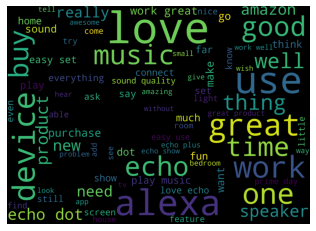

In [113]:
maskarray = np.array(Image.open("butterfly.png"))
cloud = WordCloud(background_color = "black", max_words = 80, mask = maskarray, stopwords = set(STOPWORDS))
cloud

cloud.generate(reviews)
#cloud.to_file("wordcloud.png")
plt.axis("off")
plt.imshow(cloud)

#### b) positive words wordcloud

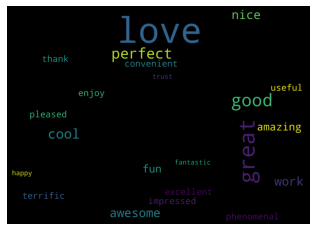

In [114]:
#separating positive words

with open("positive-words.txt","r") as pos:
    poswords = pos.read().split("\n")
    
#positive words wordcloud
pos_words = " ".join([w for w in data_list if w in poswords])

maskarray = np.array(Image.open("butterfly.png"))
cloud = WordCloud(background_color = "black", max_words = 300, mask = maskarray, stopwords = set(STOPWORDS))
cloud

cloud.generate(pos_words)
#cloud.to_file("wordcloud.png")
plt.axis("off")
plt.imshow(cloud)

In [115]:
pos_words

'love great awesome love love love cool love enjoy cool like like terrific love good great love love work work love trust thank thank love great love work good useful amazing work  love love love amazing perfect perfect great awesome love love love cool love enjoy cool like like terrific love good great love love useful love perfect nice love love love love nice great love love love excellent great love love perfect good love love cool fun love love amazing fun great love love love great love love love love love great fun love fantastic love love  awesome love perfect love happy love great great love good love good love perfect like good excellent awesome love love love great love great pleased nice impressed love love love love phenomenal convenient love good great pleased nice impressed love love love love phenomenal convenient love good'

#### c) negative words wordcloud

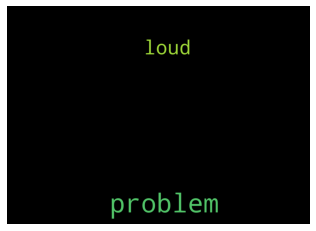

In [116]:
with open("negative-words.txt","r") as pos:
    negwords = pos.read().split("\n")
    
#negative word cloud
neg_words = " ".join([w for w in data_list if w in negwords])

maskarray = np.array(Image.open("butterfly.png"))
cloud = WordCloud(background_color = "black", max_words = 200, mask = maskarray, stopwords = set(STOPWORDS))
cloud

cloud.generate(neg_words)
#cloud.to_file("wordcloud.png")
plt.axis("off")
plt.imshow(cloud)

In [117]:
neg_words

'loud problem  problem '

In [118]:
a=len(pos_words)
b=len(neg_words)
c=len(reviews)
print(a)
print(b)
print(c)

850
22
247940


In [119]:
#conclusion
#out 3150 reviews approx 2850 reviews have 3, 4 and 5 star ratings
#from positive wordcloud we get to know that this amazon alexa is good, cool, amazing.

In [120]:
#emotion of people related to amazon alexa are - good, nice, love, great, fun, impressed etc.
#so people are very satisfied.